# Utilisation des données hmvl avec python/pandas
## 0. Initialisation

In [1]:
import pandas as pd
import matplotlib
import psycopg2
import arrow
import numpy as np

In [2]:
import scriptindic as scr
LABOCOM=['MPB','MPA','MPF','MPH','MPG','MPb','MPa','MPf','MPh','MPg','MBO','MBS','MBo','MBs','MBT','MBt']

In [107]:
# so besoin de remettre à jour le code des scripts:
import importlib
importlib.reload(scr)

<module 'scriptindic' from '/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/hmvl/scriptindic.py'>

## 1. Lecture des données
### 1.1. Connexion à la Base postgres et lecture d'une journée de données

In [3]:
host="localhost"
port=5432
dbname="hmvl"
username="dirmed"
#pwd="motdepasse"
# à remplacer par votre de mot de passe et surtout ne pas publier en ligne!!!

In [4]:
hmvl=scr.lirejourhmvl("2020-04-26",host,port,dbname,username,pwd)


### 1.2. Lecture d'un fichier csv d'un jour de données hmvl

In [93]:
nomcsv='/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/2020-07-22.csv'
hmvl=scr.lirecsvhmvl(nomcsv)
# hmvl=lirecsvhmvl(nomcsv)

2020-09-23 14:36:33.627198
2020-09-23 14:37:05.693488 après lecture du csv


## 2. rapide examen des données

In [38]:
hmvl.describe()


vitesse      longueur
count  6.484039e+06  6.512078e+06
mean   8.677861e+01  4.404256e+00
std    2.037820e+01  2.338502e+00
min    0.000000e+00  0.000000e+00
25%    7.700000e+01  3.600000e+00
50%    8.700000e+01  4.000000e+00
75%    9.800000e+01  4.500000e+00
max    9.990000e+02  9.990000e+01

In [49]:
hmvl.dtypes

hdt         datetime64[ns, UTC]
station                category
status                 category
voie                   category
vitesse                 float32
longueur                float32
statuttr               category
dtype: object

In [53]:
hmvl.memory_usage(index=True,deep=True)

Index            128
hdt         59534296
station     14897514
status       7442277
voie         7442343
vitesse     29767148
longueur    29767148
statuttr     7442619
dtype: int64

In [68]:
hmvl[['status','station','statuttr','voie']].describe()

status  station statuttr     voie
count   7208570  7441787  6855913  6657225
unique        5      147        8        6
top           0      M8F        @        1
freq    6424135   109270  3190125  2116665

In [7]:
hmvl.describe()

id        vitesse       longueur
count  1.583795e+06  842663.000000  849863.000000
mean   8.900456e+06      97.280174       4.107552
std    4.572024e+05      19.620940       1.856548
min    8.108559e+06       0.000000       0.000000
25%    8.504508e+06      85.000000       3.600000
50%    8.900456e+06      94.000000       4.000000
75%    9.296404e+06     108.000000       4.300000
max    9.692353e+06     999.000000      99.900000

### 2.1. Valeurs à conserver pour les agrégations

In [69]:
print(hmvl["statuttr"].value_counts(dropna=False))
# statuttr=NaN correspond à des status 1 ou 2 (trame vide)
# a priori on ne devrait garder que les statuts B et @
# mais en pratique on garde tous les statuttr, 
# on se basera seulement sur le champ status pour éliminer des mesures


@      3190125
B      2488012
J       753551
NaN     585874
H       423832
I          224
            95
b           73
1            1
Name: statuttr, dtype: int64


Les indicateurs de qualité donnent des stats sur les différents status 
### --> On peut éliminer les données de status 1,2,3,4 ainsi que les trames vides ou sans voie pour les analyses sur longueur, débit, vitesse 
On ne gardera ensuite pour les calculs agrégés que les mesures où status=0 (stations RD) ou NULL (labocom)

In [70]:
print(hmvl["status"].value_counts(dropna=False))
# le status est NaN pour les stations LABOCOM (sauf d'eventuels status 3,4 ajoutés par nous à la lecture)

0      6424135
2       582947
NaN     233217
1       199604
3         1419
4          465
Name: status, dtype: int64


### 2.2. Vérification des horodates

In [190]:
mi=hmvl['hdt'].min()
ma=hmvl['hdt'].max()
print(mi)
print(ma)
print(ma-mi)
# on vérifie que les horodates sont bien sur toute la journée

2020-07-22 00:00:00+02:00
2020-07-22 23:59:59.061000+02:00
0 days 23:59:59.061000


In [67]:
hmvl.dtypes

hdt         datetime64[ns, Europe/Paris]
station                         category
status                          category
voie                            category
vitesse                          float32
longueur                         float32
statuttr                        category
dtype: object

In [176]:
# vérification si les secondes sont bien réparties
# un petit doute sur la lecture des fractions de seconde dans les trames hmvl 11 caractères
sec=hmvl['hdt'].dt.second
usec=hmvl['hdt'].dt.microsecond

In [180]:
x=hmvl.assign(sec=sec)

In [182]:
x=x.assign(usec=usec)

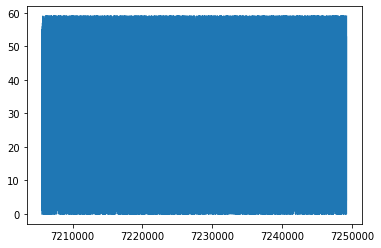

In [188]:
x[x['station']=='MBO']['sec'].plot()

In [189]:
# conclusion il semble que les secondes et fractions de secondes des PM RD et Labocom soient Ok
# uniformément réparties de 0 à 60, 0 à 999999 resp.

### 2.4 seuils de mesures aberrantes?

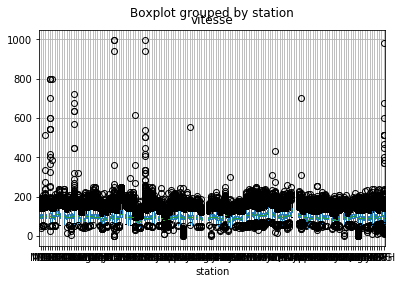

In [216]:
hmvl.boxplot(column=["vitesse"],by="station")
# ça semble raisonnable de prendre 240 comme valeur seuil de vitesse

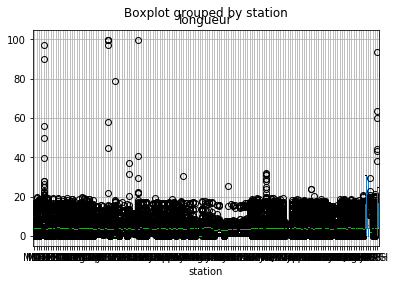

In [217]:
hmvl.boxplot(column=["longueur"],by="station")
# ça semble raisonnable de prendre 25 comme valeur seuil de longueur, 
# mais il y a peut être valeur plus pertinente pour le métier, à cause des Transports Exceptionnels par exemple?
# ou pour voir passer les convois ITER s'ils empruntent le réseau DIRMED?

In [218]:
print(hmvl['voie'].value_counts())
# on a éliminé de hmvl les mesures sans numéro de voie
# il y a des voies de 0 à 5 selon les Points de Mesure
# certaines voies correspondent peut être à des bretelles, attention pour l'agrégation?
sum(pd.isna(hmvl['voie']))

0    399281
1    281989
2    120687
3     58672
4     25850
5      2932
Name: voie, dtype: int64


694384

In [129]:
s6=pd.date_range('2020-04-26 10:00:00', periods=6000, freq='6S')

In [132]:
h0=hmvl['hdt0'].unique()

In [16]:
print(len(hmvl[hmvl['vitesse']==0.0]))
# 87 valeurs de vitesse sur 1M+ sont nullesprint(len(hmvl[hmvl['vitesse']==0.]))

87


In [164]:
arrow.get(hmvl['hdt0'].iloc[10000]).format("YYYY-MM-DD HH:mm:ss")
#arrow.get(s6[100]).format("YYYY-MM-DD HH:mm:ss")

'2020-04-26 22:54:48'

### 2.5. recherche de doublons

In [41]:
hmvl.index.value_counts()
# il reste des doublons, à investiguer, ça peut expliquer les débits aberrants

2020-04-27 16:32:14.890000+02:00    9
2020-04-27 11:52:53.310000+02:00    8
2020-04-27 15:31:37.690000+02:00    7
2020-04-27 08:36:22.230000+02:00    7
2020-04-25 12:36:34.680000+02:00    7
                                   ..
2020-04-25 16:37:37.260000+02:00    1
2020-04-26 17:39:54.160000+02:00    1
2020-04-27 13:12:19.760000+02:00    1
2020-04-25 10:11:57.650000+02:00    1
2020-04-26 08:33:41.990000+02:00    1
Name: hdt, Length: 3752405, dtype: int64

In [8]:
hmvl.head(5)

id                              hdt station voie  vitesse  longueur  \
8    9 2020-04-25 06:40:24.620000+00:00     M3d    0     81.0       4.0   
11  12 2020-04-25 06:40:29.180000+00:00     M5h    1     75.0       3.0   
12  13 2020-04-25 06:40:26.260000+00:00     M5l    3     87.0       4.1   
13  14 2020-04-25 06:40:30.830000+00:00     M3j    0     71.0       4.9   
14  15 2020-04-25 06:40:31.800000+00:00     M3j    1     90.0       4.0   

   statuttr  
8         B  
11        B  
12        B  
13        @  
14        @

In [46]:
print(str(len(hmvl.groupby("hdt")["id"].unique())))
print(str(len(hmvl.groupby(["hdt","station","voie"])["id"].unique())))
# sur 4,3M mesures, seulement 52092 correspondent à une seule horodate

3752405
4498929


In [48]:
len(hmvl)- 4498929
# 2729 doublons hdt+station+voie sur 4,5M de mesures
# idéalement il faudrait les supprimer

2729

In [9]:
id_hv=hmvl.groupby(["hdt","station","voie"])["id"].unique()
id_hv.apply(len).value_counts()
# sur 1,8M mesures, il y désormais très peu de doublons, moins de 1 pour mille
# 

1    4331949
2       2729
Name: id, dtype: int64

In [24]:
doubles=[]
for i in range(len(id_hv)):
    x=id_hv.iloc[i]
    y=id_hv.index[i]
    if len(x)<2: continue
    doubles.append((x,y))

In [29]:
# il y a peu de doublons, difficile de dire à quoi ils sont dus, 
# on note que ils correspondent à des indices proches, mais c'est normal puisque les mesures sont lues dans l'ordre chrono
# donc des mesures de même horodate sont en principe dans des fichiers proches
# la mesure a priori serait de supprimer un des 2 doublons.
# cela peut être fait a posteriori en base en SQL  mais ça risque d'être un peu lourd à effectuer

In [28]:
doubles[1200:1400]

[(array([3696707, 3735577]),
  (Timestamp('2020-04-27 08:38:58+0000', tz='UTC'), 'M4k', '2')),
 (array([3698151, 3785019]),
  (Timestamp('2020-04-27 08:39:48.970000+0000', tz='UTC'), 'M8b', '0')),
 (array([3785903, 3787489]),
  (Timestamp('2020-04-27 08:40:14.360000+0000', tz='UTC'), 'M7V', '0')),
 (array([3688764, 3690438]),
  (Timestamp('2020-04-27 08:41:03.590000+0000', tz='UTC'), 'M3k', '4')),
 (array([3689747, 3691465]),
  (Timestamp('2020-04-27 08:41:17.940000+0000', tz='UTC'), 'M3l', '1')),
 (array([3690289, 3692021]),
  (Timestamp('2020-04-27 08:41:25.790000+0000', tz='UTC'), 'M3x', '1')),
 (array([3690220, 3691933]),
  (Timestamp('2020-04-27 08:41:32.910000+0000', tz='UTC'), 'M4g', '1')),
 (array([3691483, 3781654]),
  (Timestamp('2020-04-27 08:42:11.800000+0000', tz='UTC'), 'M8K', '1')),
 (array([3781646, 3783264]),
  (Timestamp('2020-04-27 08:42:12.250000+0000', tz='UTC'), 'M3i', '1')),
 (array([3782708, 3784335]),
  (Timestamp('2020-04-27 08:42:54.430000+0000', tz='UTC'), '

### conclusion : à court terme on laisse les doublons dans les mesures, ils en représentent moins de 1/1000 

### 2.6 indicateurs par voie

In [35]:
# on pourrait faire des indicateurs par voie
def indicqualitevoie(hmvl):
	# création d'un dataframe d'indicateurs qualité, exportable ensuite en CSV et/ou en BD postgres
	nbmes=hmvl.assign(heure=pd.to_datetime(hmvl['hdt']).dt.to_period('H'))
	nbmes=nbmes.groupby(['station','voie','heure']).count().sort_values(by=['station','voie'])
	nbmes=nbmes.rename(columns={'hdt':'nb_mes','vitesse':'nbmesvit','longueur':'nbmeslong'})
	nbmes=nbmes[['nb_mes','nbmesvit','nbmeslong']]
	status2=hmvl[hmvl["status"]=="2"][["station","voie","hdt"]]
	status2=status2.assign(heure=pd.to_datetime(status2['hdt']).dt.to_period('H'))
	status2=status2.groupby(['station','voie','heure']).count().sort_values(by=['station','voie'])
	status2=status2.rename(columns={'hdt':'nb_status2'})
	status1=hmvl[hmvl["status"]=="1"][["station","voie","hdt"]]
	status1=status1.assign(heure=pd.to_datetime(status1['hdt']).dt.to_period('H'))
	status1=status1.groupby(['station','voie','heure']).count().sort_values(by=['station','voie'])
	status1=status1.rename(columns={'hdt':'nb_status1'})
	qualite=pd.merge(nbmes,status2,on=['station','voie','heure'],how='outer')
	qualite=pd.merge(qualite,status1,on=['station','voie','heure'],how='outer')
	qualite=qualite.sort_index()
	qualite=qualite.fillna(0.0)
	return qualite

In [36]:
q=indicqualitevoie(hmvl)

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [37]:
q.head(20)
# à creuser : comment identifier les voies posant problème? (alertes)

nb_mes  nbmesvit  nbmeslong  nb_status2  \
station voie heure                                                       
M1B     1    2020-04-26 08:00     105       105        105         0.0   
             2020-04-26 09:00     202       202        202         0.0   
             2020-04-26 10:00     264       264        264         0.0   
             2020-04-26 11:00     320       320        320         0.0   
             2020-04-26 12:00     292       292        292         0.0   
             2020-04-26 13:00     276       276        276         0.0   
             2020-04-26 14:00     290       290        290         0.0   
             2020-04-26 15:00     234       234        234         0.0   
             2020-04-26 16:00     318       318        318         0.0   
             2020-04-26 17:00     362       362        362         0.0   
             2020-04-26 18:00     348       348        348         0.0   
             2020-04-26 19:00     354       354        354         0.0   
             2020-04-26 20:00     244       244        244         0.0   
             2020-04-26 21:00     173       173        173         0.0   
             2020-04-26 22:00     120       120        120         0.0   
             2020-04-26 23:00       4         4          4         0.0   
        2    2020-04-26 08:00      15        15         15         0.0   
             2020-04-26 09:00      16        16         16         0.0   
             2020-04-26 10:00      25        25         25         0.0   
             2020-04-26 11:00      44        44         44         0.0   

                               nb_status1  
station voie heure                         
M1B     1    2020-04-26 08:00         0.0  
             2020-04-26 09:00         0.0  
             2020-04-26 10:00         0.0  
             2020-04-26 11:00         0.0  
             2020-04-26 12:00         0.0  
             2020-04-26 13:00         0.0  
             2020-04-26 14:00         0.0  
             2020-04-26 15:00         0.0  
             2020-04-26 16:00         0.0  
             2020-04-26 17:00         0.0  
             2020-04-26 18:00         0.0  
             2020-04-26 19:00         0.0  
             2020-04-26 20:00         0.0  
             2020-04-26 21:00         0.0  
             2020-04-26 22:00         0.0  
             2020-04-26 23:00         0.0  
        2    2020-04-26 08:00         0.0  
             2020-04-26 09:00         0.0  
             2020-04-26 10:00         0.0  
             2020-04-26 11:00         0.0

In [39]:
q[q['nb_mes']<10]

nb_mes  nbmesvit  nbmeslong  nb_status2  \
station voie heure                                                       
M1B     1    2020-04-26 23:00       4         4          4         0.0   
M1C     0    2020-04-26 23:00       2         2          2         0.0   
        1    2020-04-26 23:00       1         1          1         0.0   
        2    2020-04-26 23:00       1         1          1         0.0   
M1D     2    2020-04-26 08:00       7         7          7         0.0   
...                               ...       ...        ...         ...   
MPH     3    2020-04-26 19:00       9         9          9         0.0   
             2020-04-26 20:00       6         6          6         0.0   
             2020-04-26 21:00       7         7          7         0.0   
             2020-04-26 22:00       5         5          5         0.0   
             2020-04-26 23:00       6         6          6         0.0   

                               nb_status1  
station voie heure                         
M1B     1    2020-04-26 23:00         0.0  
M1C     0    2020-04-26 23:00         0.0  
        1    2020-04-26 23:00         0.0  
        2    2020-04-26 23:00         0.0  
M1D     2    2020-04-26 08:00         0.0  
...                                   ...  
MPH     3    2020-04-26 19:00         0.0  
             2020-04-26 20:00         0.0  
             2020-04-26 21:00         0.0  
             2020-04-26 22:00         0.0  
             2020-04-26 23:00         0.0  

[1046 rows x 5 columns]

## 3. Calcul d'indicateurs par station et par heure pour un jour donné

In [88]:
import collections
voie_s=collections.defaultdict(list)
avs=pd.read_csv('ressources/assoc-voie-station.csv')
for i in range(avs.shape[0]-1):
	voie_s[avs.iloc[i,1]].append(avs.iloc[i,2])
vinex=hmvl.assign(v_inex=lambda x: x.voie in voie_s[str(x.station)])
vinex=vinex[["station","hdt","v_inex"]]
vinex['v_inex']=vinex['v_inex'].astype(int)
vinex=vinex.assign(heure=pd.to_datetime(vinex['hdt']).dt.to_period('H'))
vinex=vinex.groupby(['station','heure']).sum().sort_values(by='station')

In [91]:
vinex.count()

v_inex    3528
dtype: int64

In [96]:
qualite=scr.indicqualite(hmvl)

In [97]:
qualite

station             heure  nb_mes  nb_mesvit  nb_meslong  nb_status2  \
0        M1B  2020-07-22 00:00     642      91.90       91.90        2.65   
1        M1B  2020-07-22 01:00     668      91.77       91.77        2.10   
2        M1B  2020-07-22 02:00     971      80.74       80.74        3.91   
3        M1B  2020-07-22 03:00     748      62.30       62.30        7.09   
4        M1B  2020-07-22 04:00     668      40.57       40.57       13.77   
...      ...               ...     ...        ...         ...         ...   
3523     MPH  2020-07-22 19:00    2285      72.69       72.69        0.00   
3524     MPH  2020-07-22 20:00    1553      72.50       72.50        0.00   
3525     MPH  2020-07-22 21:00    1072      74.25       74.25        0.00   
3526     MPH  2020-07-22 22:00     886      71.44       71.44        0.00   
3527     MPH  2020-07-22 23:00     712      69.66       69.66        0.00   

      nb_status1  nb_status34  nb_vinex  nb_sansvoie  nb_l_aberr  nb_v_aberr  \
0           5.30          0.0       0.0          0.0        0.00         0.0   
1           5.84          0.0       0.0          0.0        0.00         0.0   
2          15.35          0.0       0.0          0.0        0.00         0.0   
3          30.61          0.0       0.0          0.0        0.00         0.0   
4          45.66          0.0       0.0          0.0        0.00         0.0   
...          ...          ...       ...          ...         ...         ...   
3523        0.00          0.0       0.0          0.0        0.39         9.0   
3524        0.00          0.0       0.0          0.0        0.26         4.0   
3525        0.00          0.0       0.0          0.0        0.37         4.0   
3526        0.00          0.0       0.0          0.0        0.23         2.0   
3527        0.00          0.0       0.0          0.0        0.14         1.0   

      taux_fichiersRD6sec_absents  
0                           52.17  
1                           47.83  
2                            2.17  
3                            0.17  
4                            0.00  
...                           ...  
3523                          NaN  
3524                          NaN  
3525                          NaN  
3526                          NaN  
3527                          NaN  

[3528 rows x 13 columns]

In [15]:
# on observe que le nb de mesures de vitesse et de longueur est très souvent identique (mais pas toujours!)
test=qualite['nb_mes']-qualite['nbmeslong']-qualite['nb_status1']-qualite['nb_status2']-qualite['nb_status34']

In [76]:
len(set(qualite.index[qualite['nb_mes']> 5.0*qualite['nbmesvit']].get_level_values('station').to_list()))

71

In [63]:
len(set(qualite.index.get_level_values('station').to_list()))

146

In [77]:
hmvl[hmvl['statuttr'].isna()]

hdt station status voie  vitesse  longueur  \
0       2020-07-22 00:36:42+02:00     M7q      2  NaN      NaN       NaN   
1       2020-07-22 00:36:42+02:00     M7Q      2  NaN      NaN       NaN   
2       2020-07-22 00:36:42+02:00     M3j      2  NaN      NaN       NaN   
3       2020-07-22 00:36:42+02:00     M3q      2  NaN      NaN       NaN   
4       2020-07-22 00:36:42+02:00     M3z      2  NaN      NaN       NaN   
...                           ...     ...    ...  ...      ...       ...   
7407900 2020-07-22 09:24:00+02:00     MPH      1  NaN      NaN       NaN   
7416624 2020-07-22 12:27:00+02:00     MPH      1  NaN      NaN       NaN   
7428787 2020-07-22 16:40:00+02:00     MPH      1  NaN      NaN       NaN   
7429097 2020-07-22 17:01:00+02:00     MPH      1  NaN      NaN       NaN   
7429098 2020-07-22 17:02:00+02:00     MPH      1  NaN      NaN       NaN   

        statuttr  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
7407900      NaN  
7416624      NaN  
7428787      NaN  
7429097      NaN  
7429098      NaN  

[585874 rows x 7 columns]

## 4. Fonction de calcul des données 6 minutes à partir d'un dataframe hmvl, en principe pour une journée

In [47]:
moy6=scr.agreg6(hmvl)


/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/hmvl/scriptindic.py:177: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  moy6=x.groupby(['station'])['longueur','invvit'].resample('6Min').mean()


In [85]:
moy6

l6      v6   q6
station hdt                                         
M1B     2020-07-22 00:30:00+02:00  3.96   89.09  115
        2020-07-22 00:36:00+02:00  4.27   91.33  132
        2020-07-22 00:42:00+02:00  4.10   91.71  109
        2020-07-22 00:48:00+02:00  3.91   94.05  126
        2020-07-22 00:54:00+02:00  4.01   94.46  102
...                                 ...     ...  ...
MPH     2020-07-22 23:30:00+02:00  9.07  100.30   46
        2020-07-22 23:36:00+02:00  9.26   98.91   57
        2020-07-22 23:42:00+02:00  8.79   99.50   52
        2020-07-22 23:48:00+02:00  6.95  102.14   41
        2020-07-22 23:54:00+02:00  7.82  102.08   43

[26508 rows x 3 columns]

## 4. calcul des TIV (temps inter-véhiculaires) et DIV


In [25]:
# calcul des temps et distances inter-véhiculaires par heure, par voie et par station


In [26]:
# le calcul passe par une fonction intermédiaire tiv qui ajoute 1 colonne TIV et une colonne DIV au dataframe hmvl


# PROPOSITION : on pourrait ajouter une colonne tauxtiv1s avec le taux en % de TIV inférieurs à 1 seconde

In [31]:
tdiv1H=scr.agregtdiv1H(hmvl)

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [32]:
tdiv1H

station voie             heure    tiv      div
0        M1B    0  2020-07-22 00:00   6.64   163.67
1        M1B    0  2020-07-22 01:00   7.04   175.40
2        M1B    0  2020-07-22 02:00  16.39   448.15
3        M1B    0  2020-07-22 03:00  21.77   567.13
4        M1B    0  2020-07-22 04:00  41.40  1032.36
...      ...  ...               ...    ...      ...
9438     MPH    3  2020-07-22 19:00  13.33   442.58
9439     MPH    3  2020-07-22 20:00  20.81   688.99
9440     MPH    3  2020-07-22 21:00  31.80  1019.44
9441     MPH    3  2020-07-22 22:00  51.33  1680.35
9442     MPH    3  2020-07-22 23:00  86.67  2781.45

[9443 rows x 5 columns]

In [ ]:
#à creuser : certains TIV peuvent être nuls
# certains TIV peuvent être <0 ! en fait il semble que ce soit pour le 1er TIV de la journée à 00:00
# vu sur la journée du 2/9 -> bug à corriger

In [92]:
x=hmvl
if (x['hdt'].max() - x['hdt'].min() >= pd.Timedelta('1 days')):
    print ("ATTENTION: le dataframe hmvl en entrée de tiv est sur + de 24H !!!")
x=x[x["voie"].notna()]
# on enlève les mesures sans voie
x=x[(x["status"]=="0")|(x["status"].isna())][["hdt","station","voie","vitesse","longueur","statuttr"]]
# on enlève les mesures de status 1,2,3,4   (status vide : stations labocom)
x=x.sort_values(['station','voie','hdt'])
x['tiv']=(x['hdt']-x['hdt'].shift())
# cf. https://stackoverflow.com/questions/16777570/
# on ne garde que les lignes qui ne sont pas vides (NaT : en fait la 1ère ligne, car .shift() est alors vide)
#   ou dont le tiv n'est pas négatif (on suppose qu'on travaille sur 1 journée de 00:00 à 23:59!!)
#   ou dont la voie est la même que la précédente (les données sont classées par voie, il faut donc
#   enlever les lignes de x dont la ligne précédente a une valeur de voie différente)


In [14]:
x=scr.tiv(hmvl)


In [15]:
# la fonction tiv supprime bien les tiv négatifs 
#(correspondant soit à un changement de voie ou un changement de jour entre 2 mesures successives dans le dataframe)
x[x['tiv']<=0.]

Empty DataFrame
Columns: [hdt, station, voie, vitesse, longueur, statuttr, tiv, div]
Index: []

## 5. Calcul des trames 6 secondes manquantes

A noter que les données labocom sont fournies chaque minute, contrairement aux données RD envoyées en principe chaque 6 secondes. Comme on utilise la colonne hdt0, ça ne donne pas de résultat pertinent pour les Labocom.

A noter aussi qu'il peut y avoir des horodates dans les fichiers qui ne sont pas des multiples de 6 secondes (on les compte dans la variable trames6enplus.

Ce calcul a été intégré dans les indicateurs qualité

## TESTS d'ALERTES SUR LES INDICATEURS

In [102]:
# on utilise la fonction alertes qui part d'un dataframe q produit par indicqualite
# en 1ere approche la fonction affiche pour chaque type d'alerte la liste des stations en alerte
# on calcule les alertes sur la base de valeurs moyennes des taux de défaut par heure et de seuils pour ces valeurs
# d'autres méthodes de calcul sont possibles bien sûr
# il faudra aussi que les textes affichés soient envoyés dans un fichier journalier
# et que la fonction puisse être appelée en ligne de commande





In [108]:
scr.alertes(qualite)

Stations avec taux moyen de status2 (pas de réponse ou délai>150ms) > 70% :['M1E', 'M4e', 'M4i', 'M4k', 'M7q', 'M3w', 'M3S', 'M3k', 'M8Q', 'M7Q', 'M3b', 'M3L', 'M4c', 'M1e', 'M5r']
Stations avec taux moyen de trames vides (status1) > 50% :['M8G', 'M1c', 'M8a', 'MPG']
Stations avec taux moyen de trames incorrectes (status3,4) > 1% :[]
Stations (en principe seulement Labocom) avec taux moyen de mesures sans valeurs (L, V, voie) > 20% :[]
Stations avec voie inexistante :[]
Stations avec taux moyen de vitesses aberrantes (>240km/h) > 2% :['M1d', 'M3P', 'MPH', 'M1G', 'M3r']
Stations avec taux moyen de longueurs aberrantes (<50cm ou >25m) > 2% :['M3r']
Stations RD (non Labocom) avec taux moyen de fichiers RD 6 sec non reçus > 10% :set()


"\nStations avec taux moyen de status2 (pas de réponse ou délai>150ms) > 70% :['M1E', 'M4e', 'M4i', 'M4k', 'M7q', 'M3w', 'M3S', 'M3k', 'M8Q', 'M7Q', 'M3b', 'M3L', 'M4c', 'M1e', 'M5r']\nStations avec taux moyen de trames vides (status1) > 50% :['M8G', 'M1c', 'M8a', 'MPG']\nStations avec taux moyen de trames incorrectes (status3,4) > 1% :[]\nStations (en principe seulement Labocom) avec taux moyen de mesures sans valeurs (L, V, voie) > 20% :[]\nStations avec voie inexistante :[]\nStations avec taux moyen de vitesses aberrantes (>240km/h) > 2% :['M1d', 'M3P', 'MPH', 'M1G', 'M3r']\nStations avec taux moyen de longueurs aberrantes (<50cm ou >25m) > 2% :['M3r']\nStations RD (non Labocom) avec taux moyen de fichiers RD 6 sec non reçus > 10% :set()"

## 6. stockage des indicateurs

In [249]:
# a priori la DIRMED n'a pas besoin de stocker les données d'indicateurs ou agrégées en base


In [250]:
scr.ecrireagreg6(moy6,pwd)
# écriture en base pg : cette fonction est donc obsolète

In [266]:
# écriture en base pg : de même fonction obsolète
scr.ecrirequalite(qualite,pwd)

In [275]:
# la fonction tocsv écrit les données agrégées ou indicateurs dans un fichier csv


In [276]:
scr.tocsv(qualite,'/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/q264.csv')

In [277]:
scr.tocsv(moy6,'/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/m264.csv')


In [ ]:
scr.tocsv(tdiv1H,'/home/patgendre/windows/Users/pmgen/Documents/infomobi/essais/test-hmvl/tdiv2207.csv')

## 7. quelques essais de graphes

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opene

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opene

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opene

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opene

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opene

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opene

station
M1B    AxesSubplot(0.125,0.125;0.775x0.755)
M1C    AxesSubplot(0.125,0.125;0.775x0.755)
M1D    AxesSubplot(0.125,0.125;0.775x0.755)
M1E    AxesSubplot(0.125,0.125;0.775x0.755)
M1F    AxesSubplot(0.125,0.125;0.775x0.755)
                       ...                 
MPA    AxesSubplot(0.125,0.125;0.775x0.755)
MPB    AxesSubplot(0.125,0.125;0.775x0.755)
MPF    AxesSubplot(0.125,0.125;0.775x0.755)
MPG    AxesSubplot(0.125,0.125;0.775x0.755)
MPH    AxesSubplot(0.125,0.125;0.775x0.755)
Length: 147, dtype: object

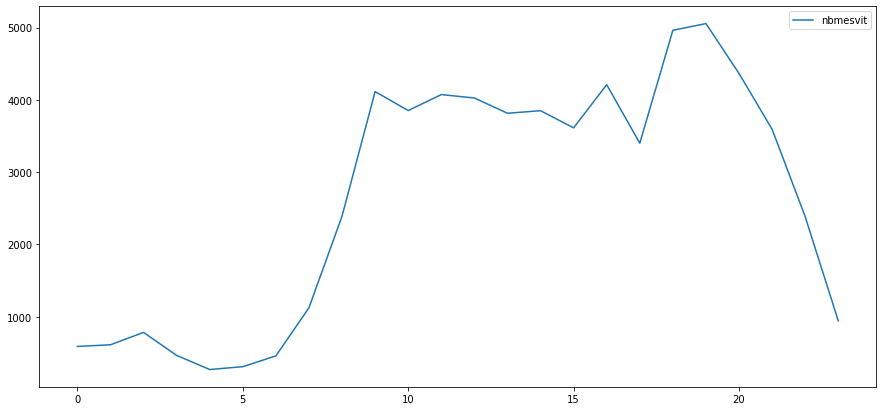

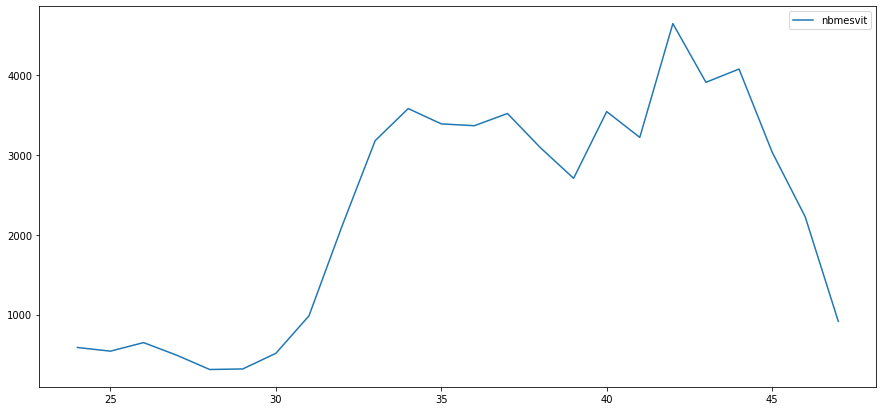

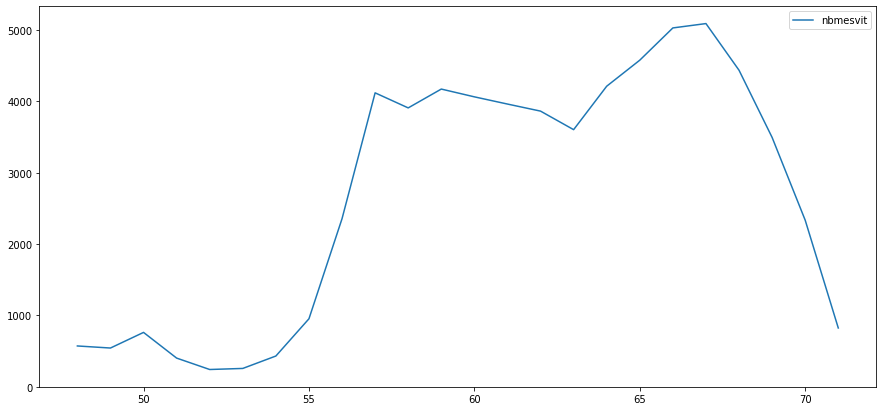

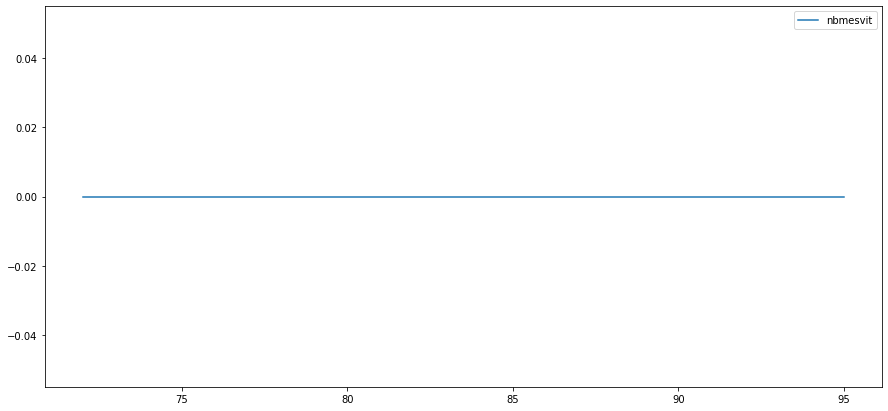

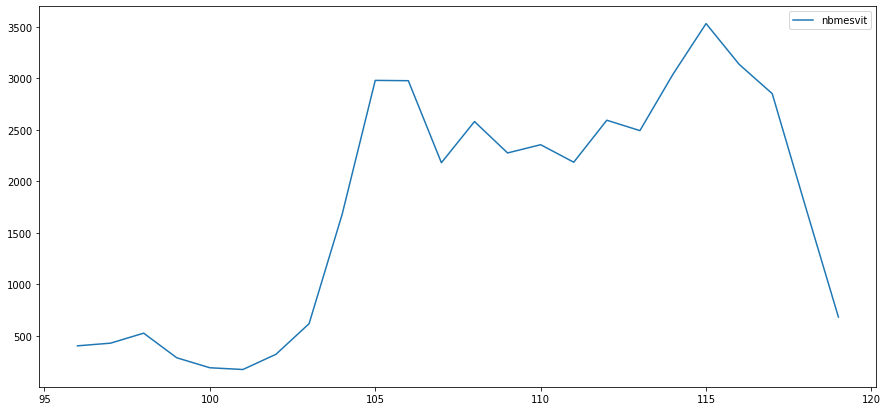

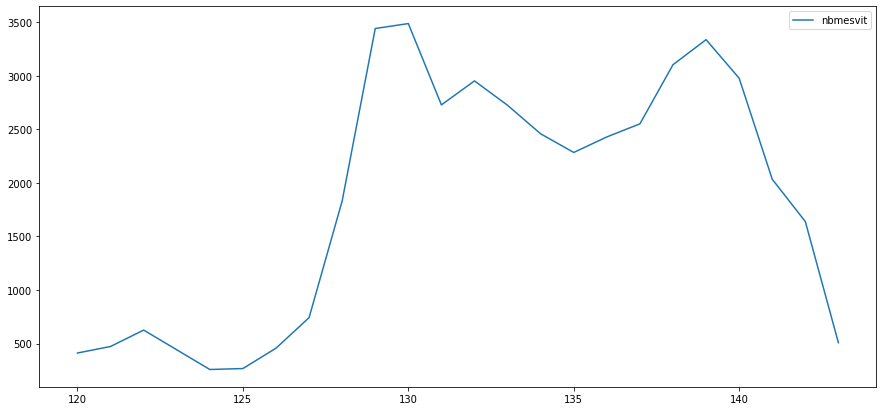

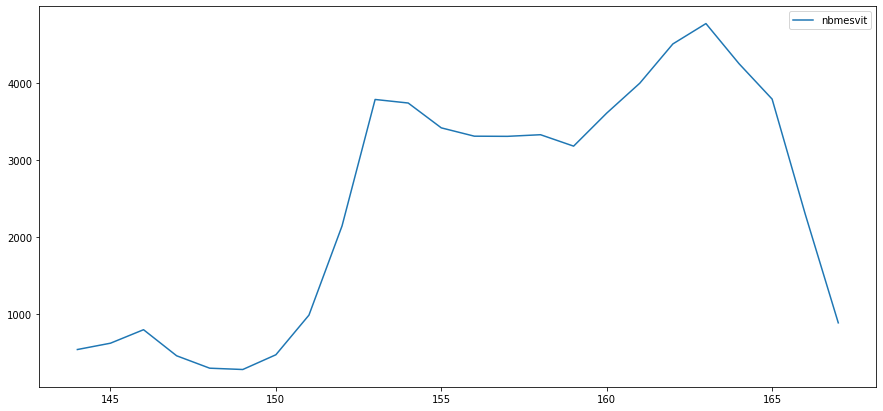

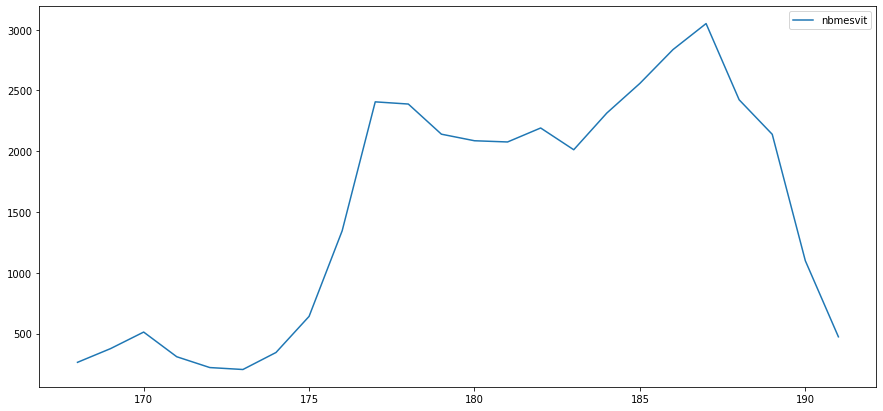

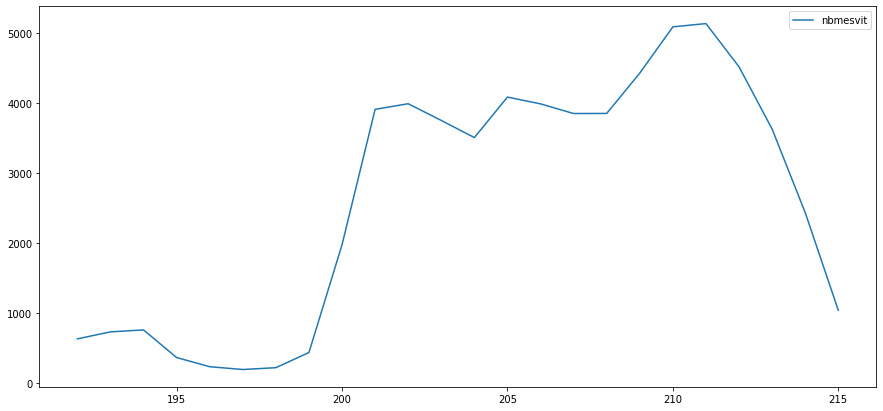

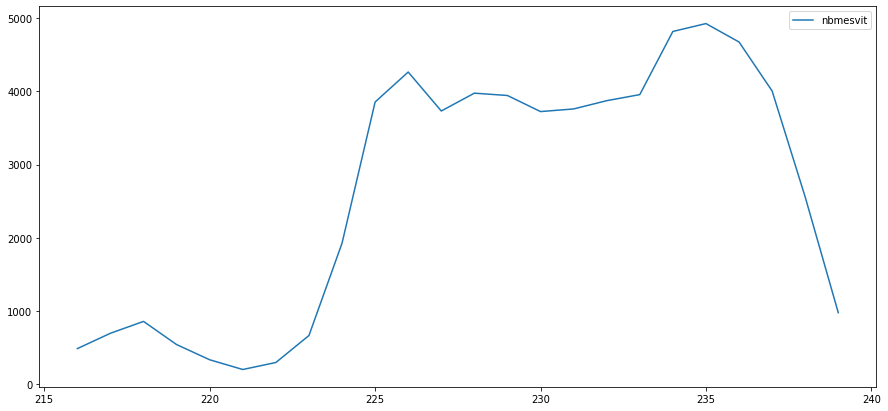

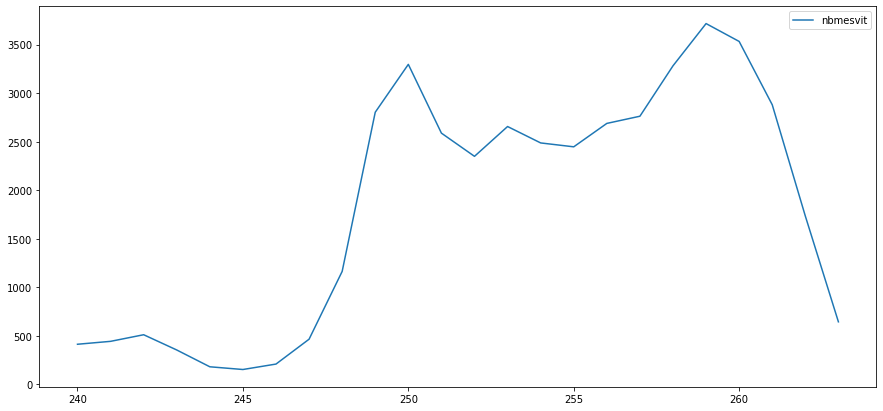

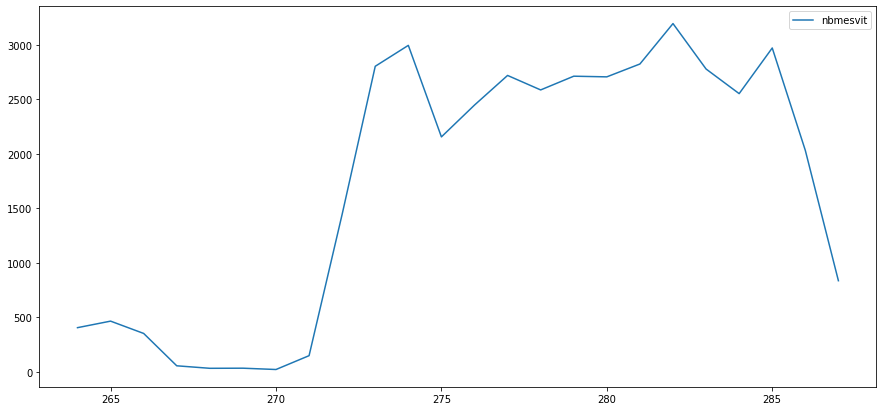

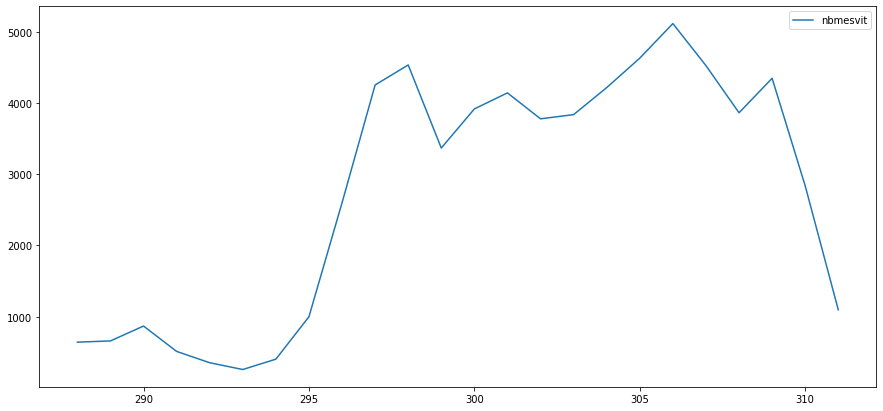

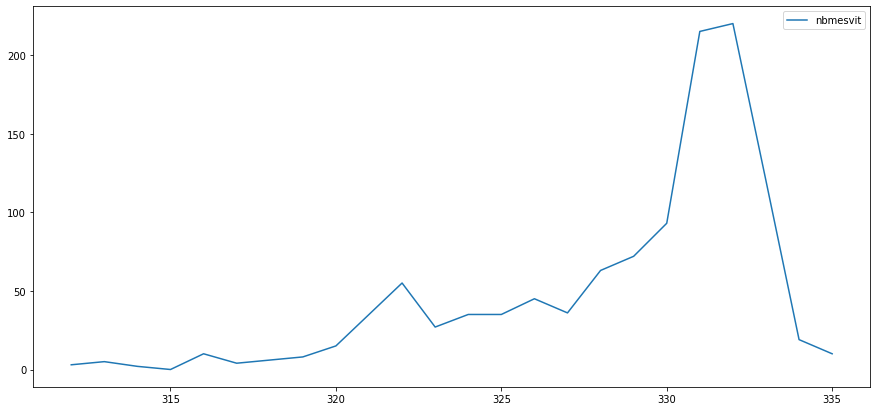

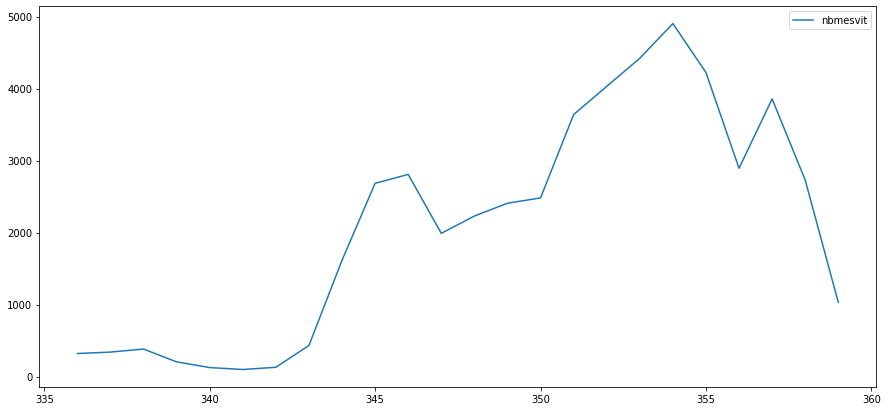

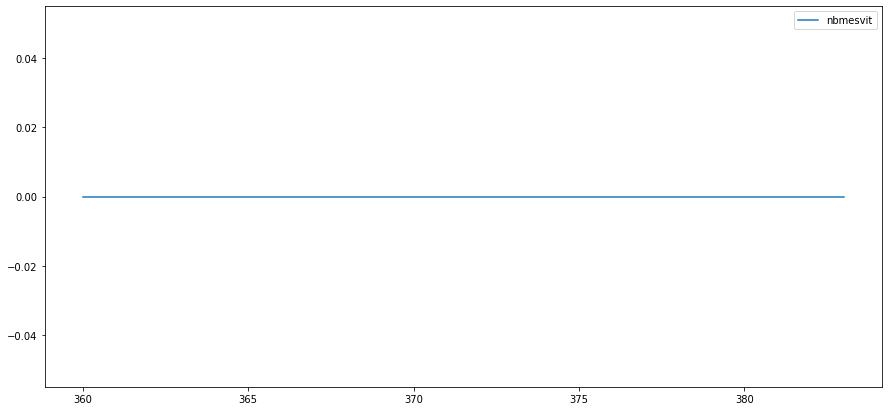

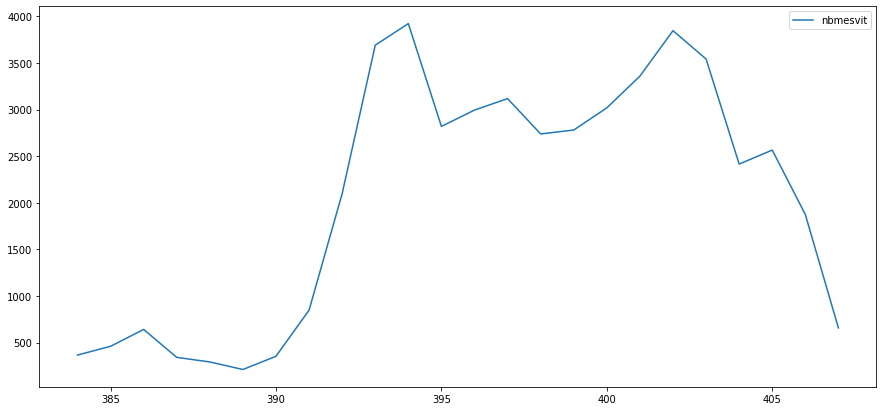

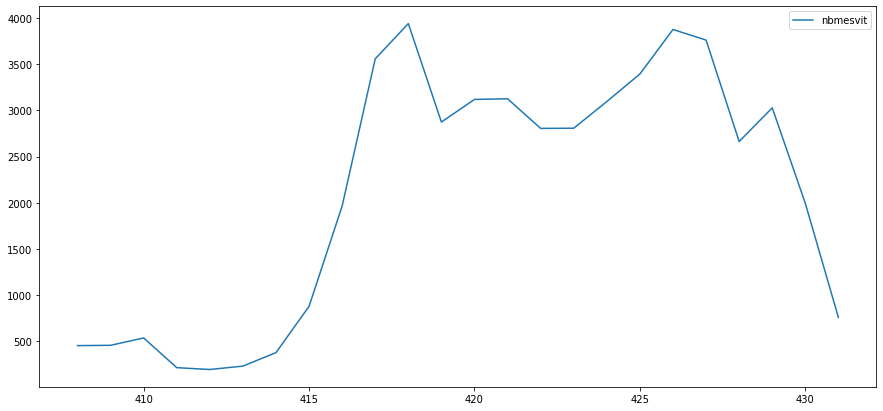

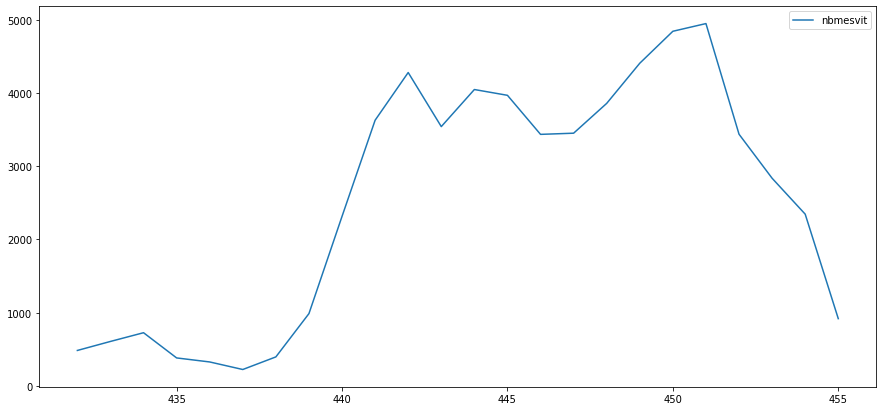

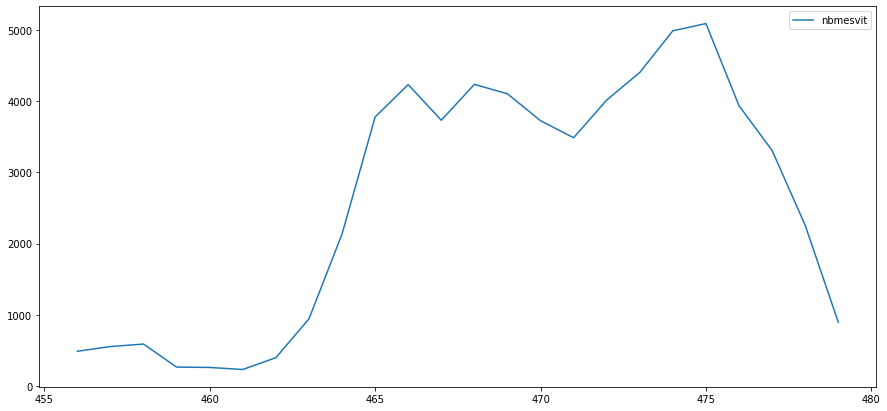

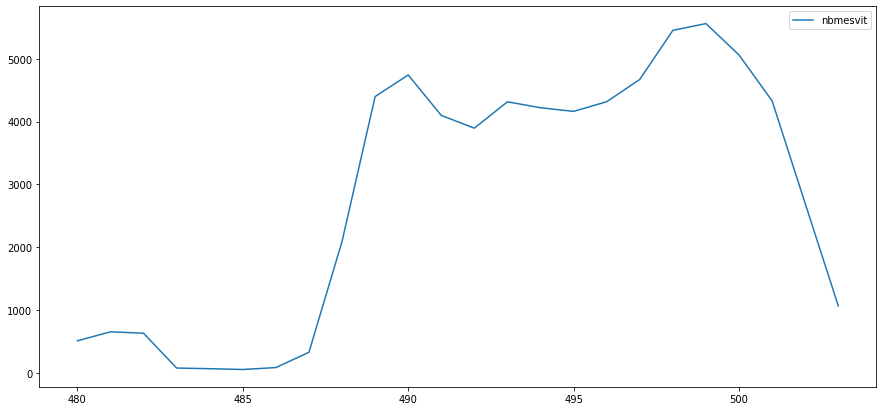

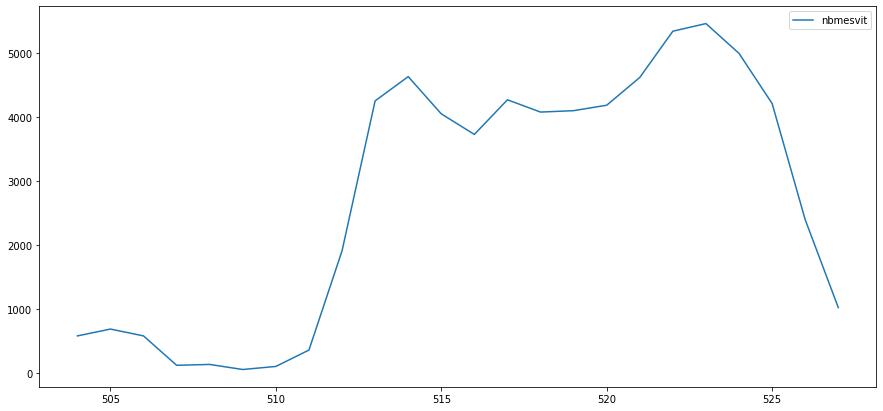

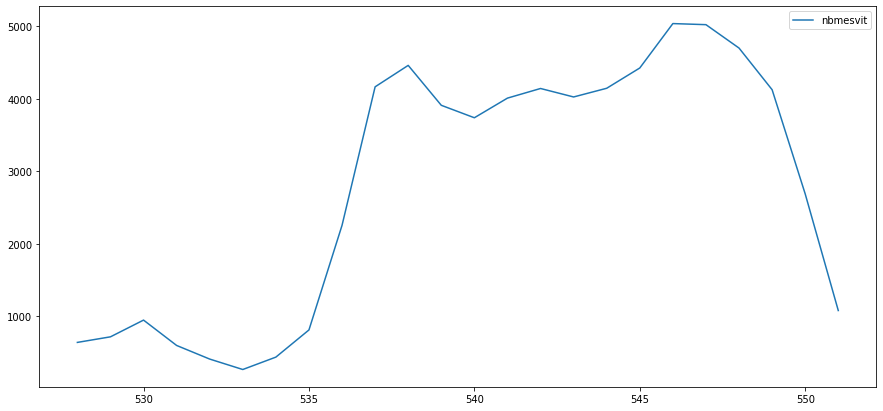

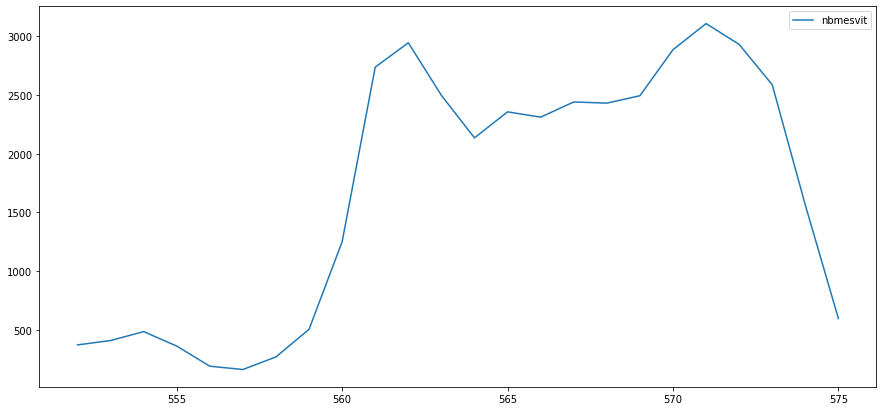

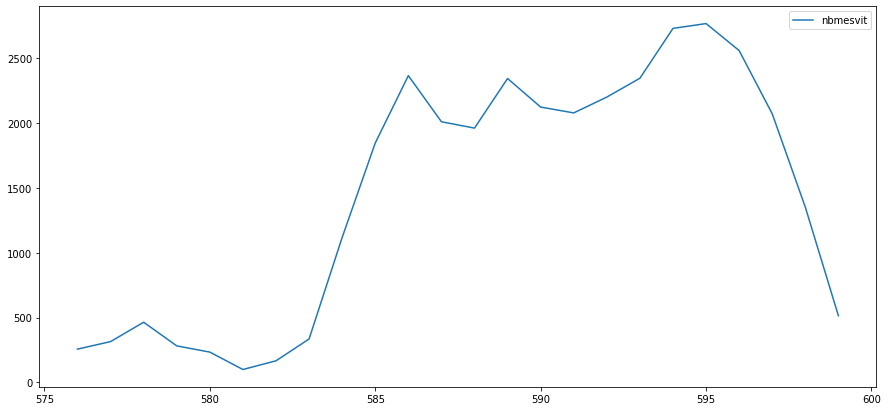

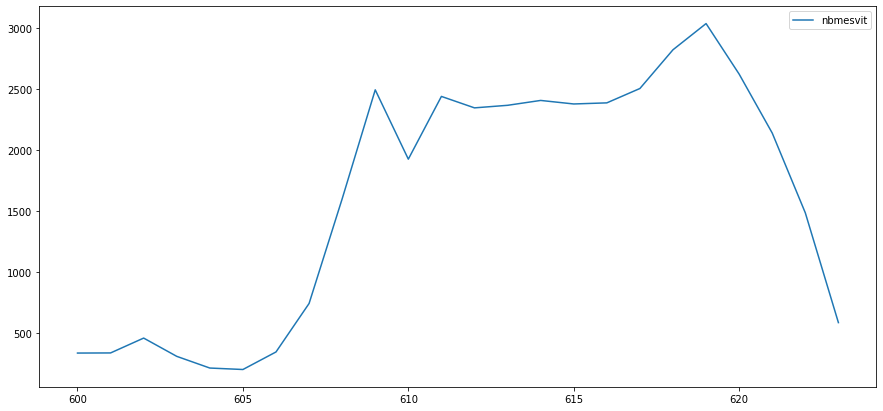

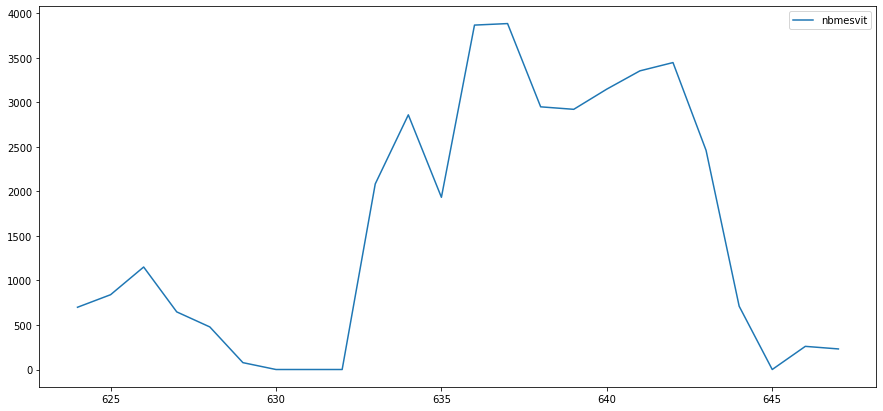

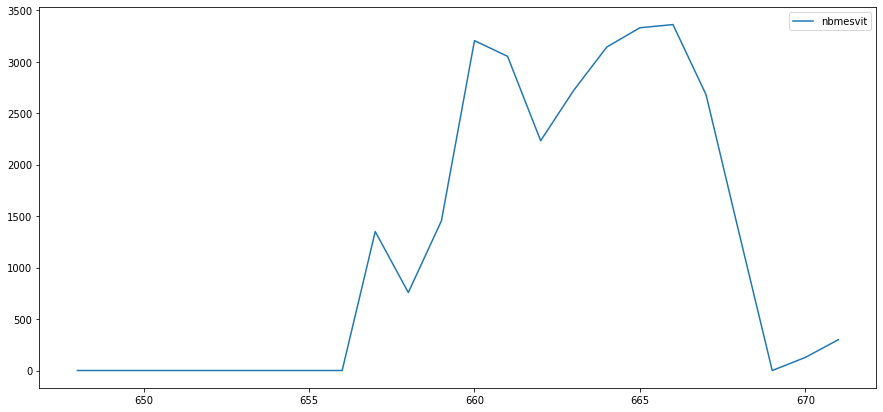

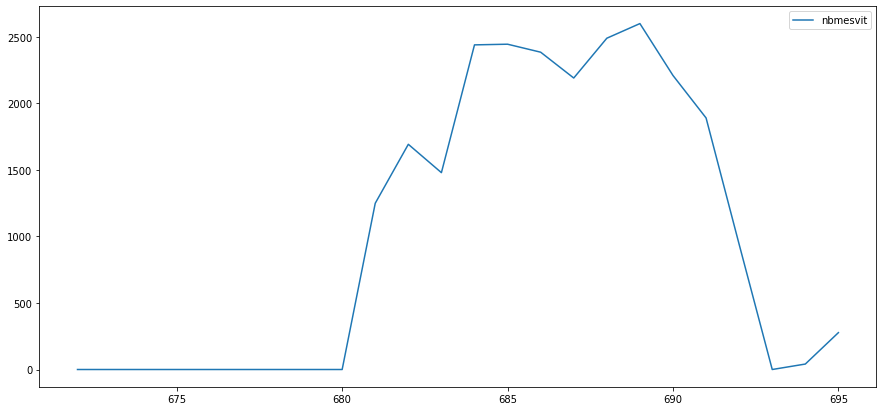

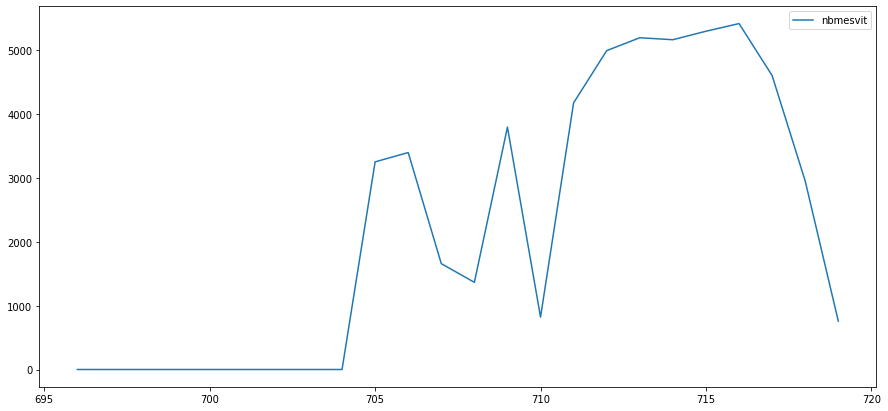

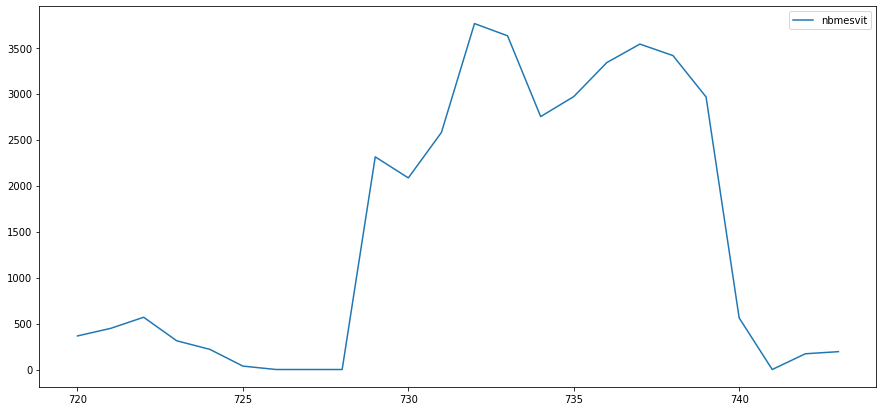

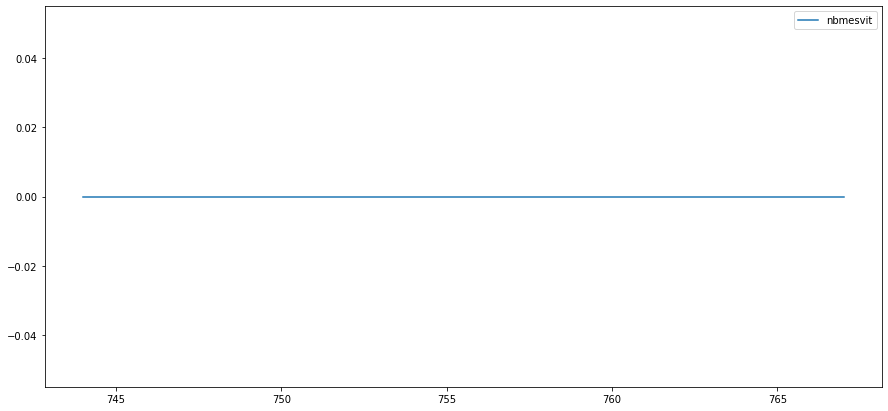

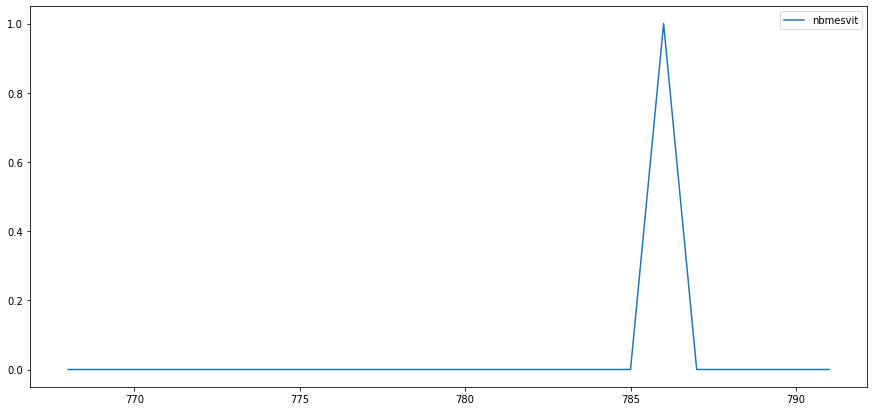

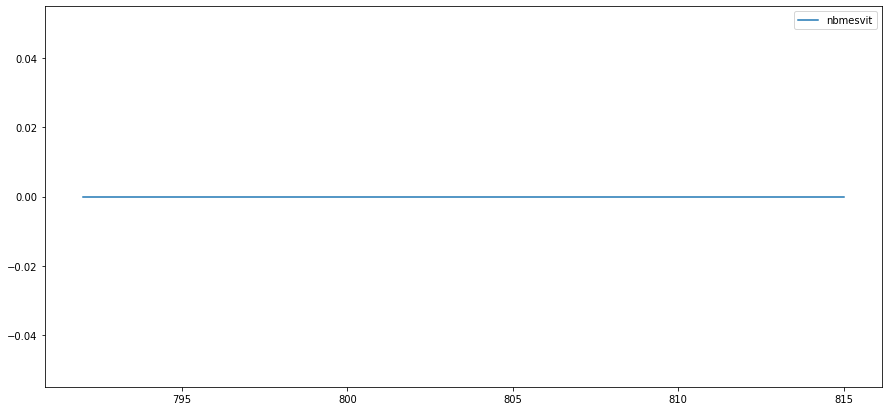

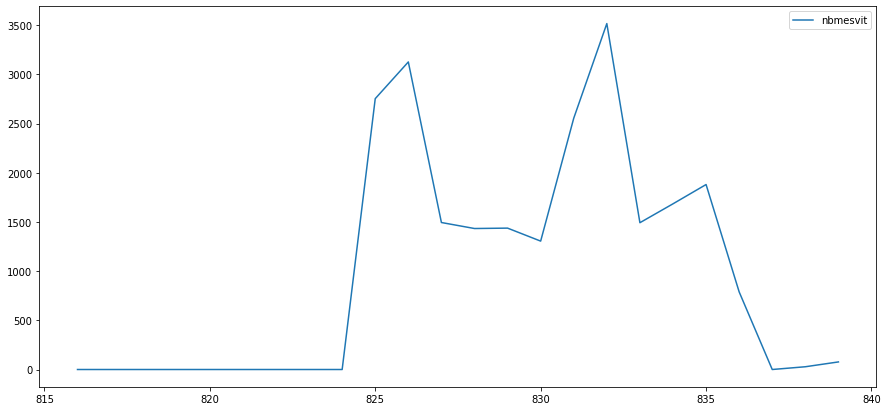

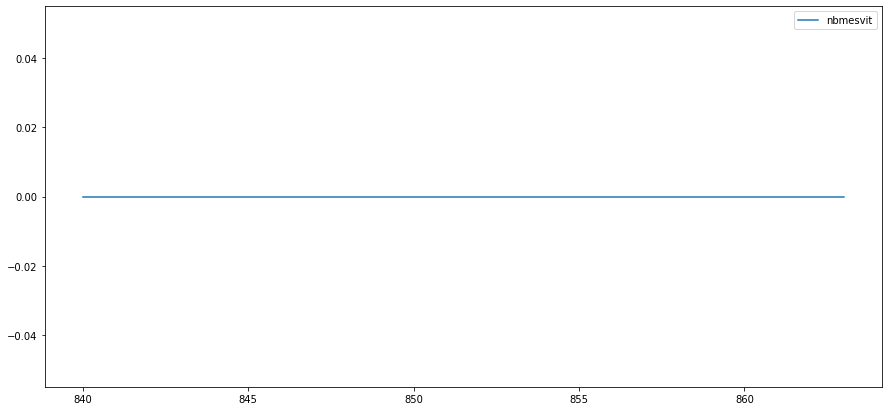

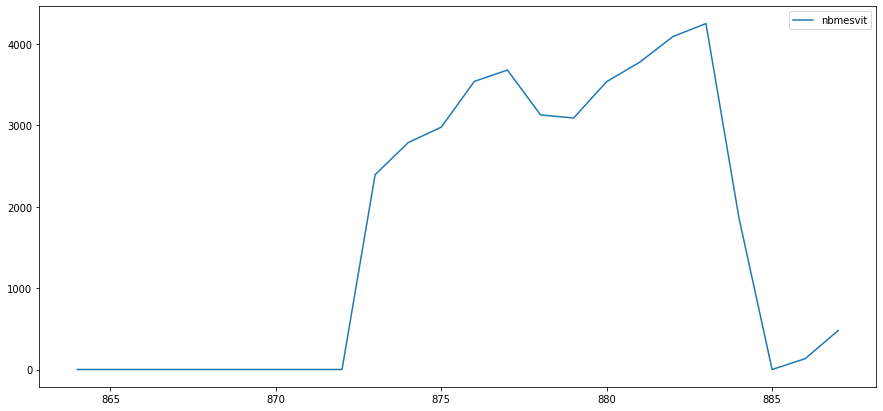

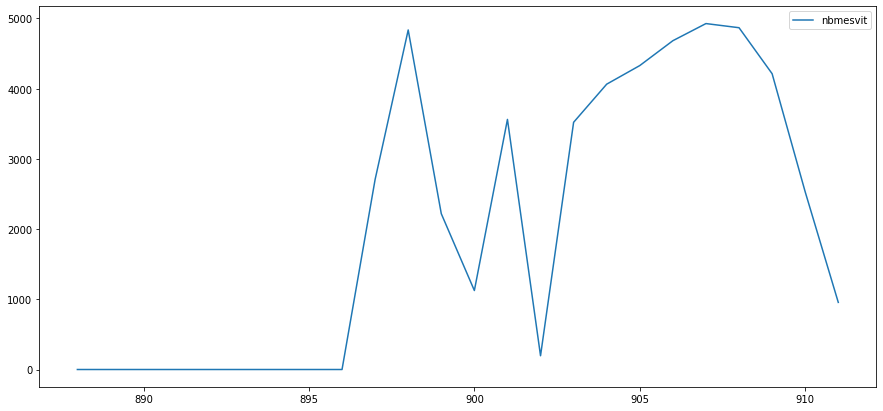

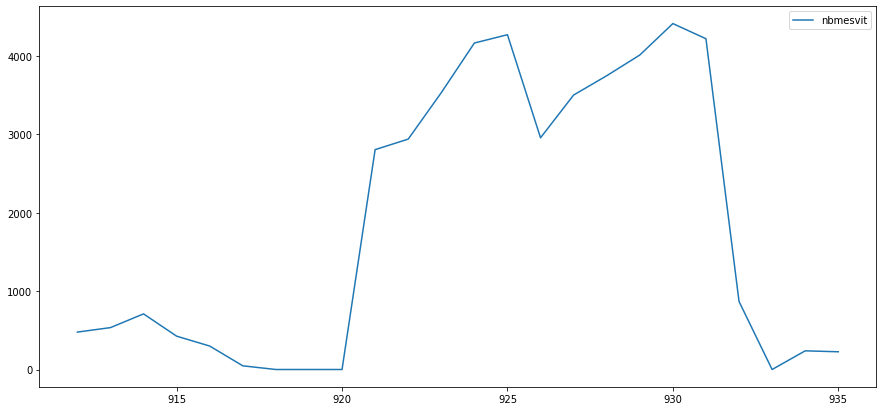

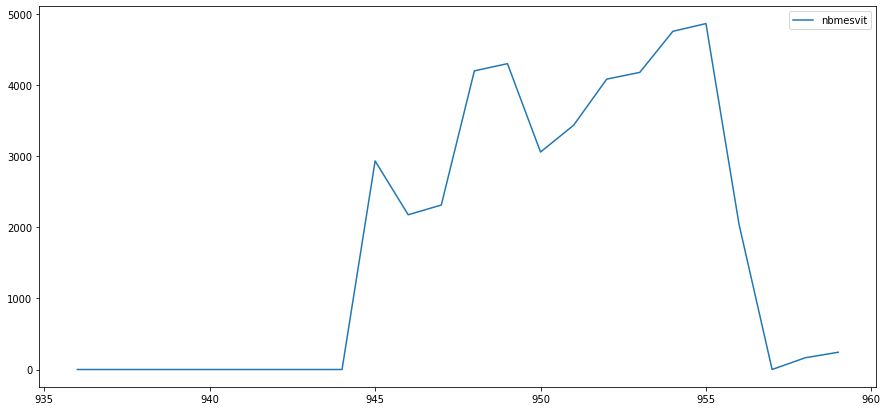

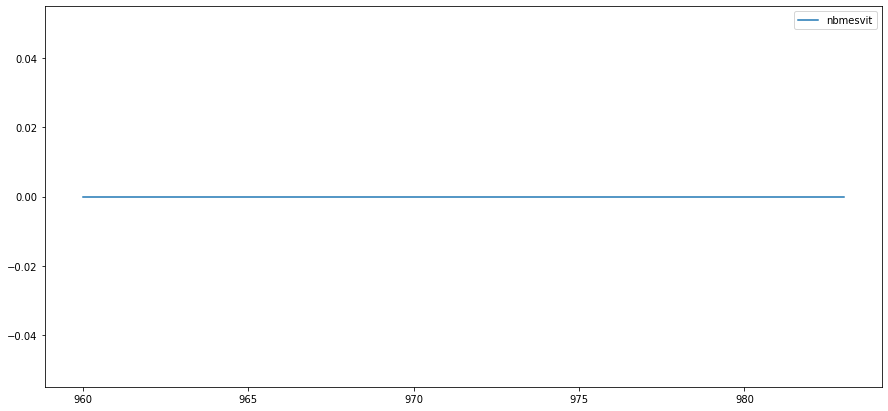

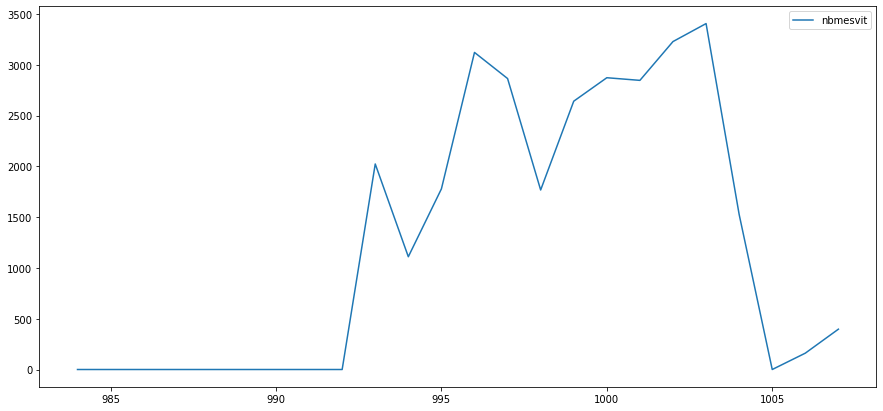

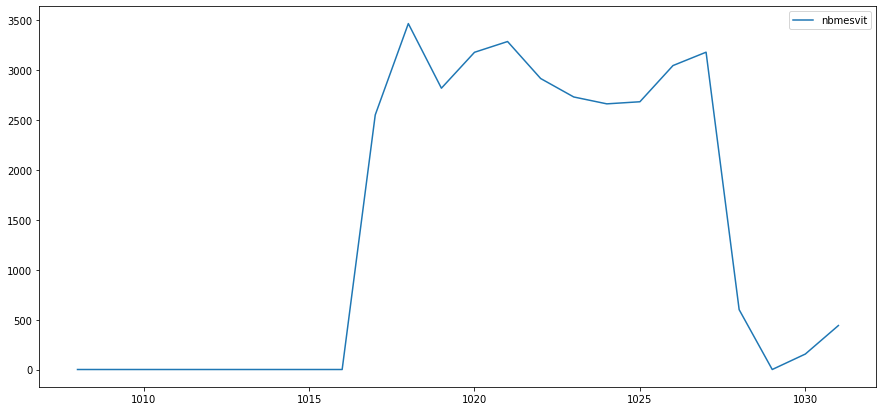

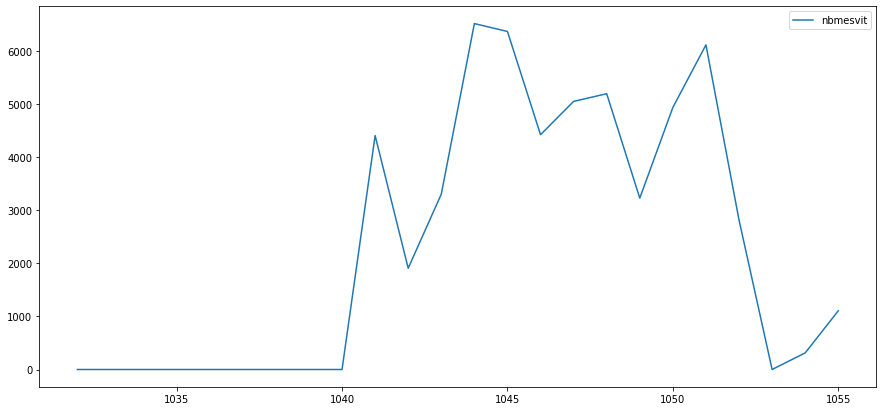

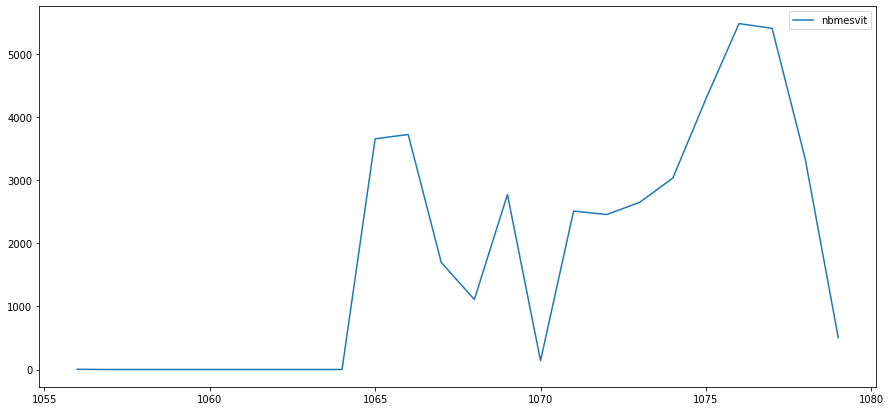

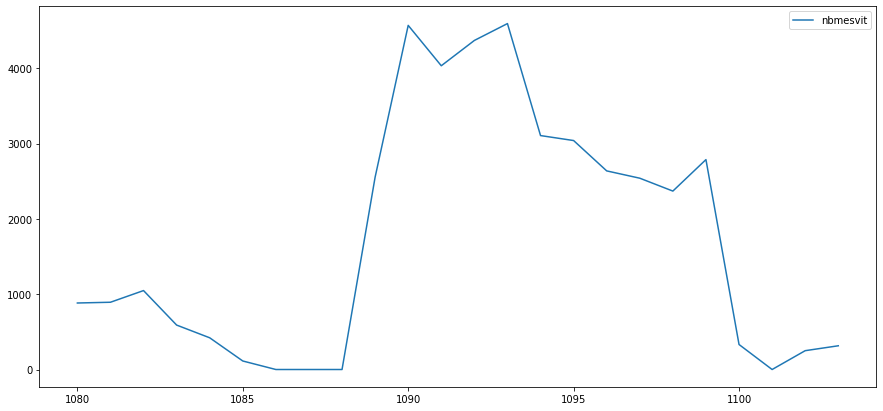

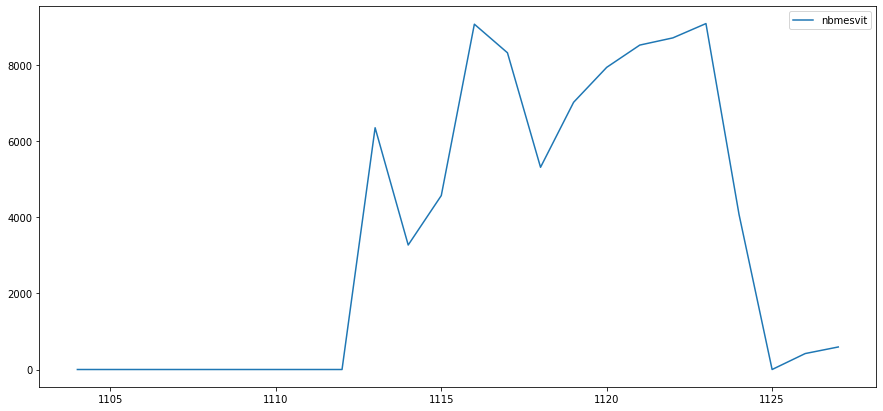

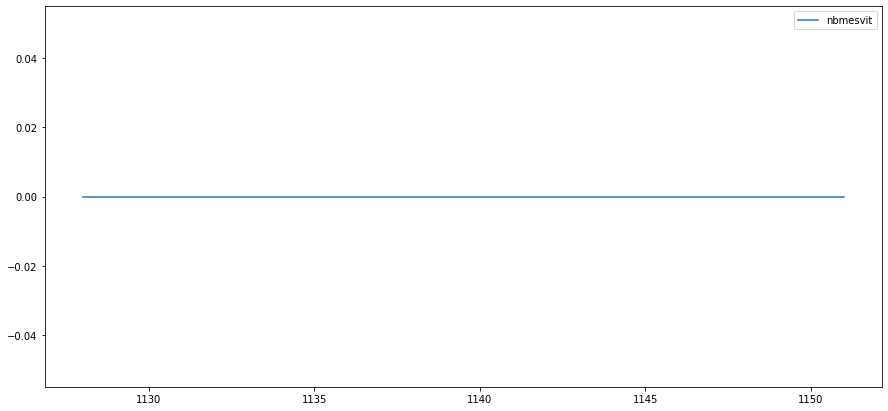

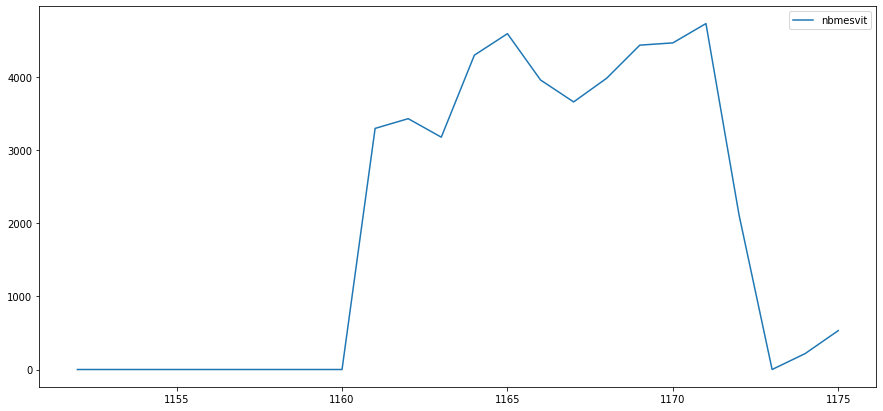

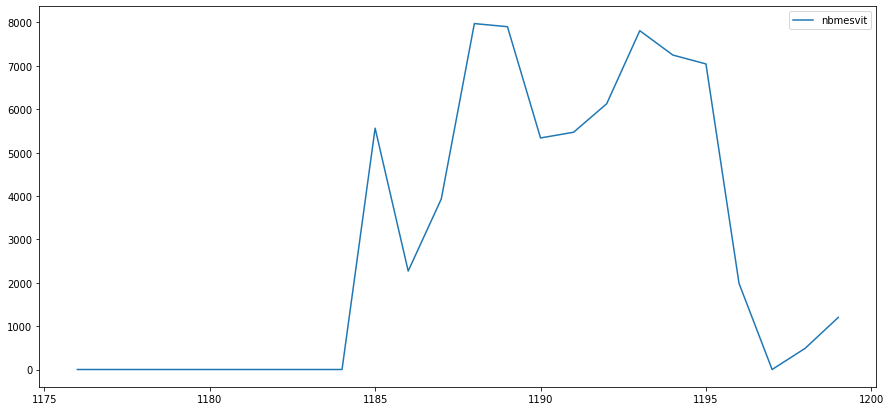

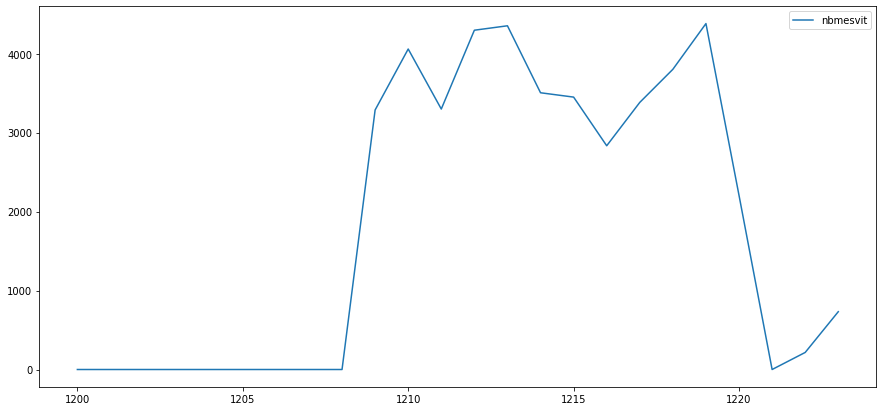

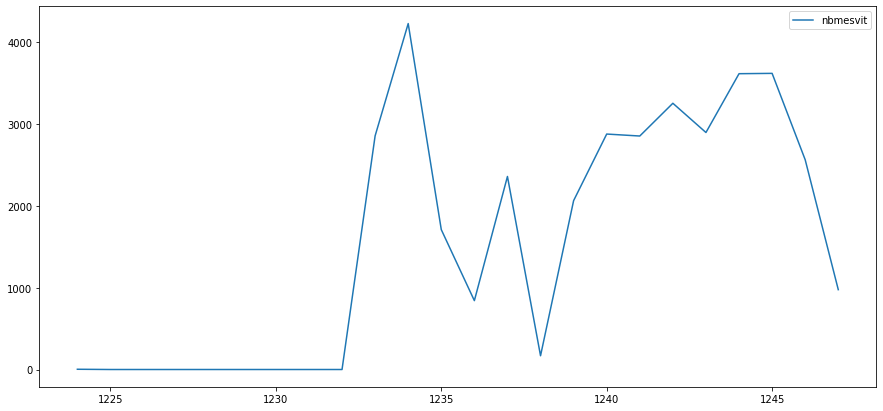

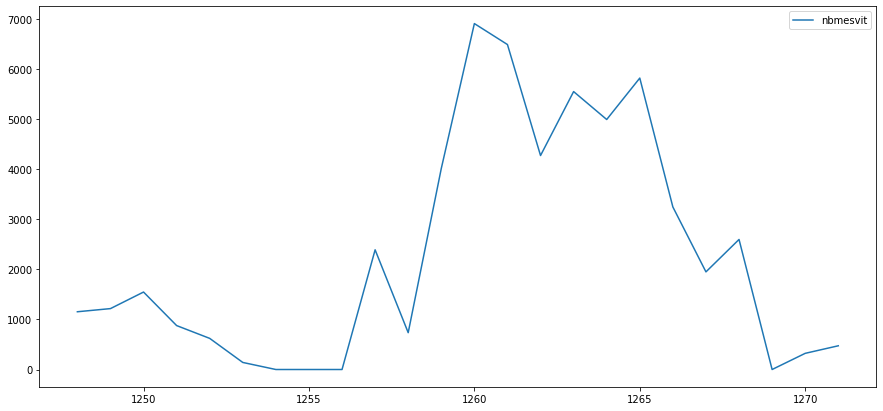

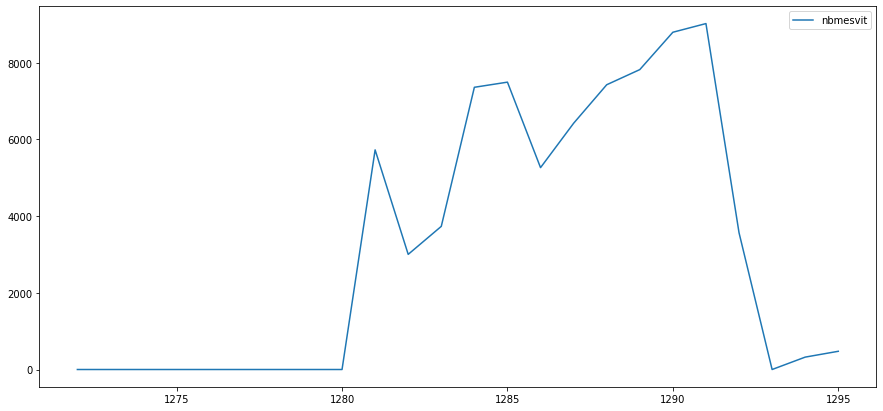

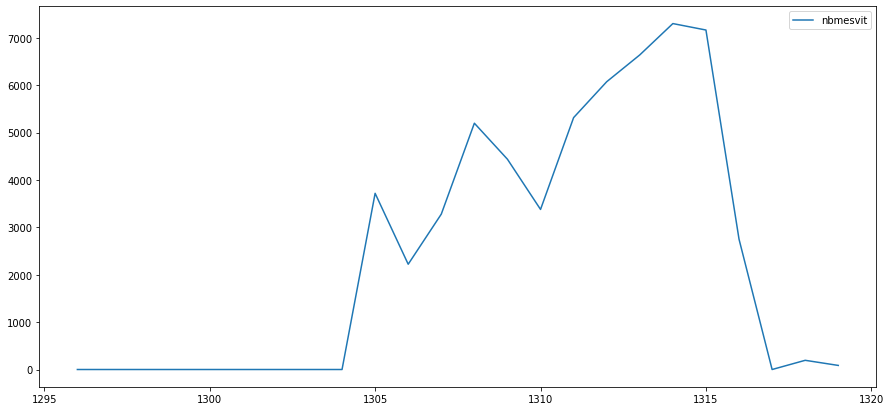

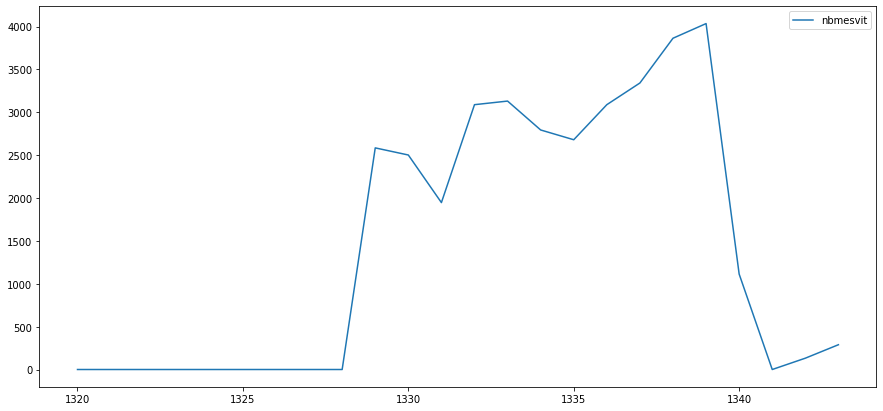

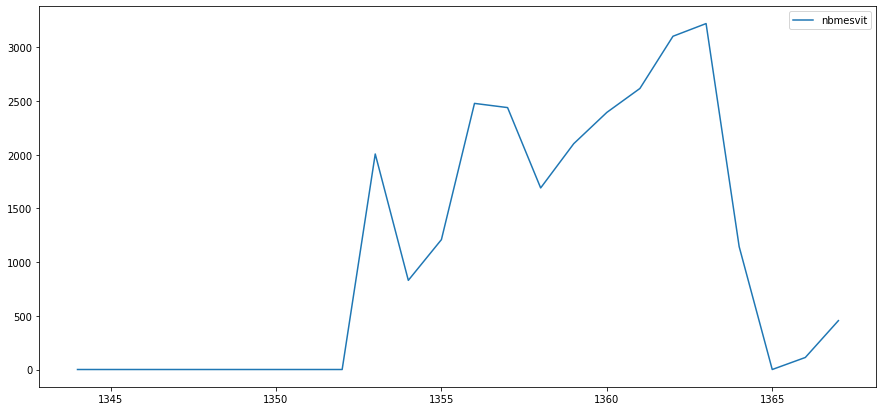

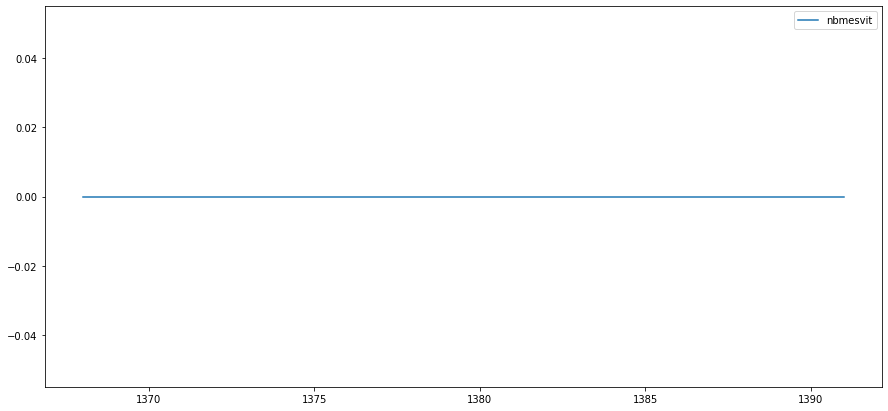

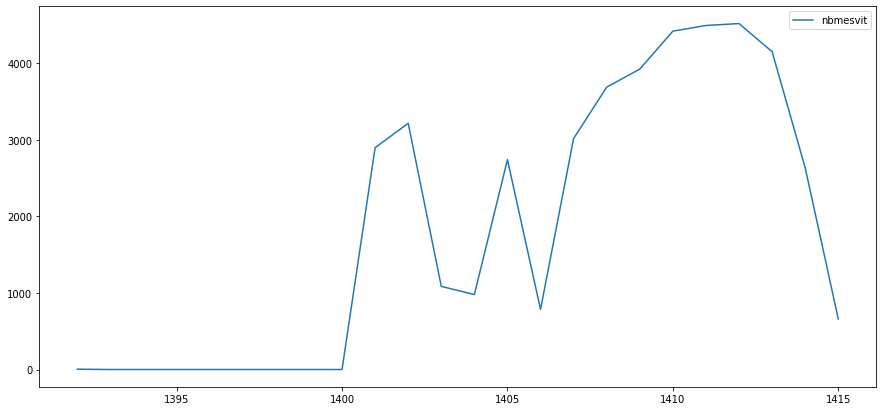

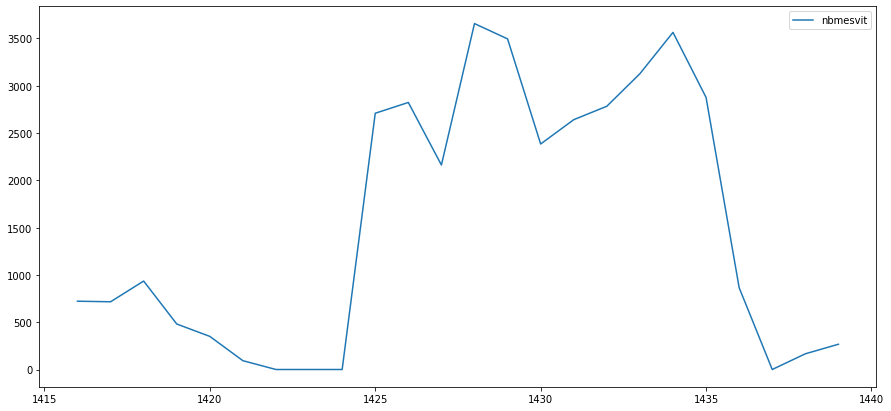

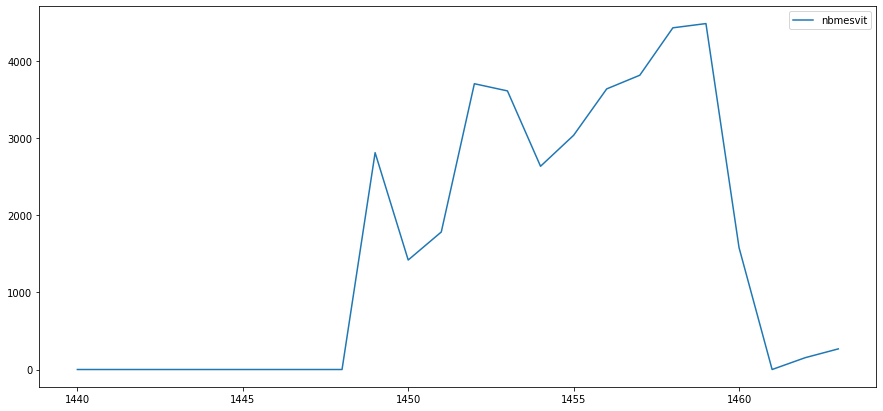

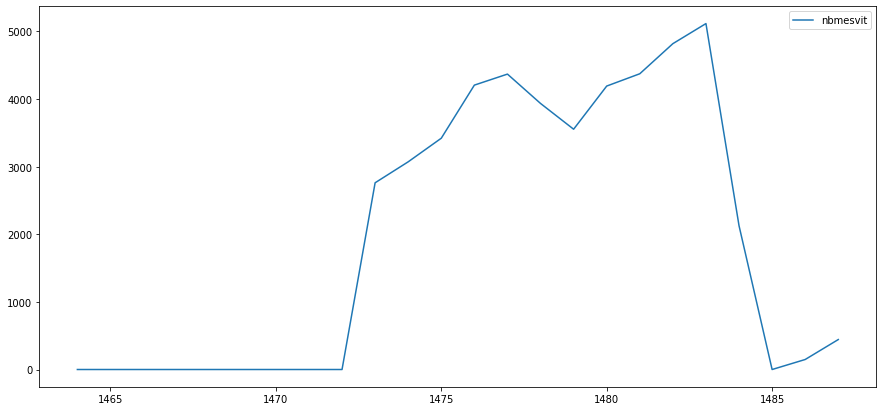

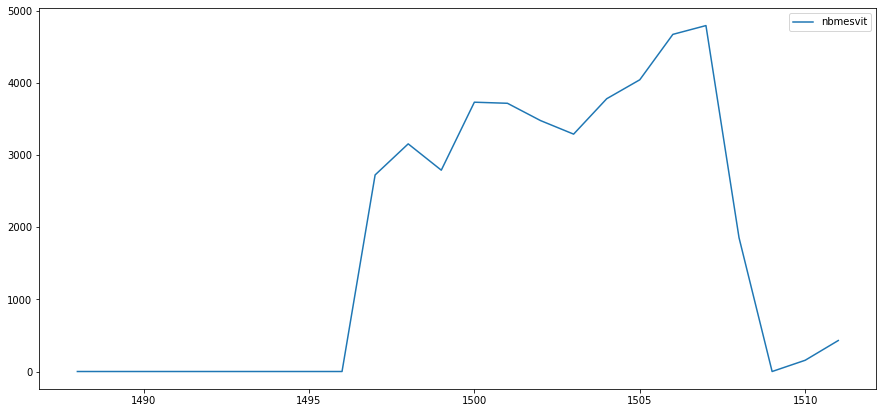

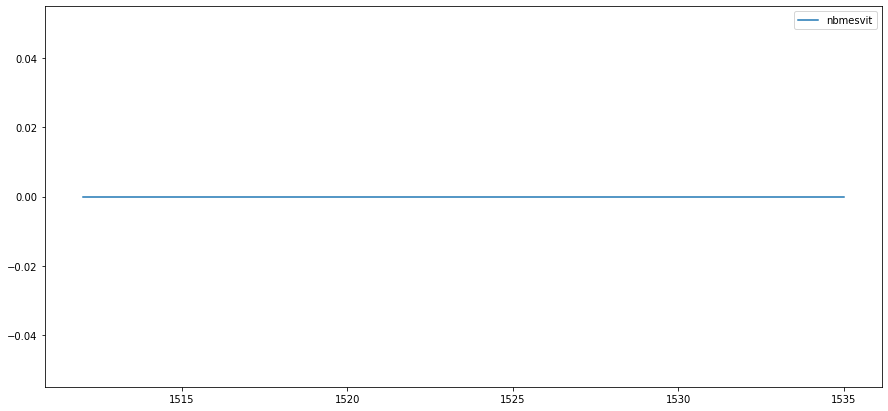

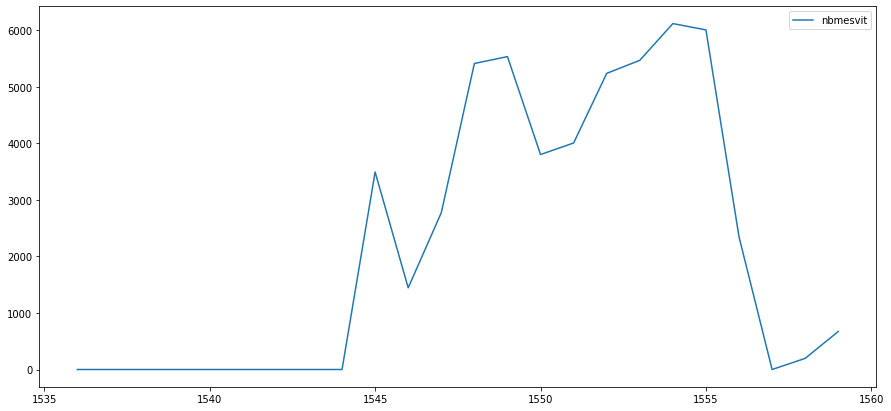

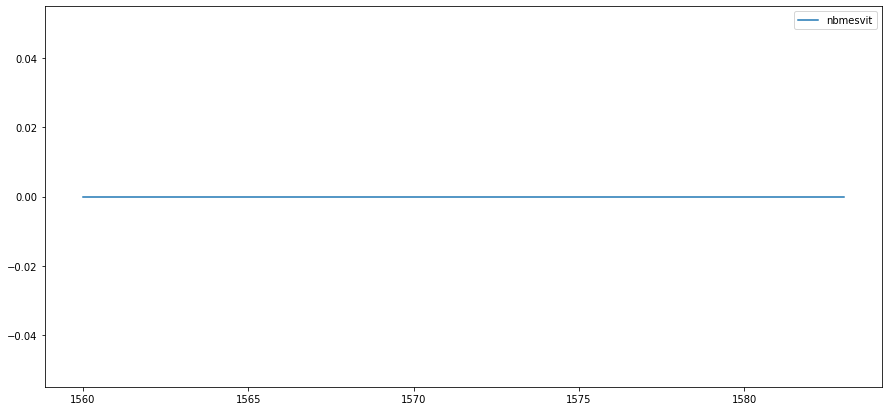

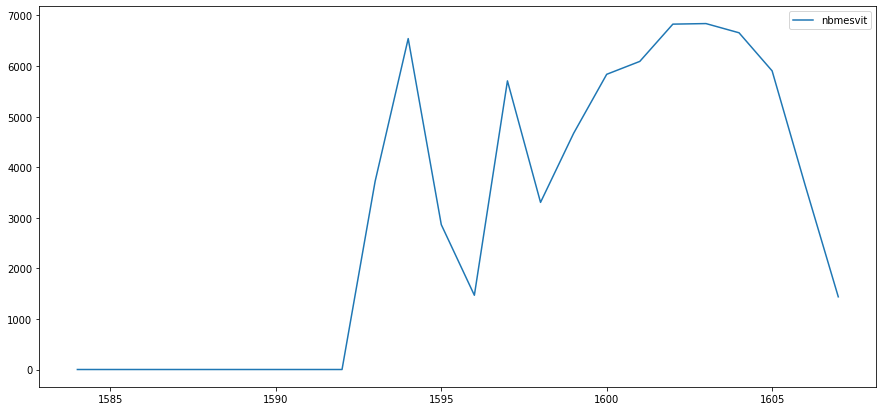

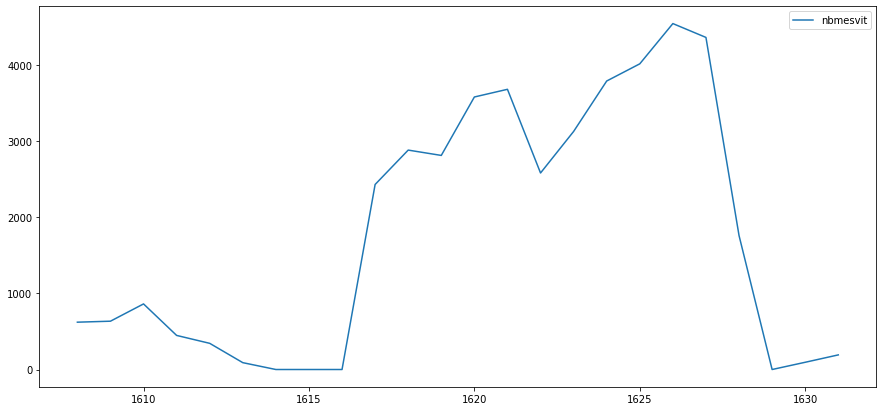

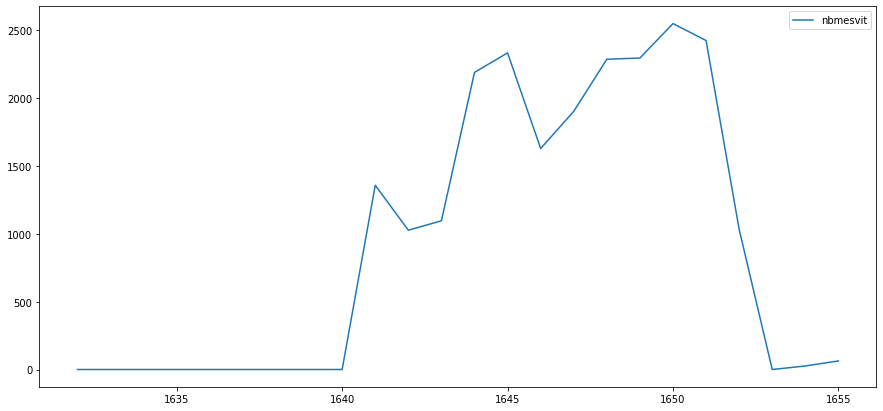

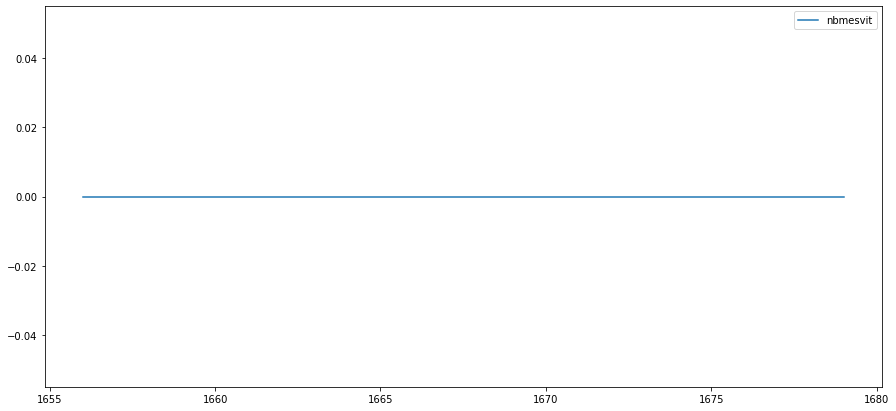

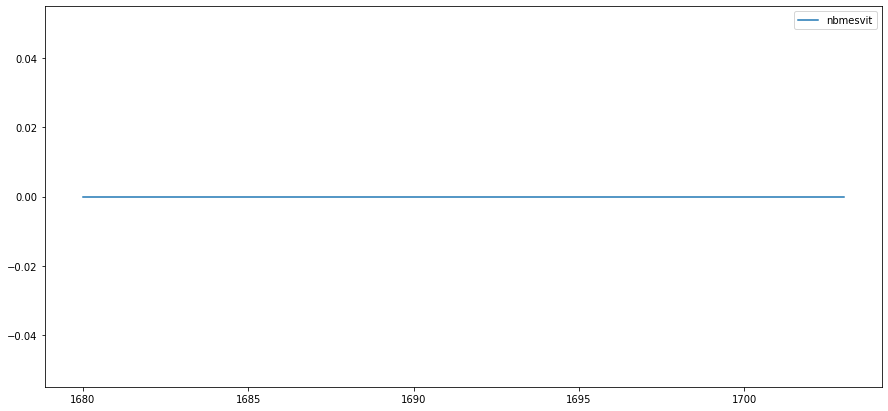

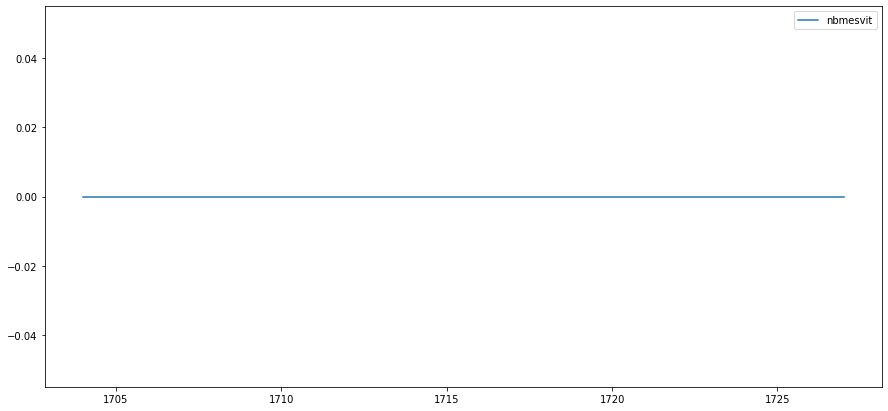

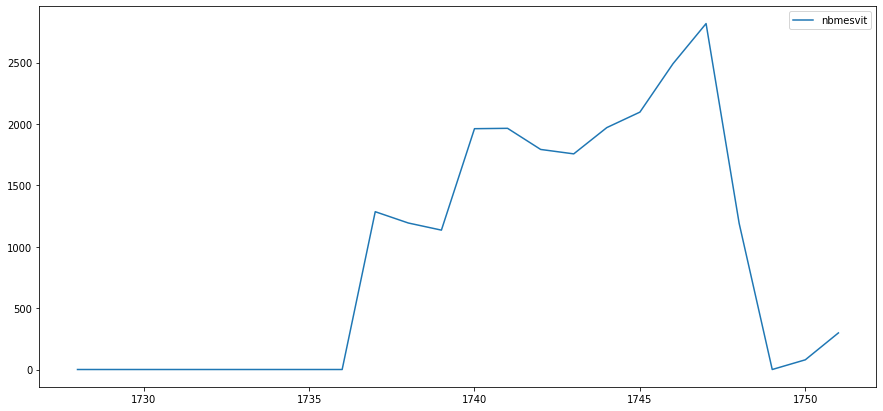

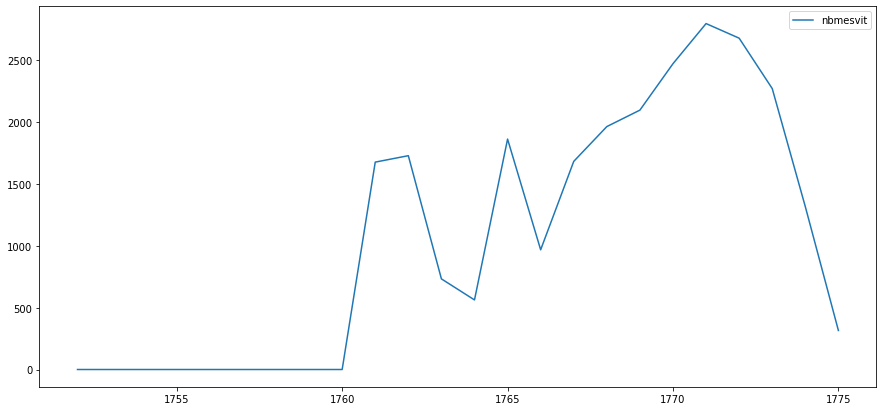

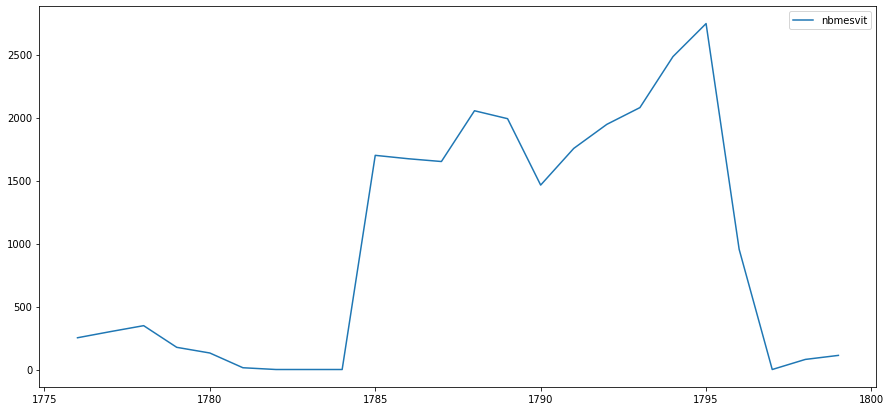

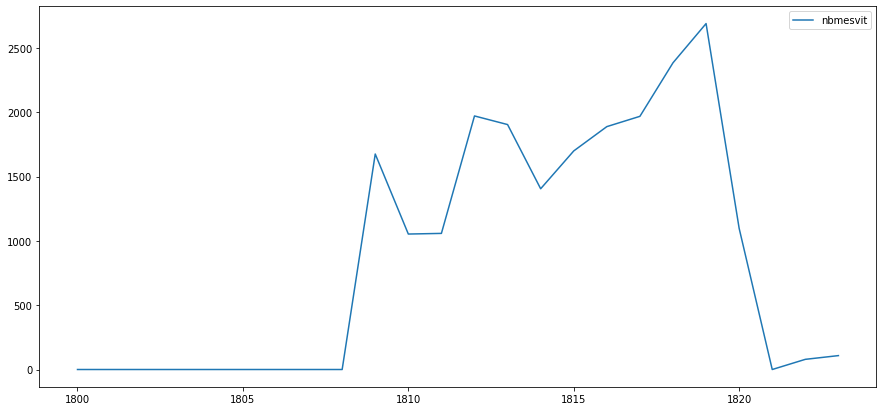

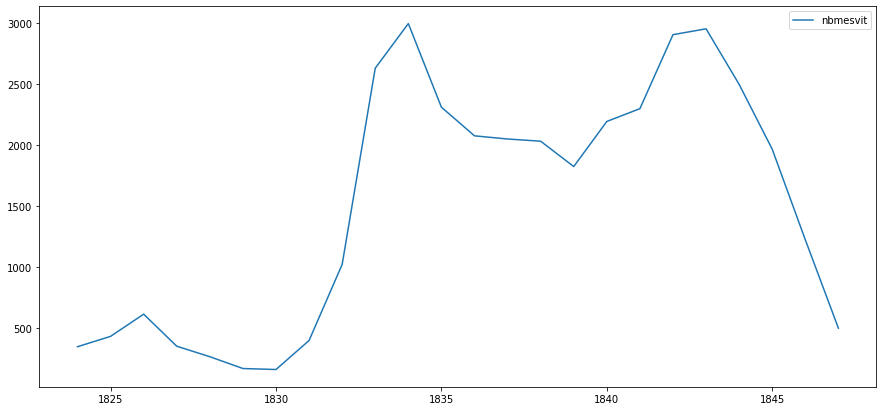

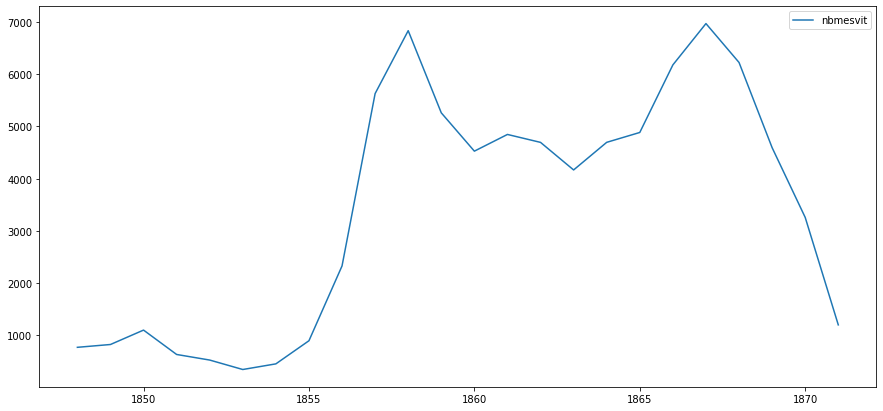

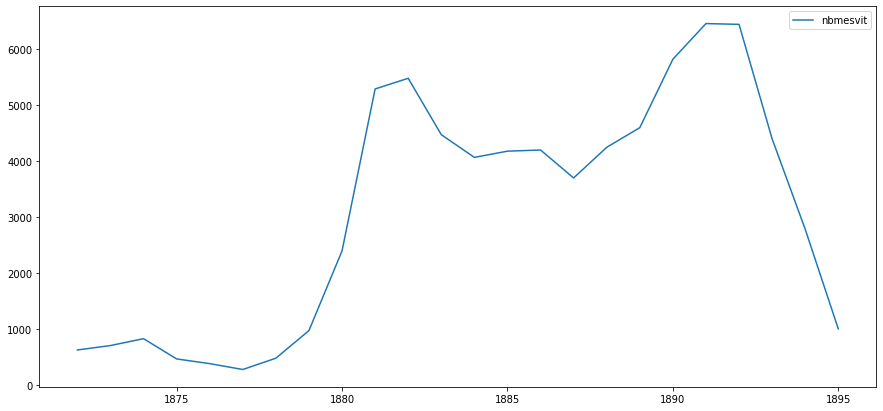

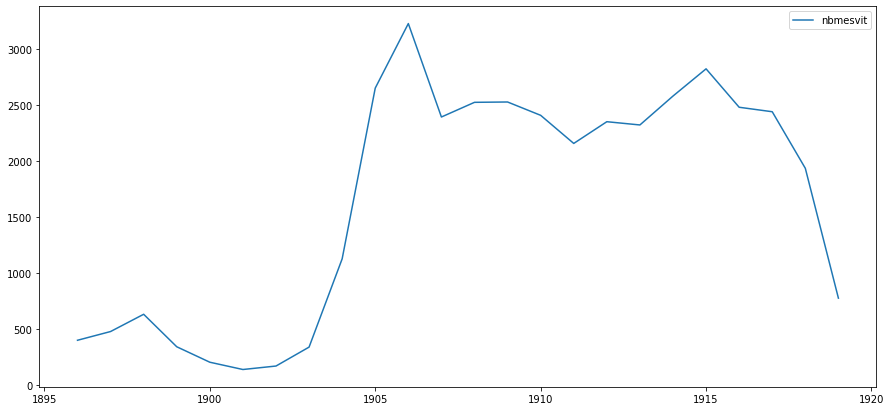

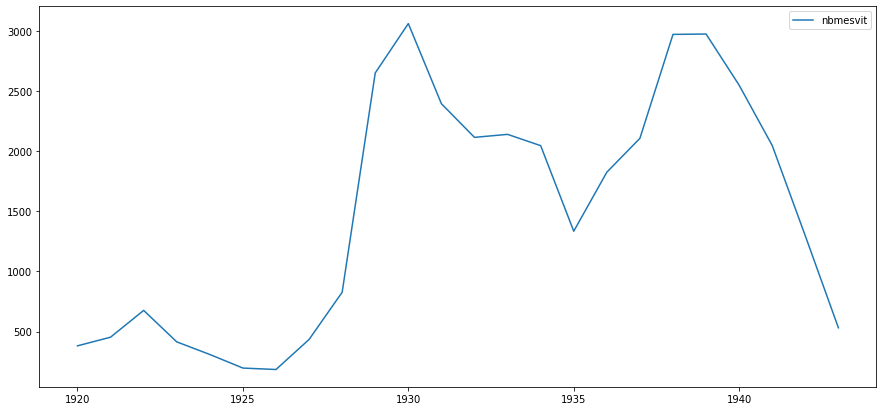

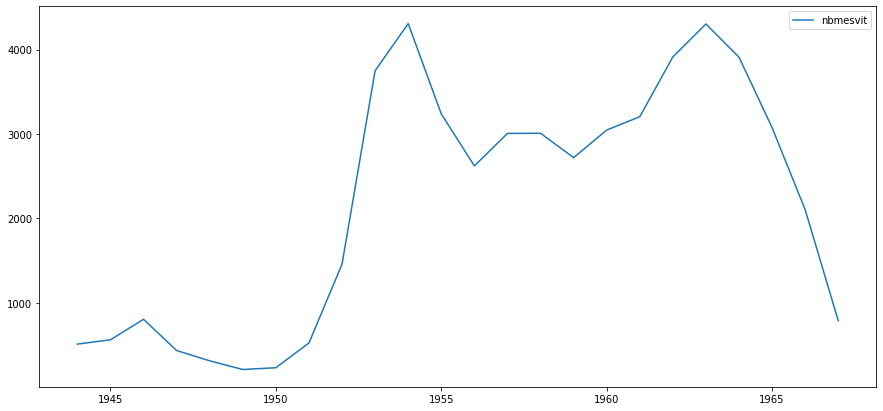

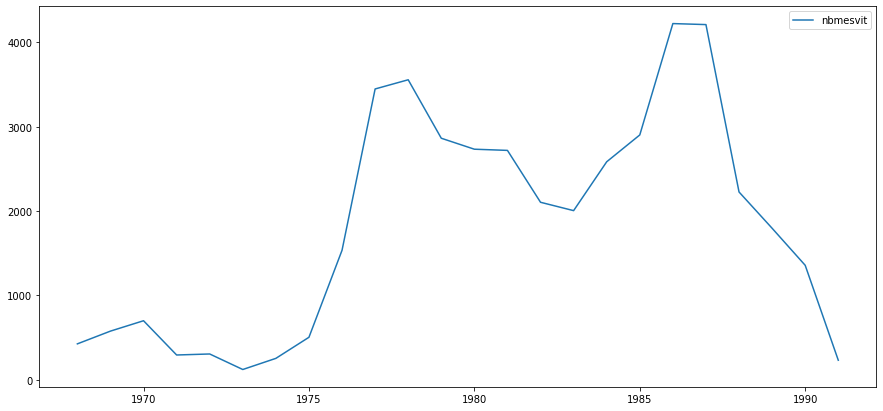

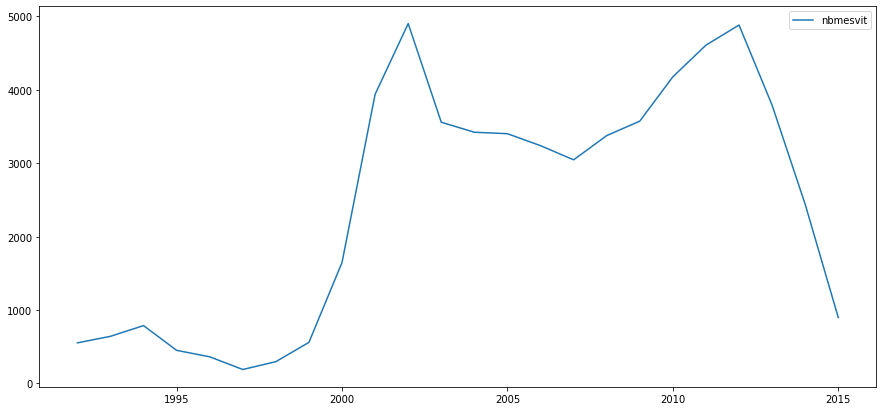

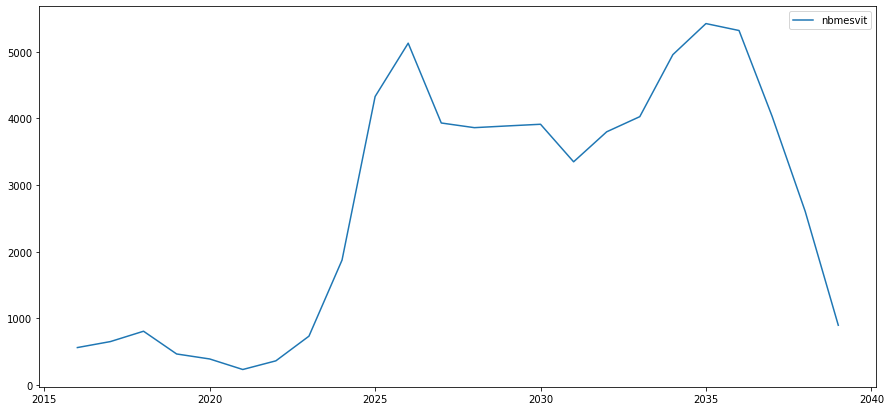

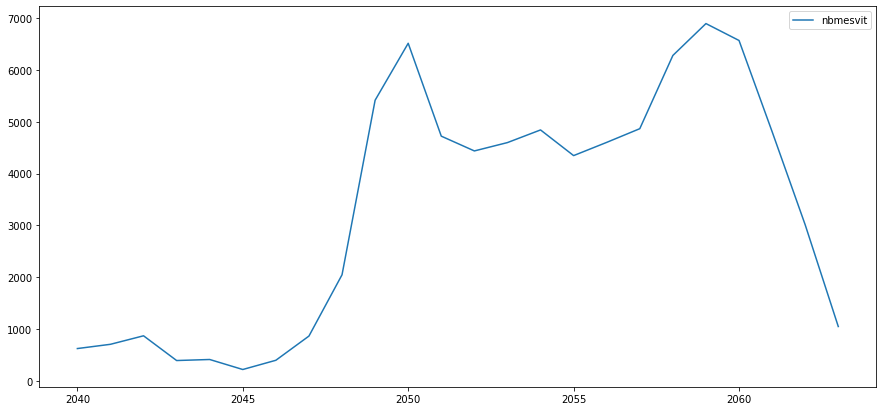

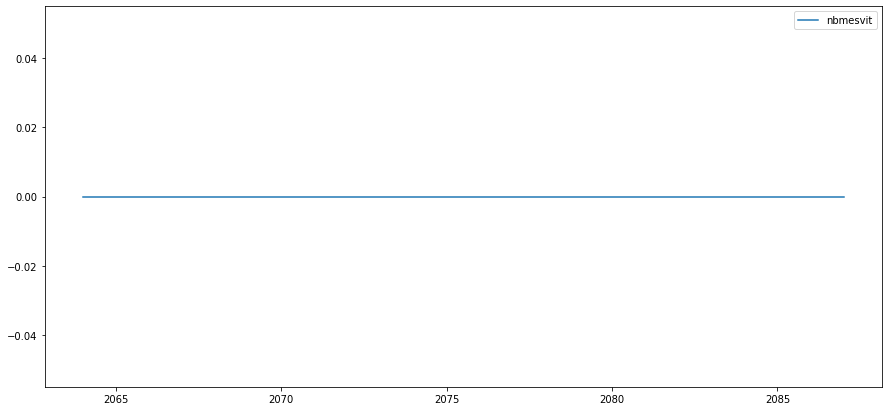

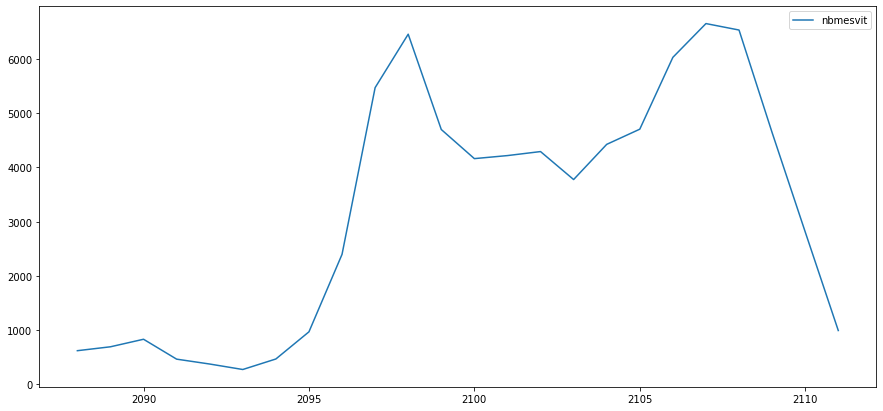

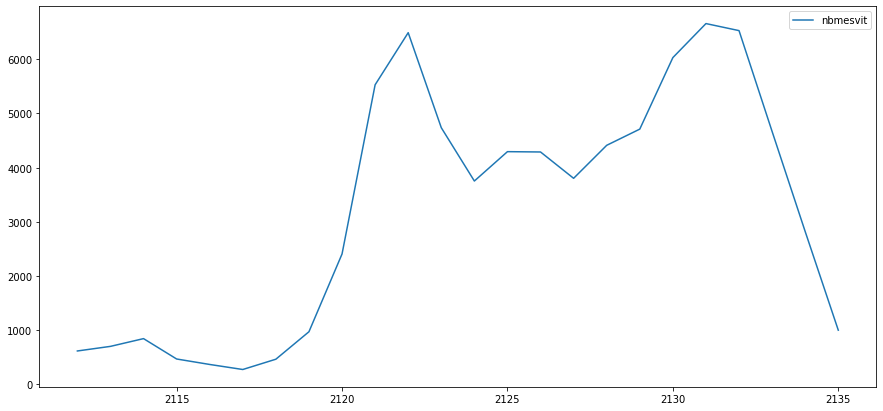

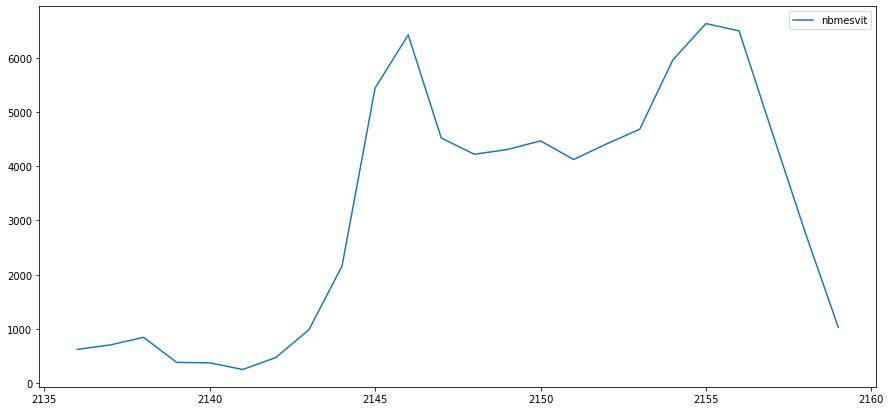

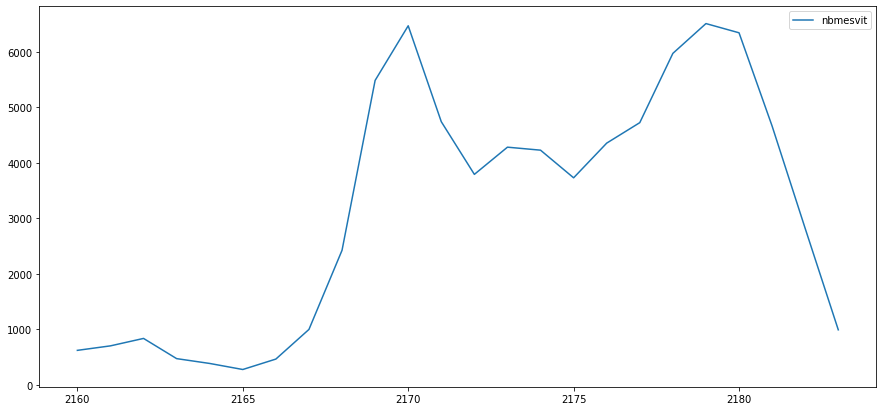

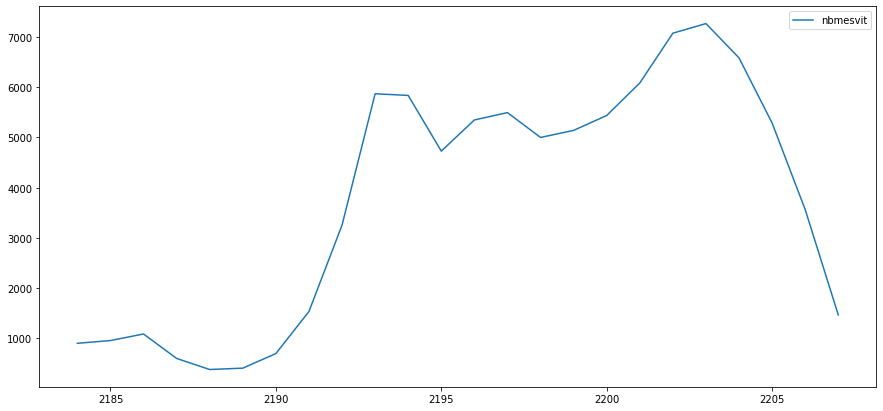

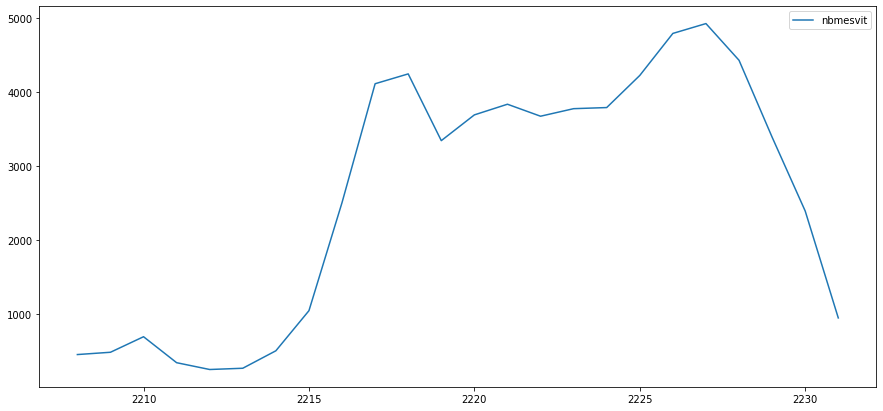

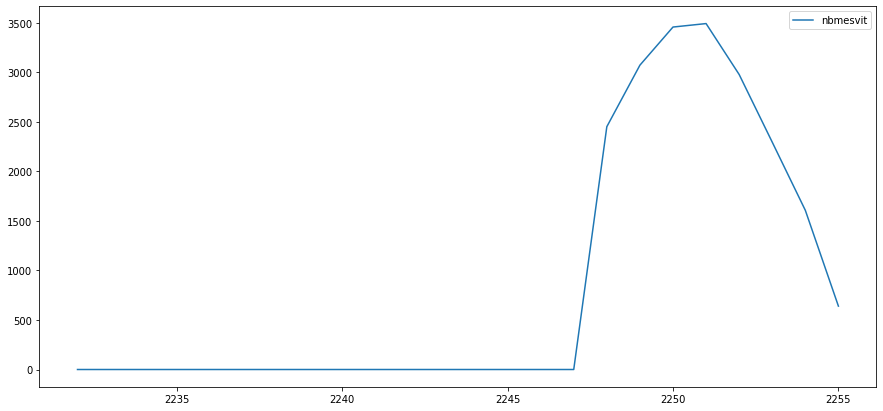

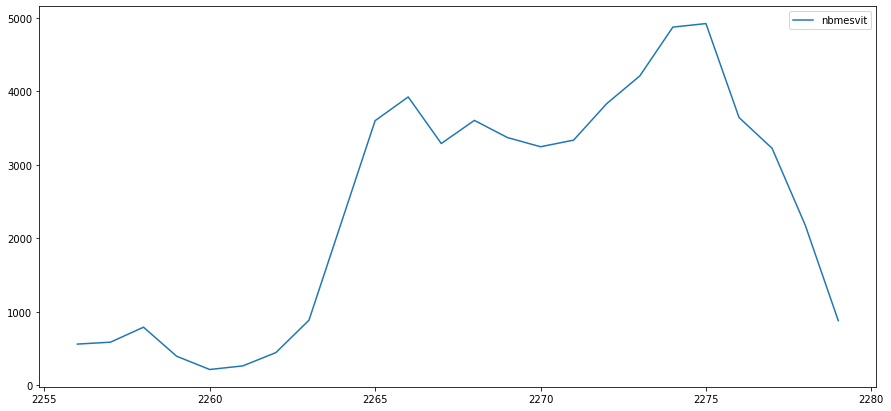

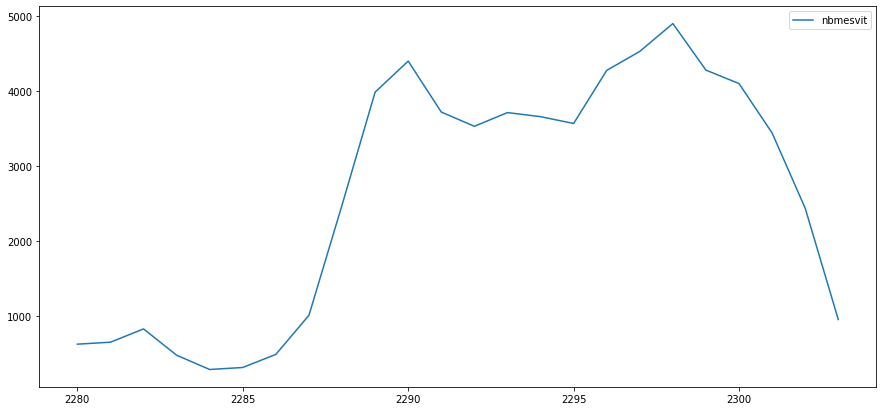

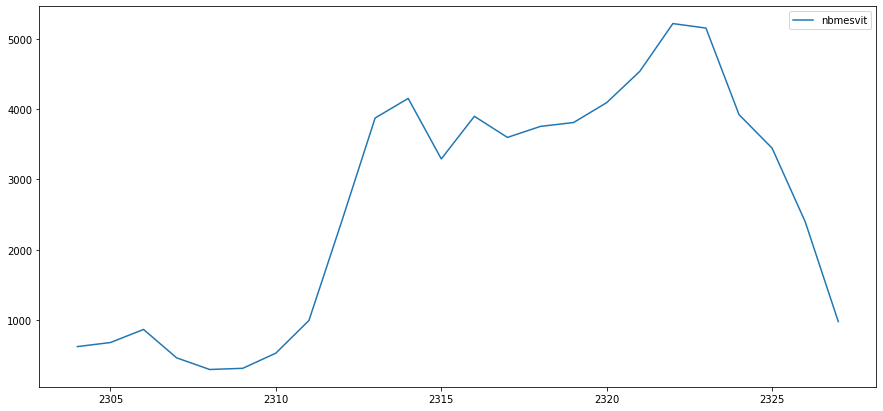

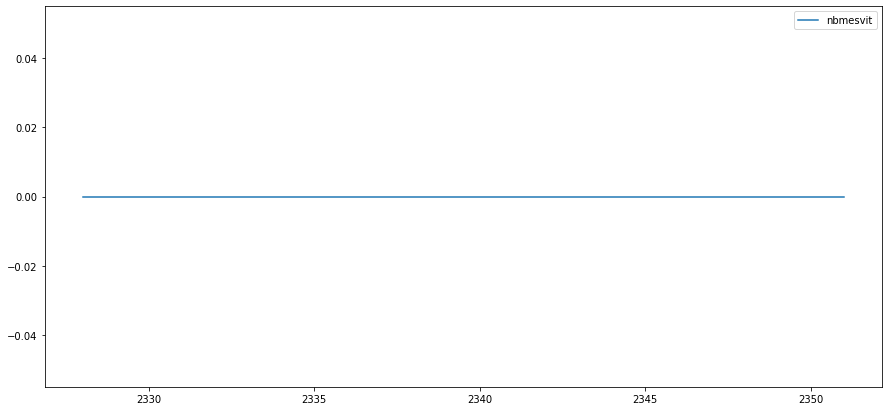

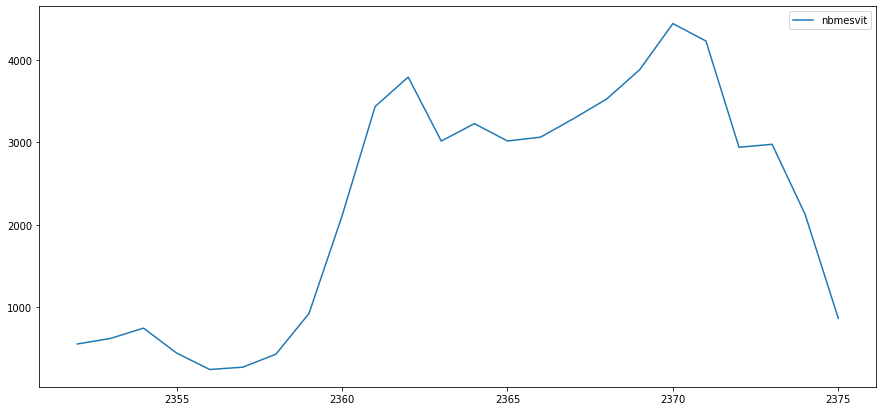

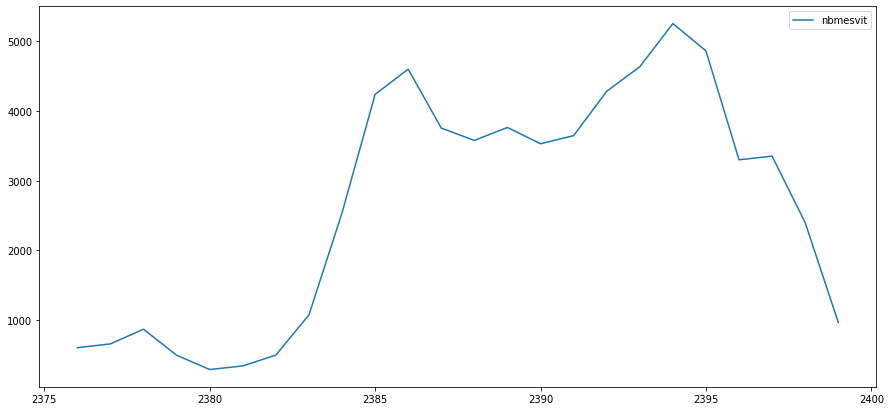

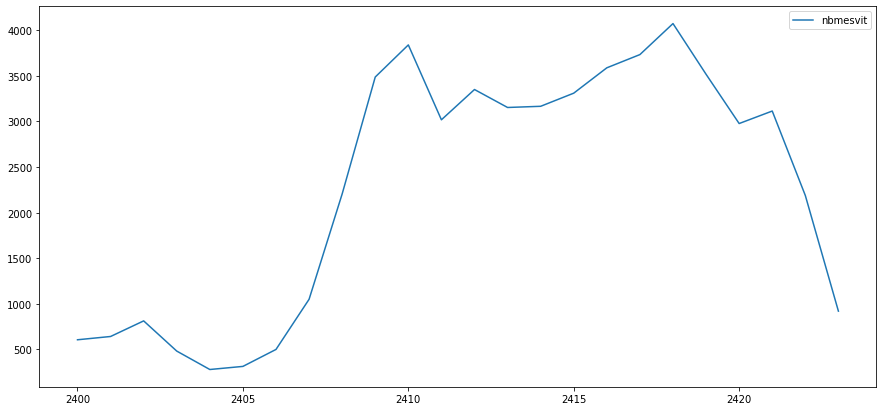

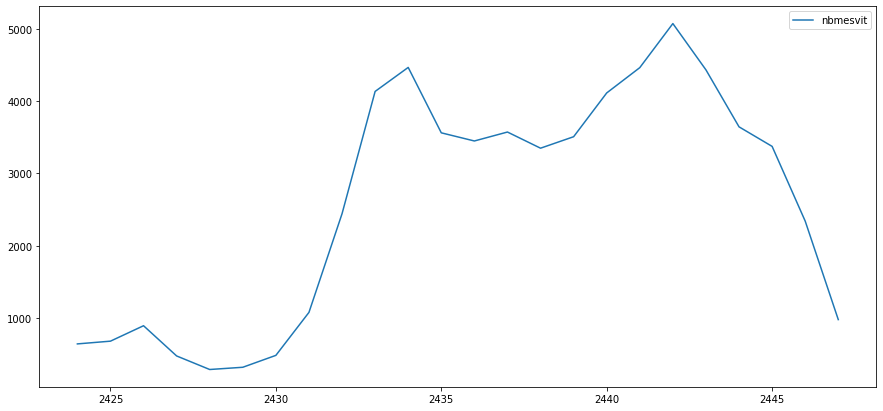

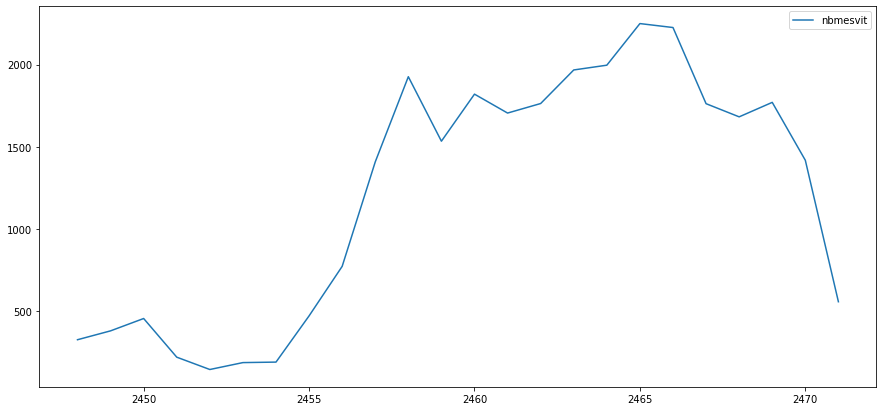

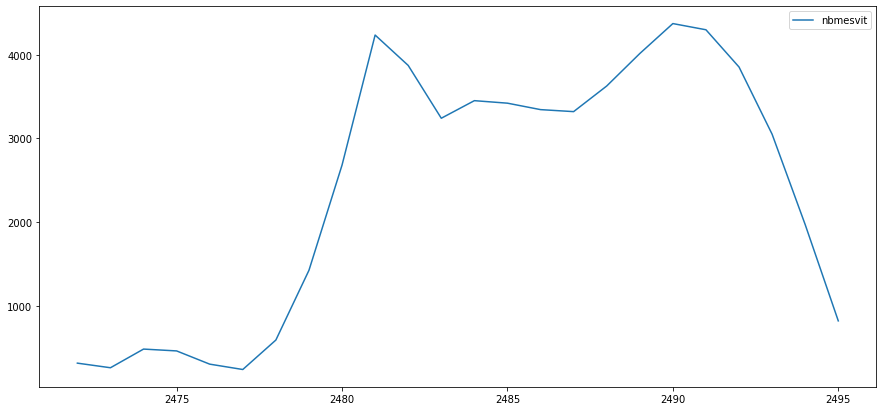

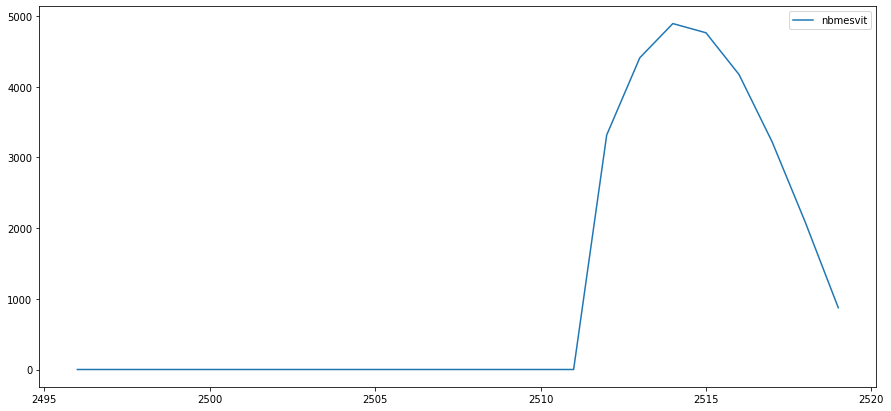

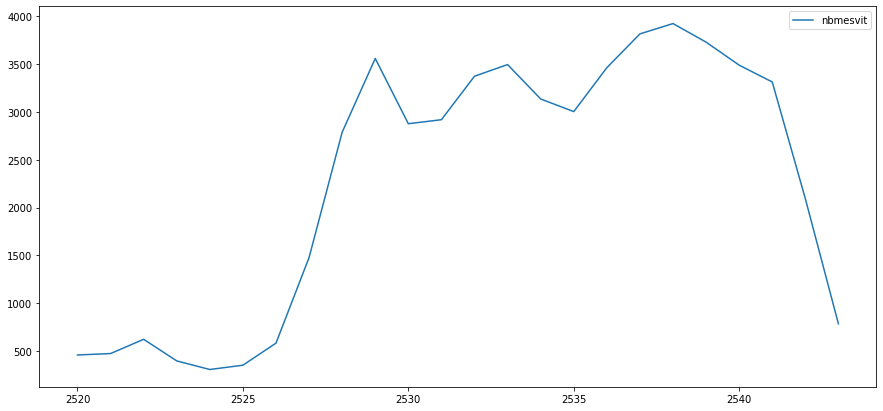

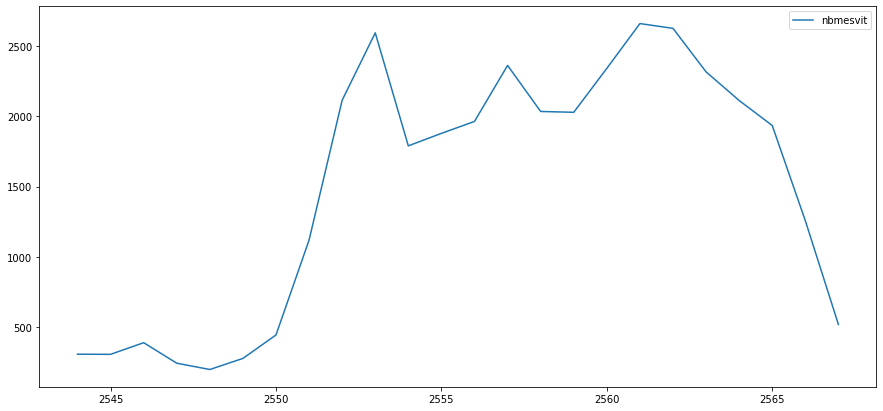

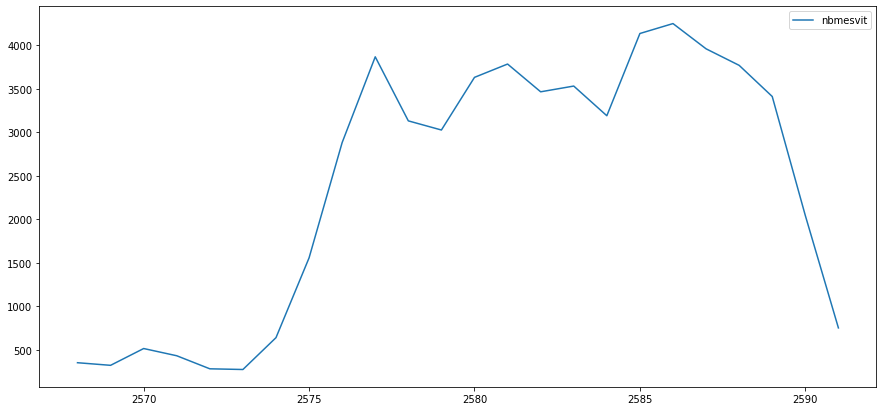

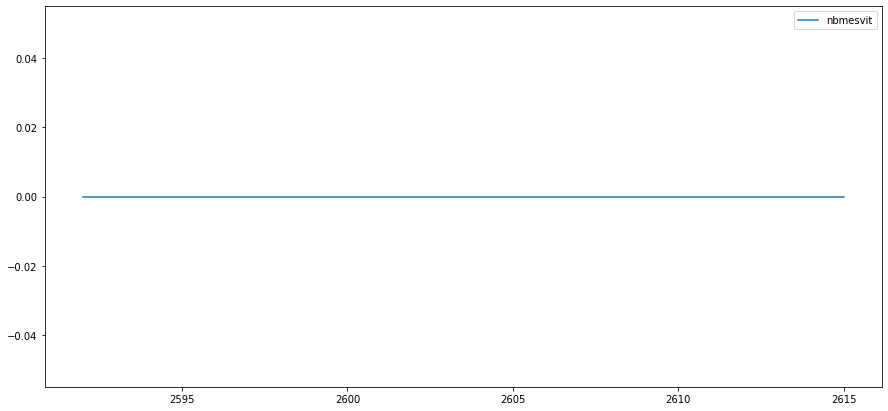

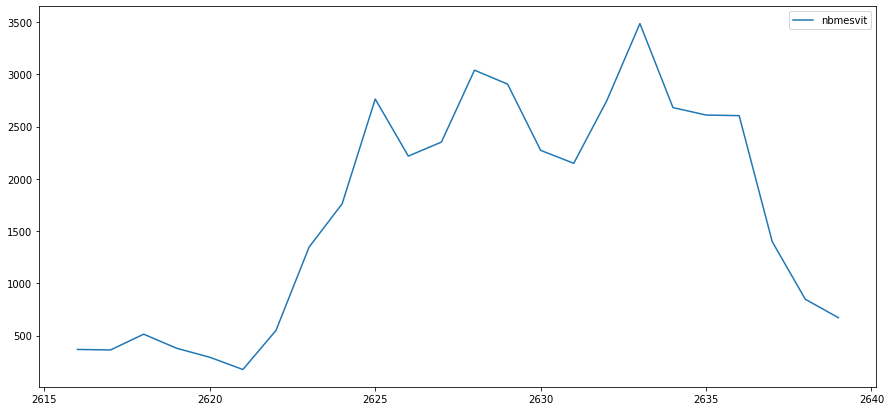

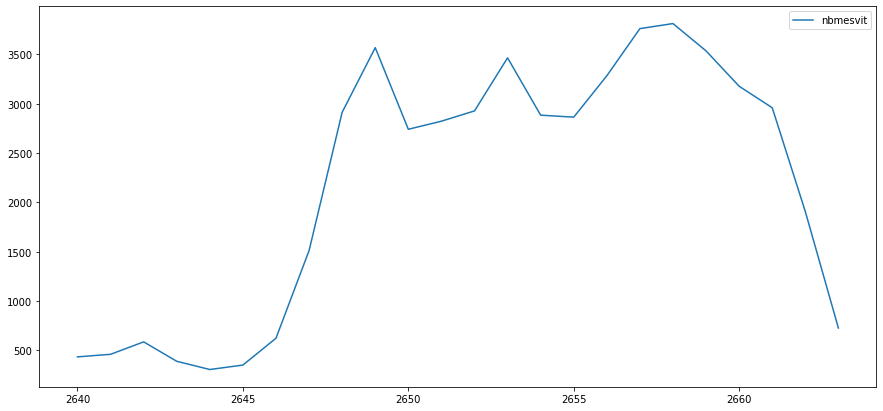

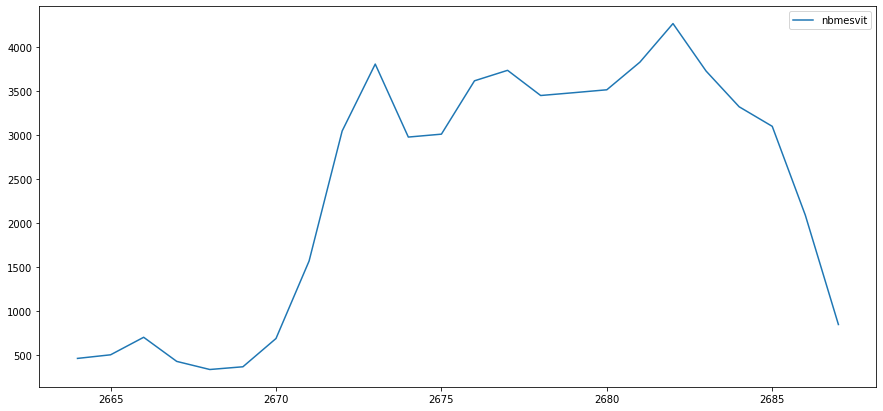

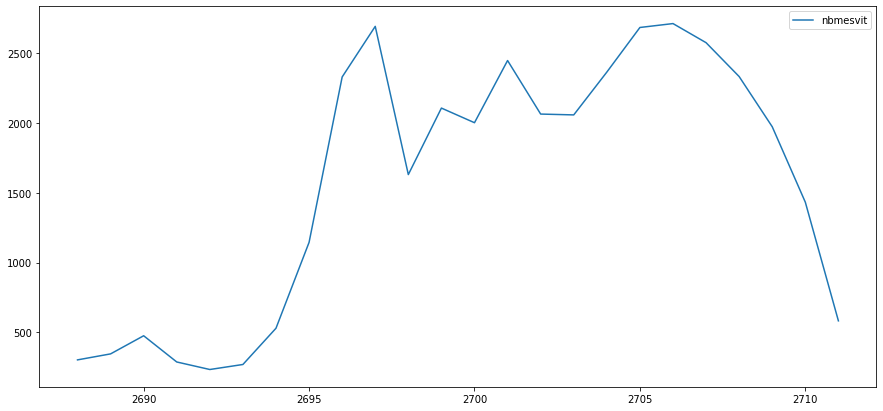

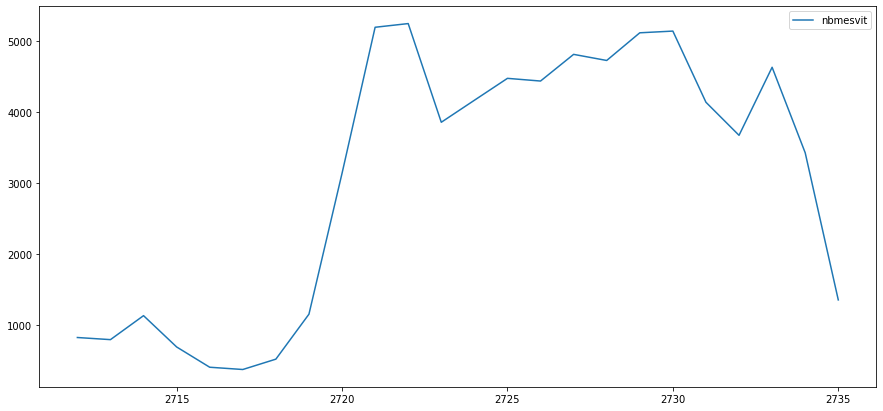

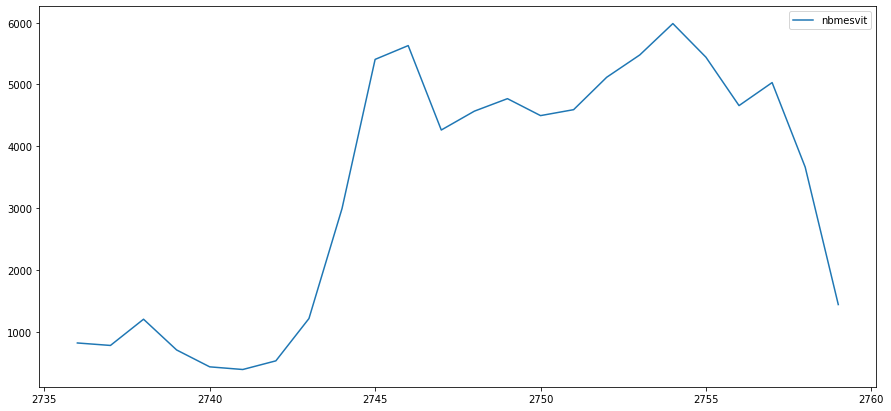

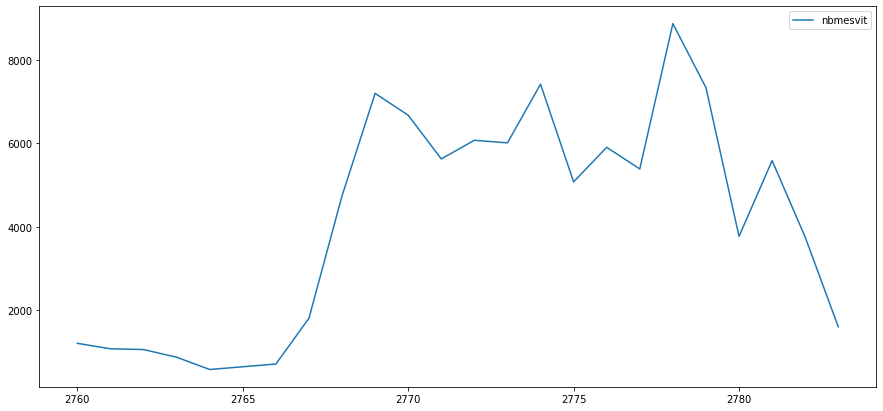

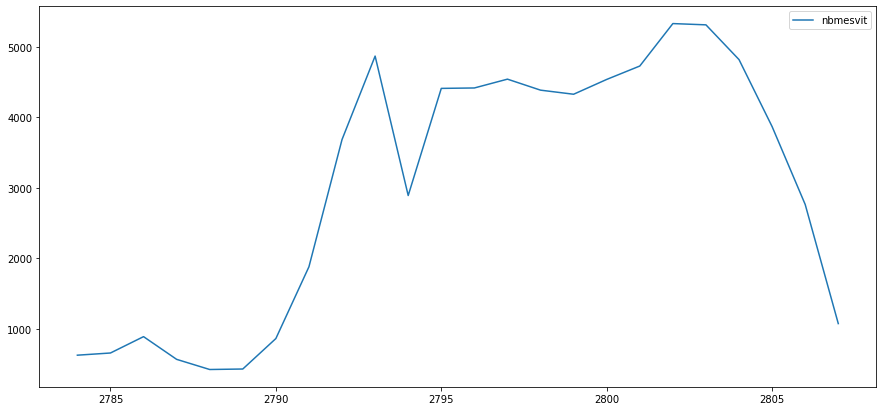

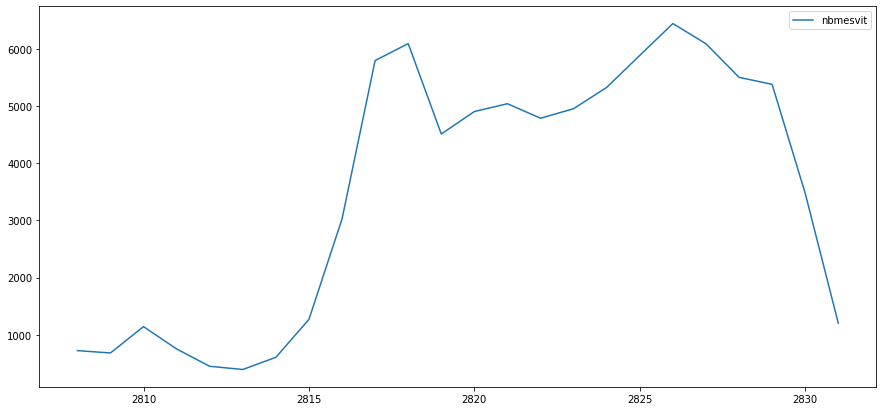

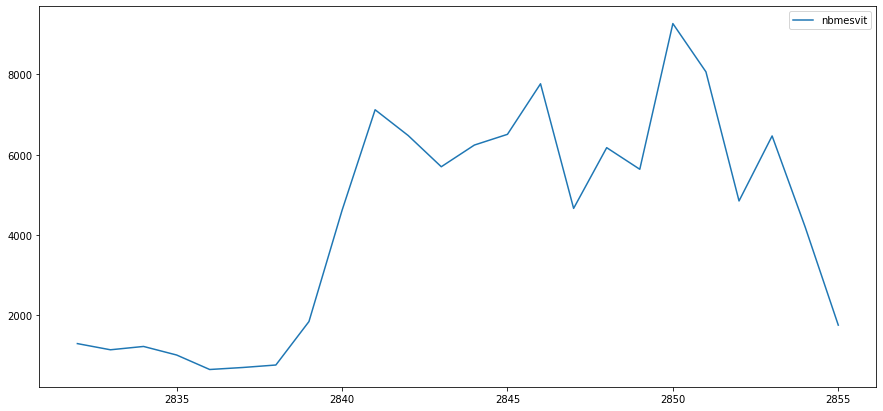

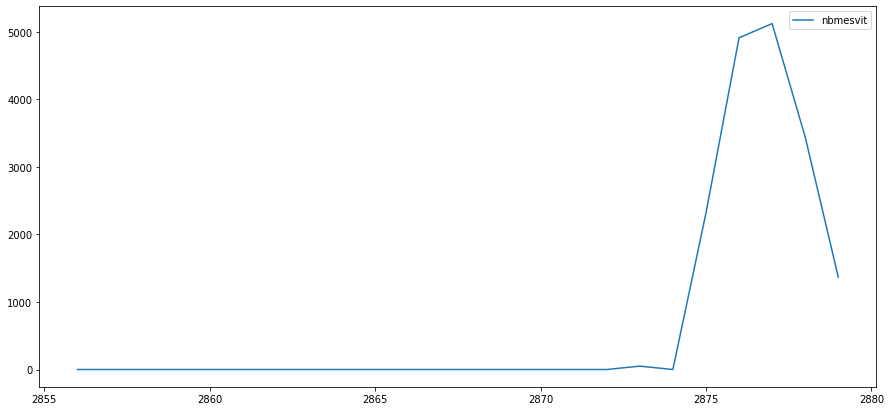

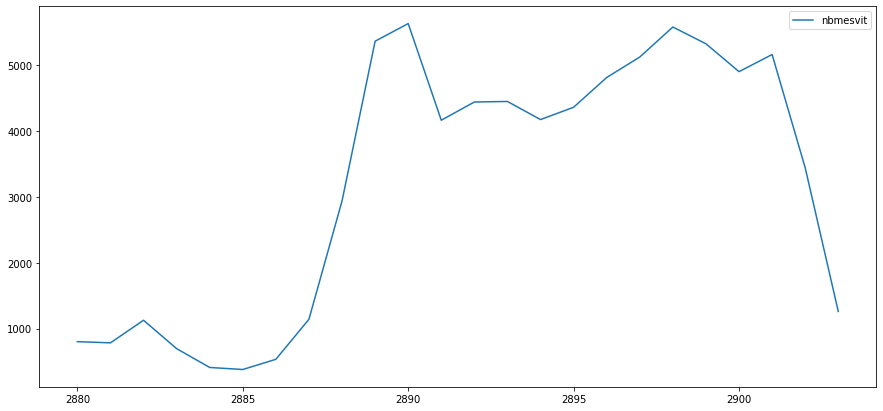

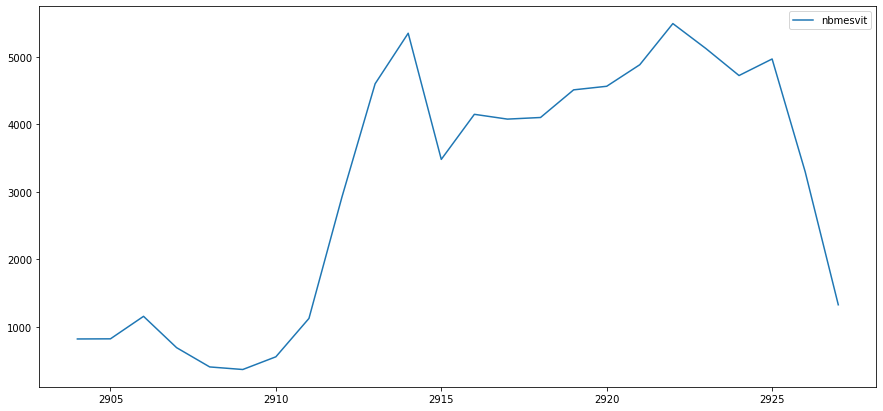

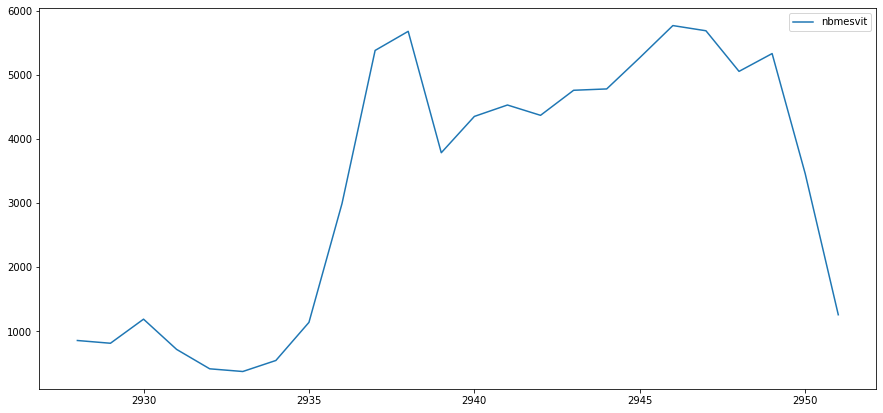

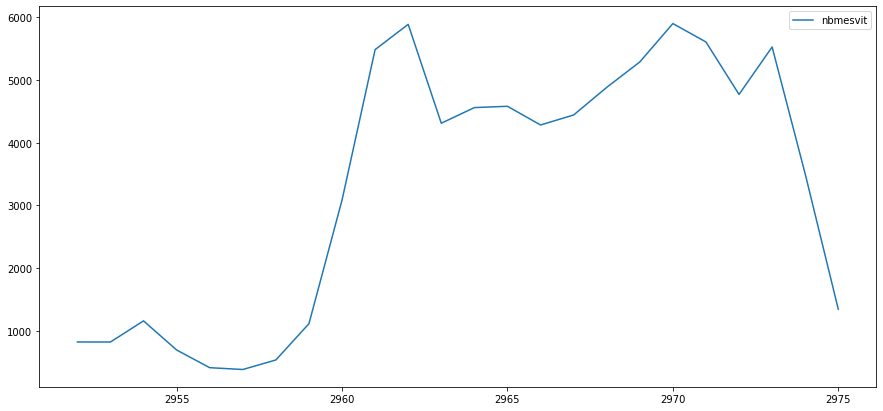

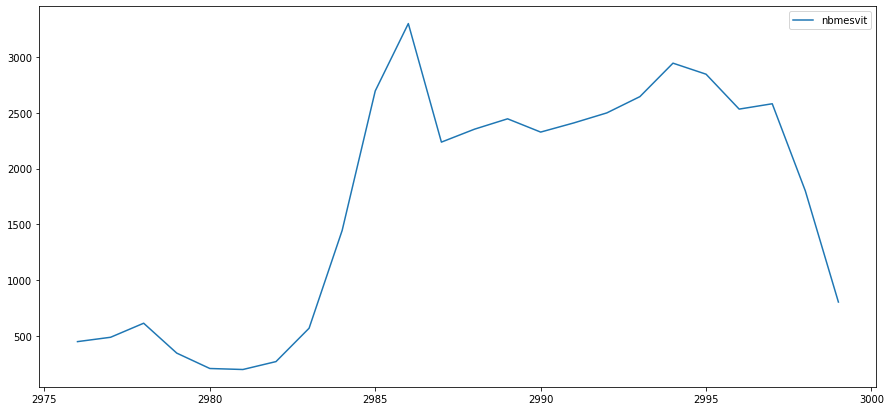

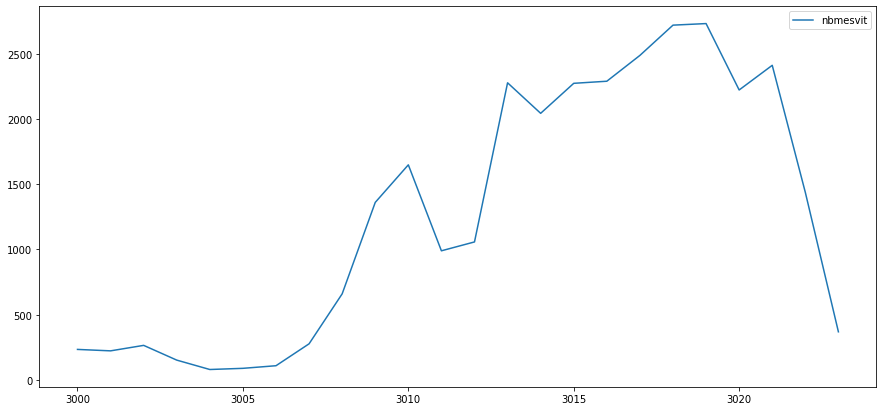

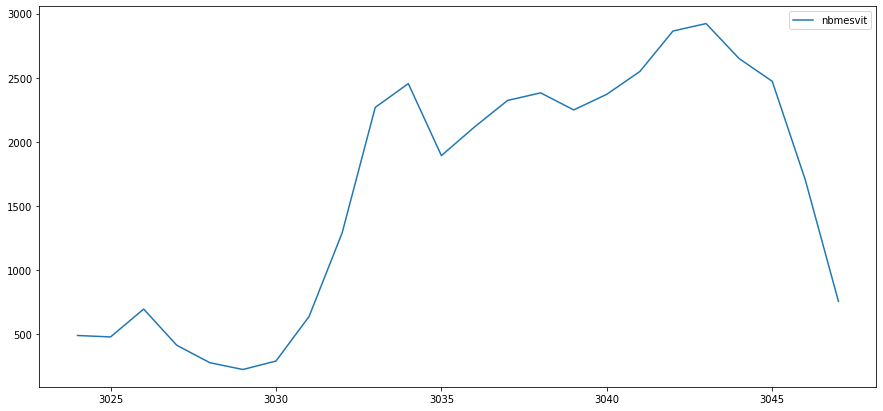

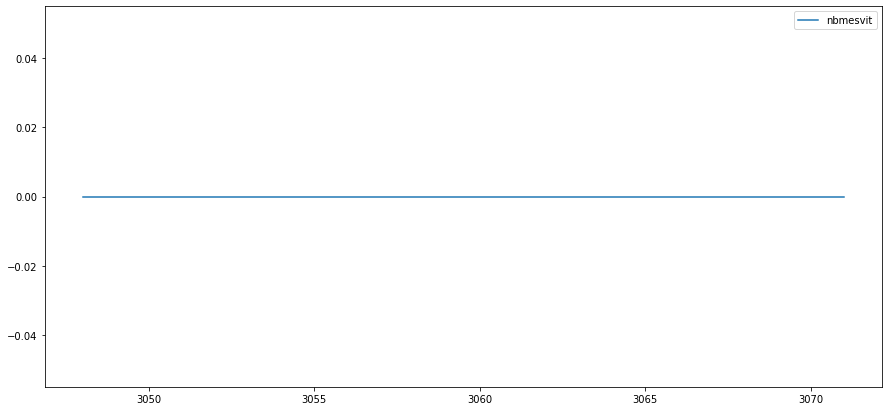

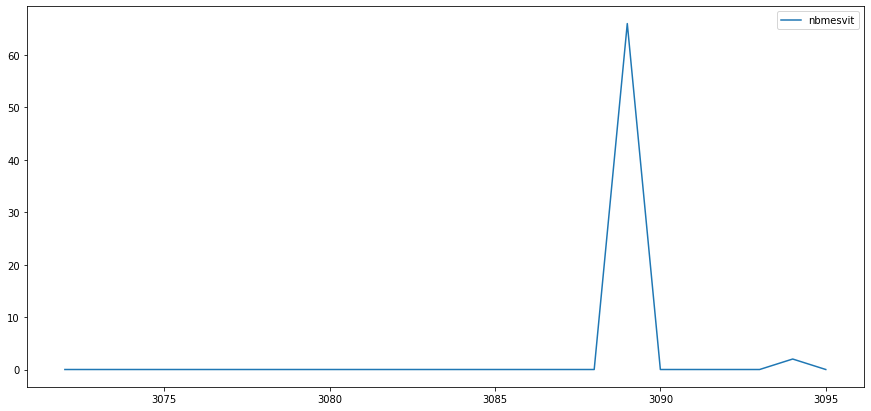

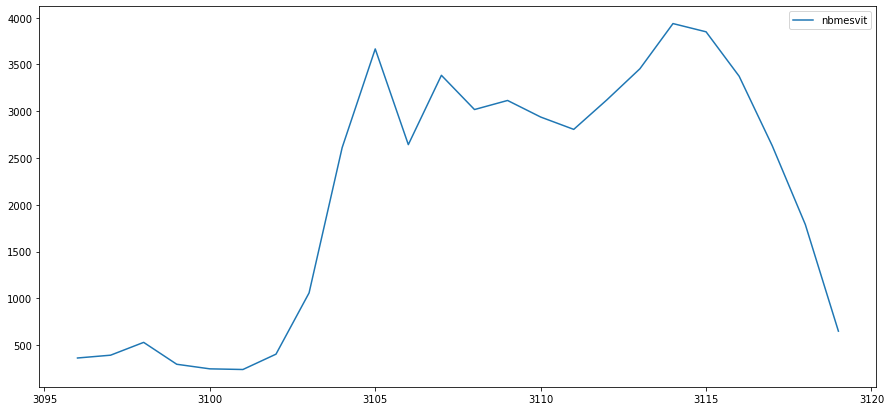

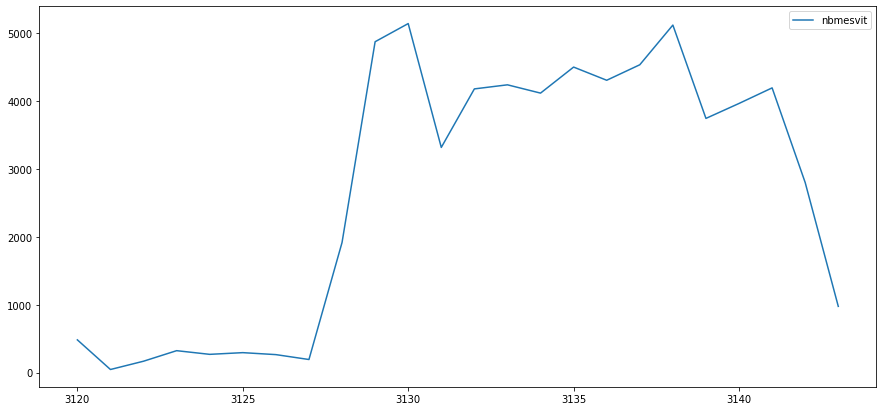

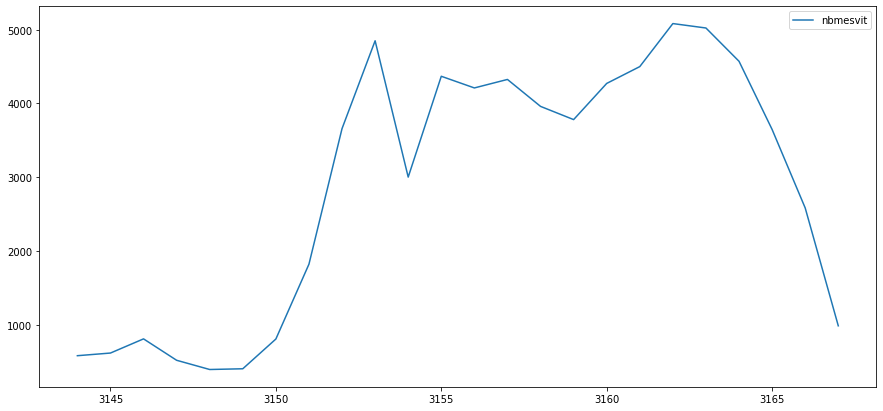

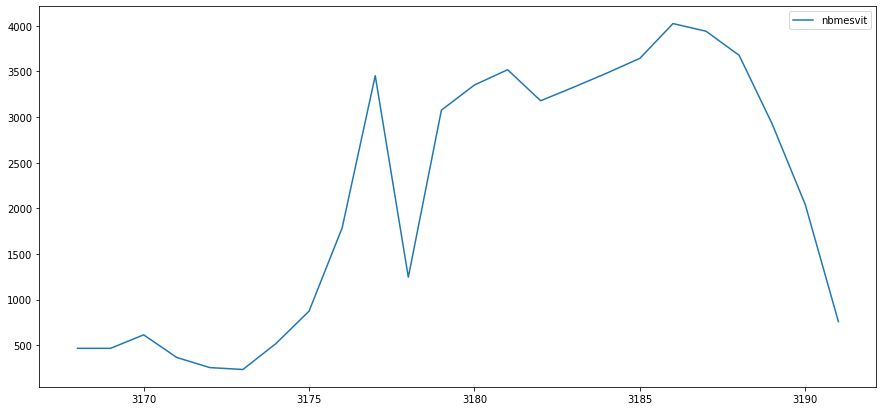

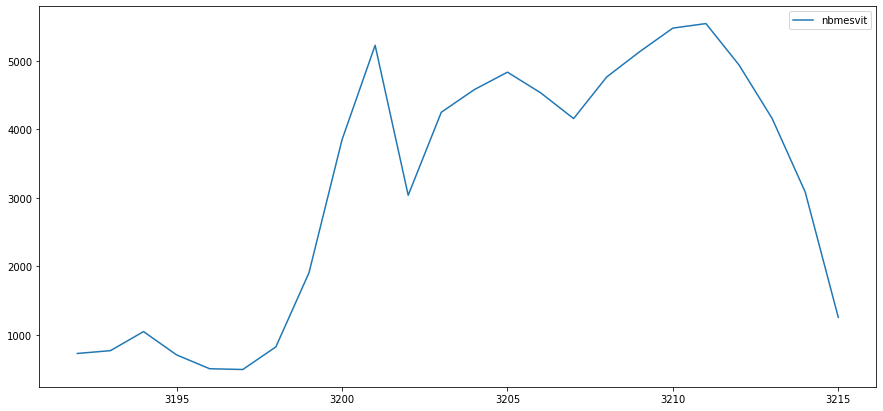

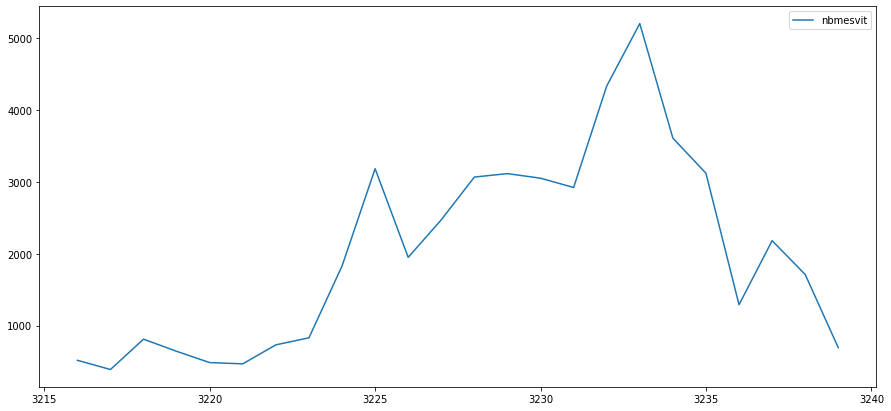

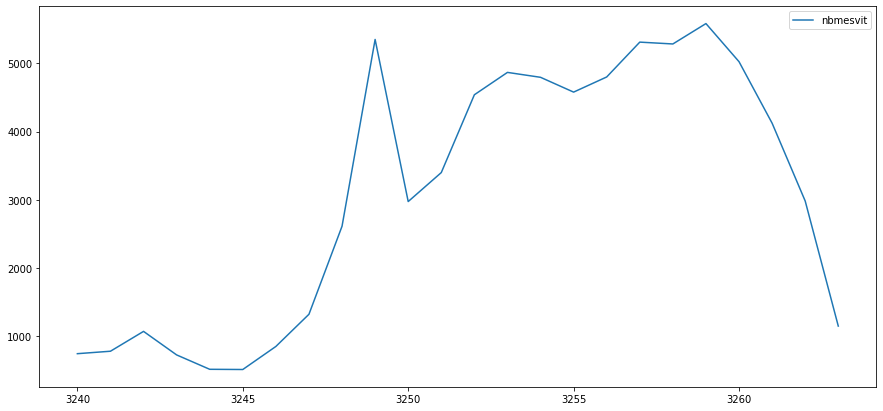

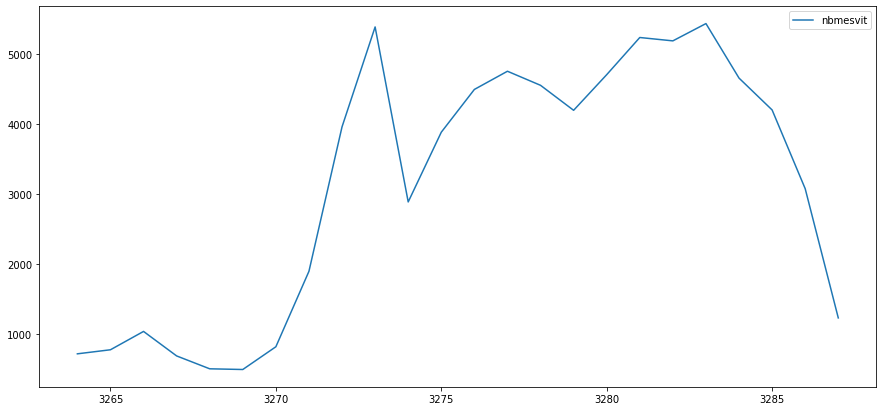

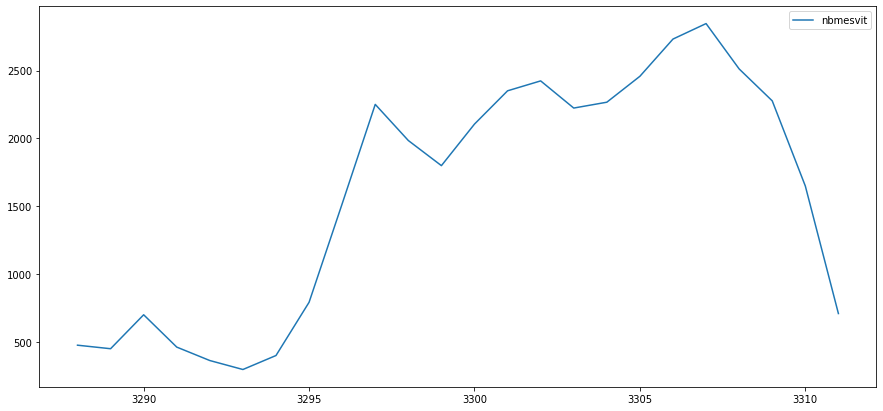

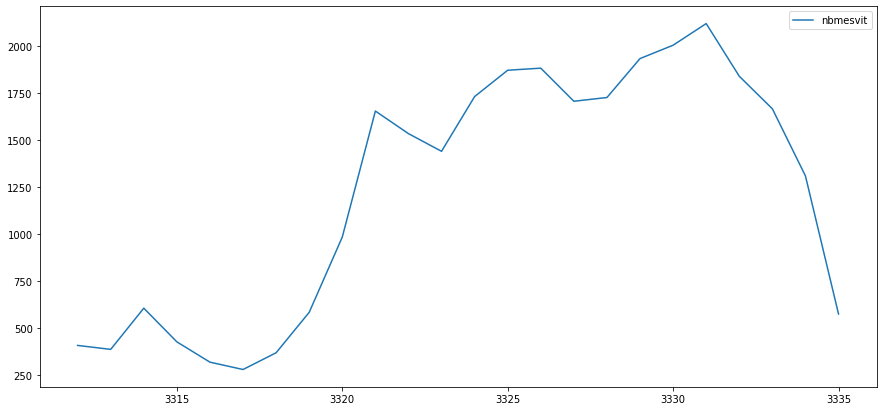

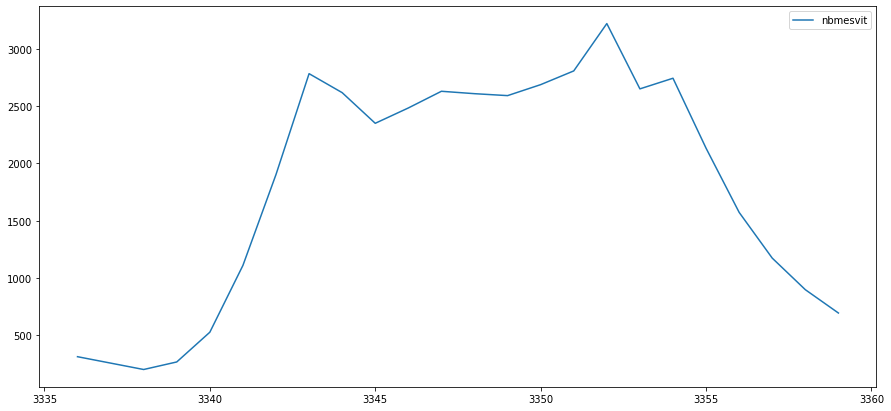

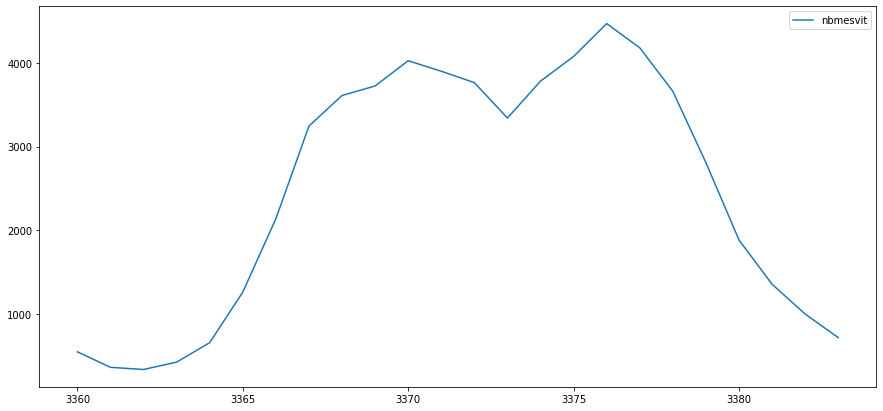

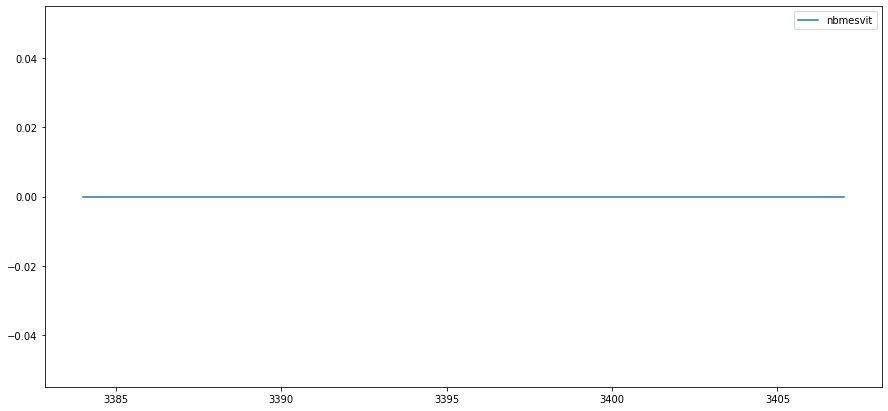

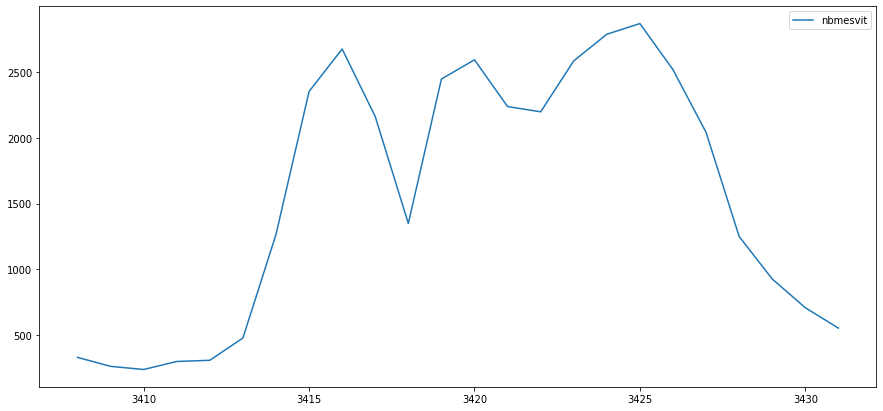

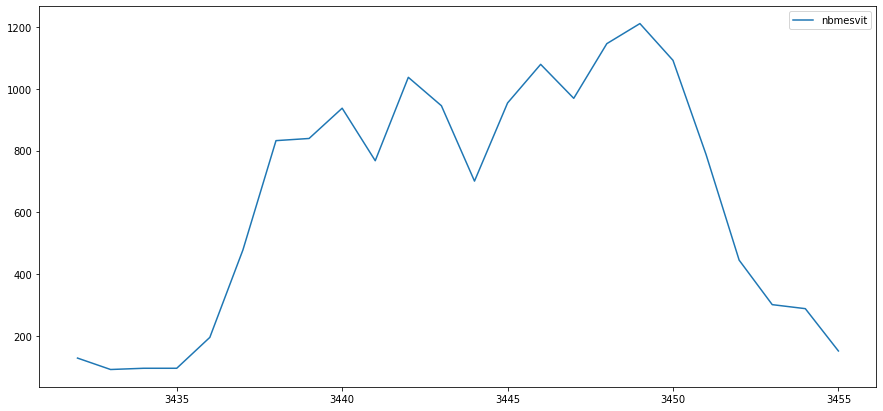

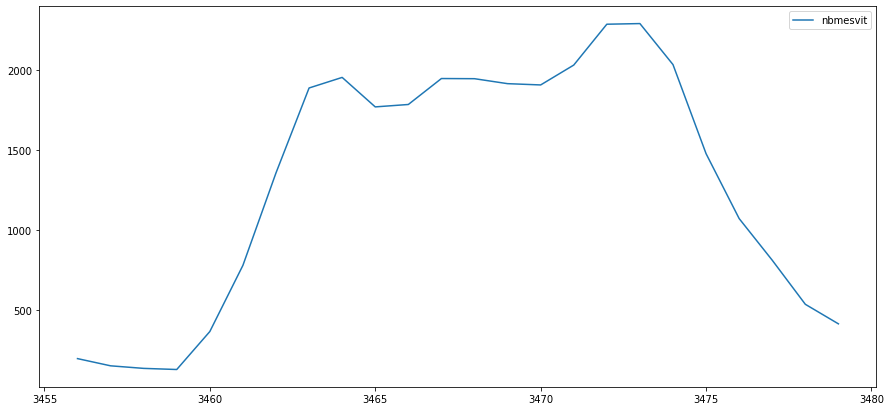

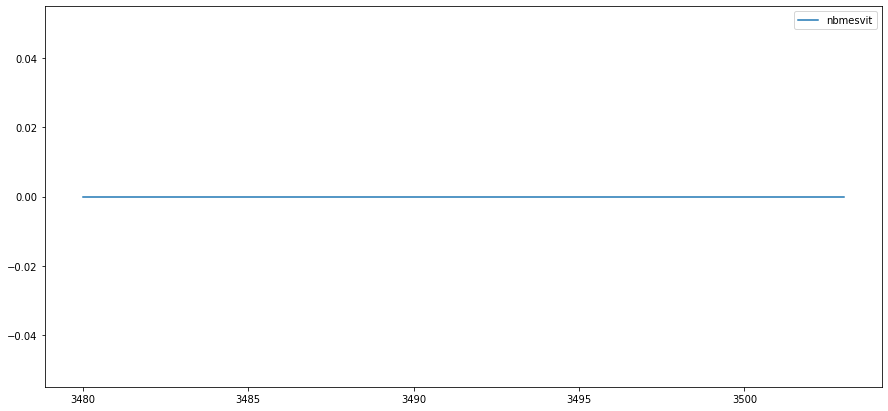

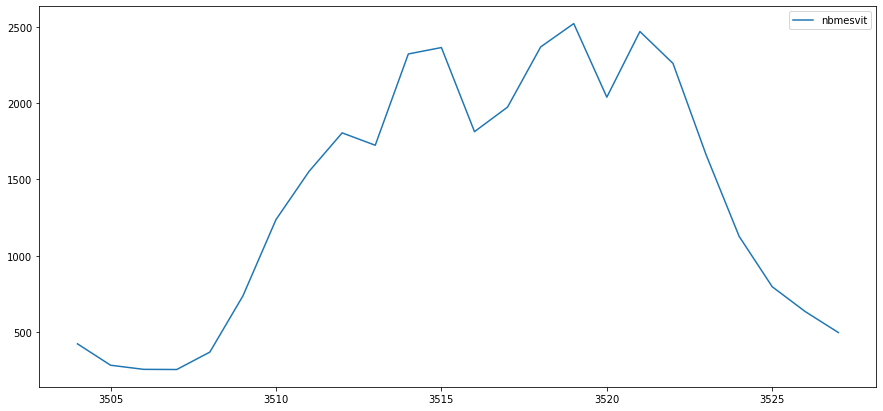

In [44]:
# nb de mesures par heure (donc débit horaire), 1 courbe par station
qualite[['nbmesvit','station']].groupby('station').plot(figsize=(15,7))

In [45]:
qualite.loc['M1B'].plot(figsize=(15,7))

KeyError: 'M1B'

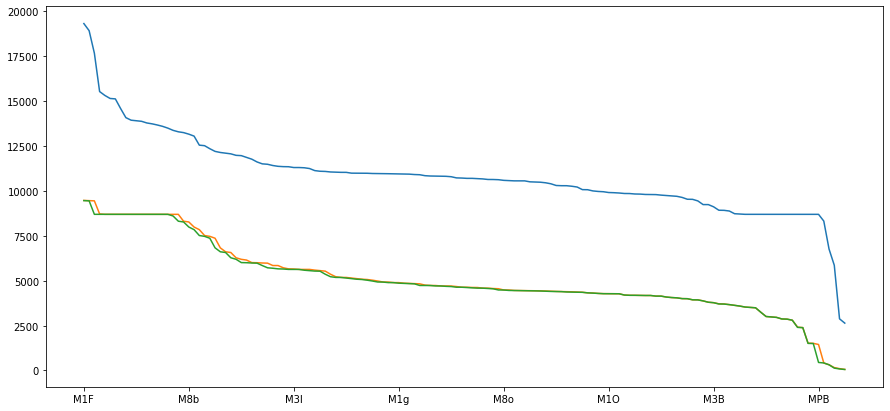

In [212]:
hmvl["station"].value_counts().plot(figsize=(15,7))
hmvl[hmvl["vitesse"].isna()]["station"].value_counts().plot()
hmvl[hmvl["longueur"].isna()]["station"].value_counts().plot()
# Il reste quelaques (une dizaine de stations) avec des vitesses ou longueurs vides
# là aussi on pourrait calculer un indicateur par station et par jour
# et le stocker en base


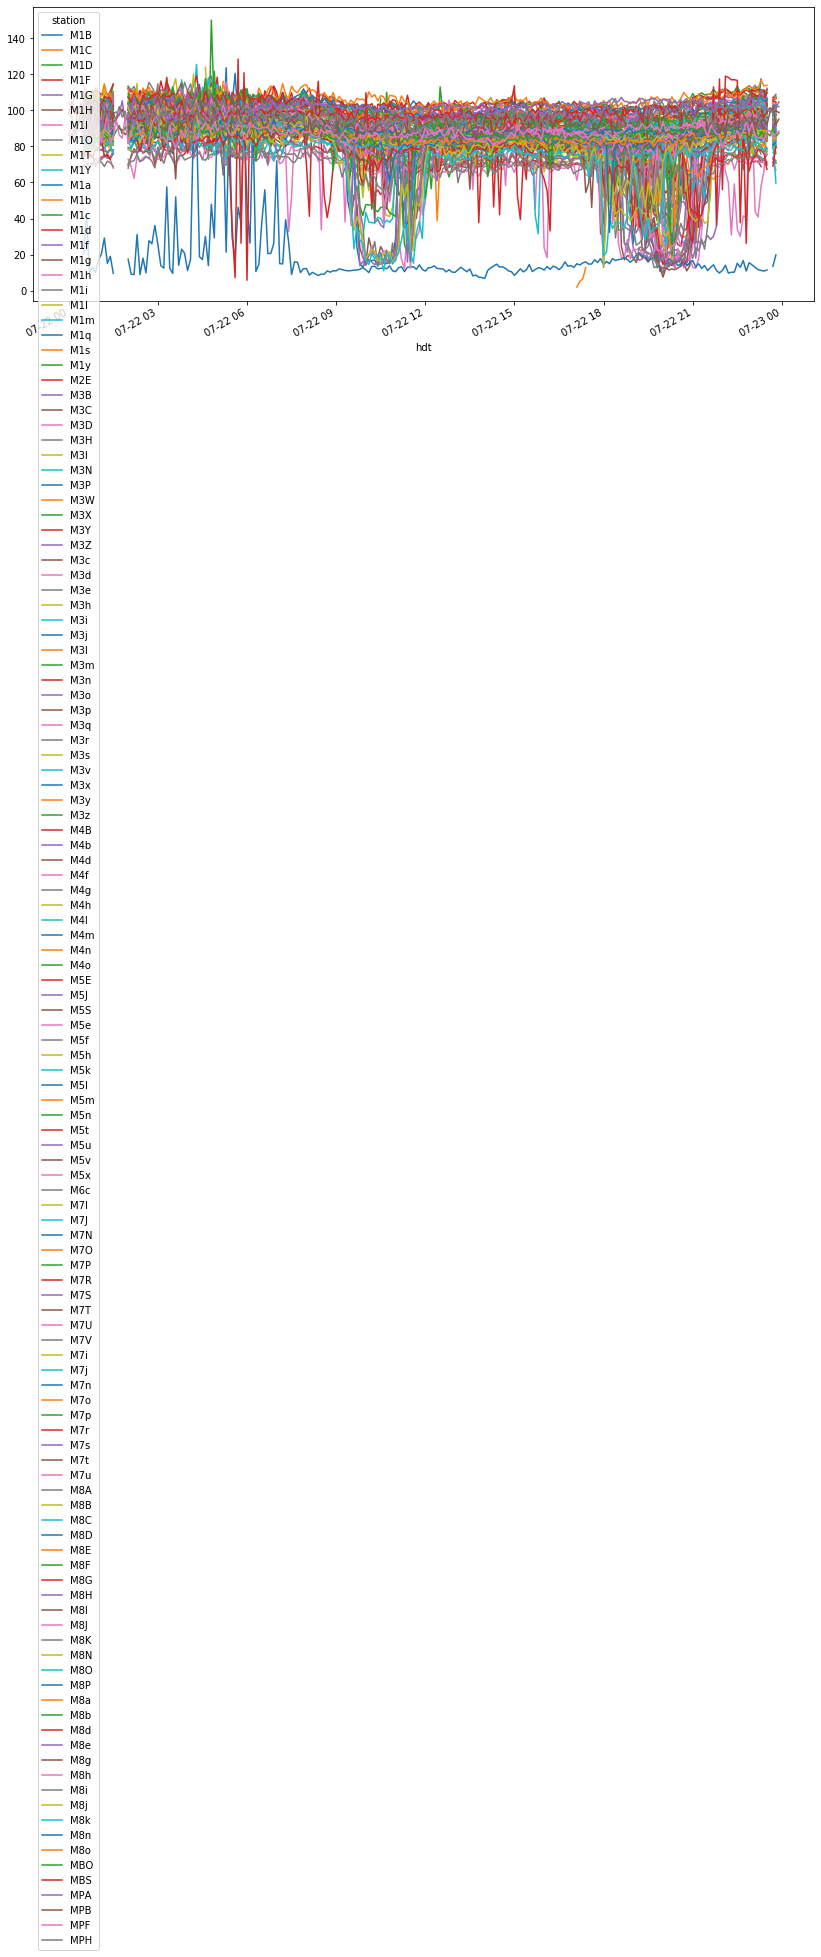

In [48]:
moy6['v6'].unstack().T.plot(figsize=(14,6))
# avant 10H on a seulement les données LABOCOM

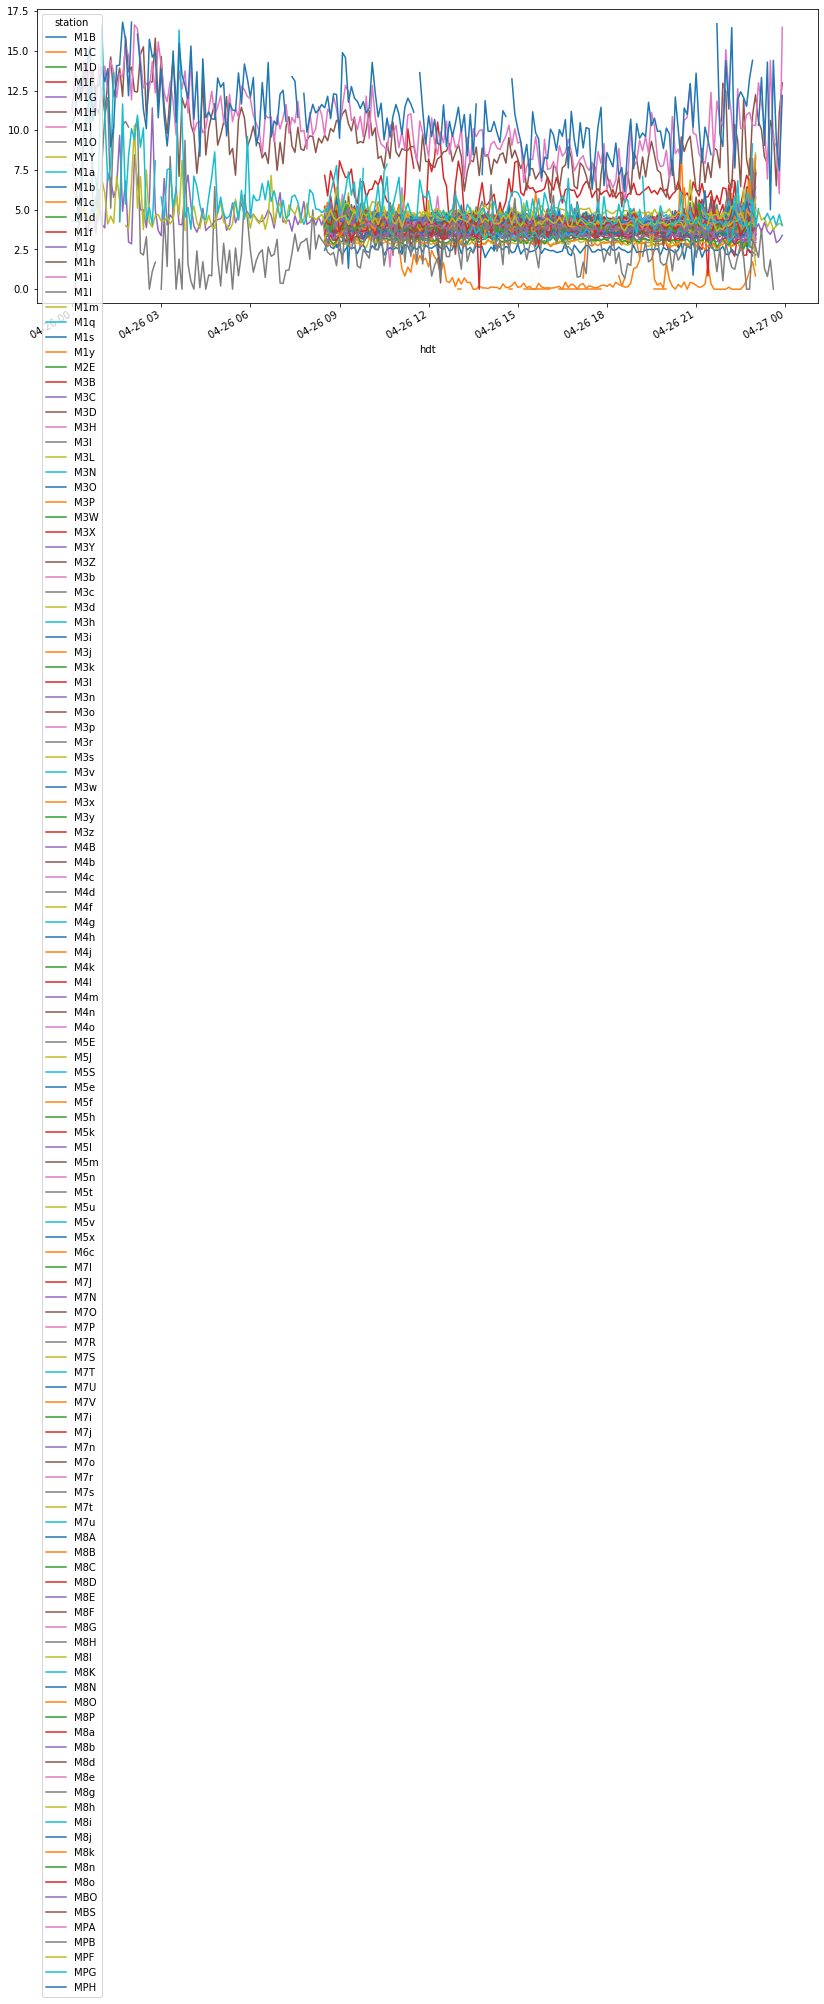

In [214]:
moy6['l6'].unstack().T.plot(figsize=(14,6))

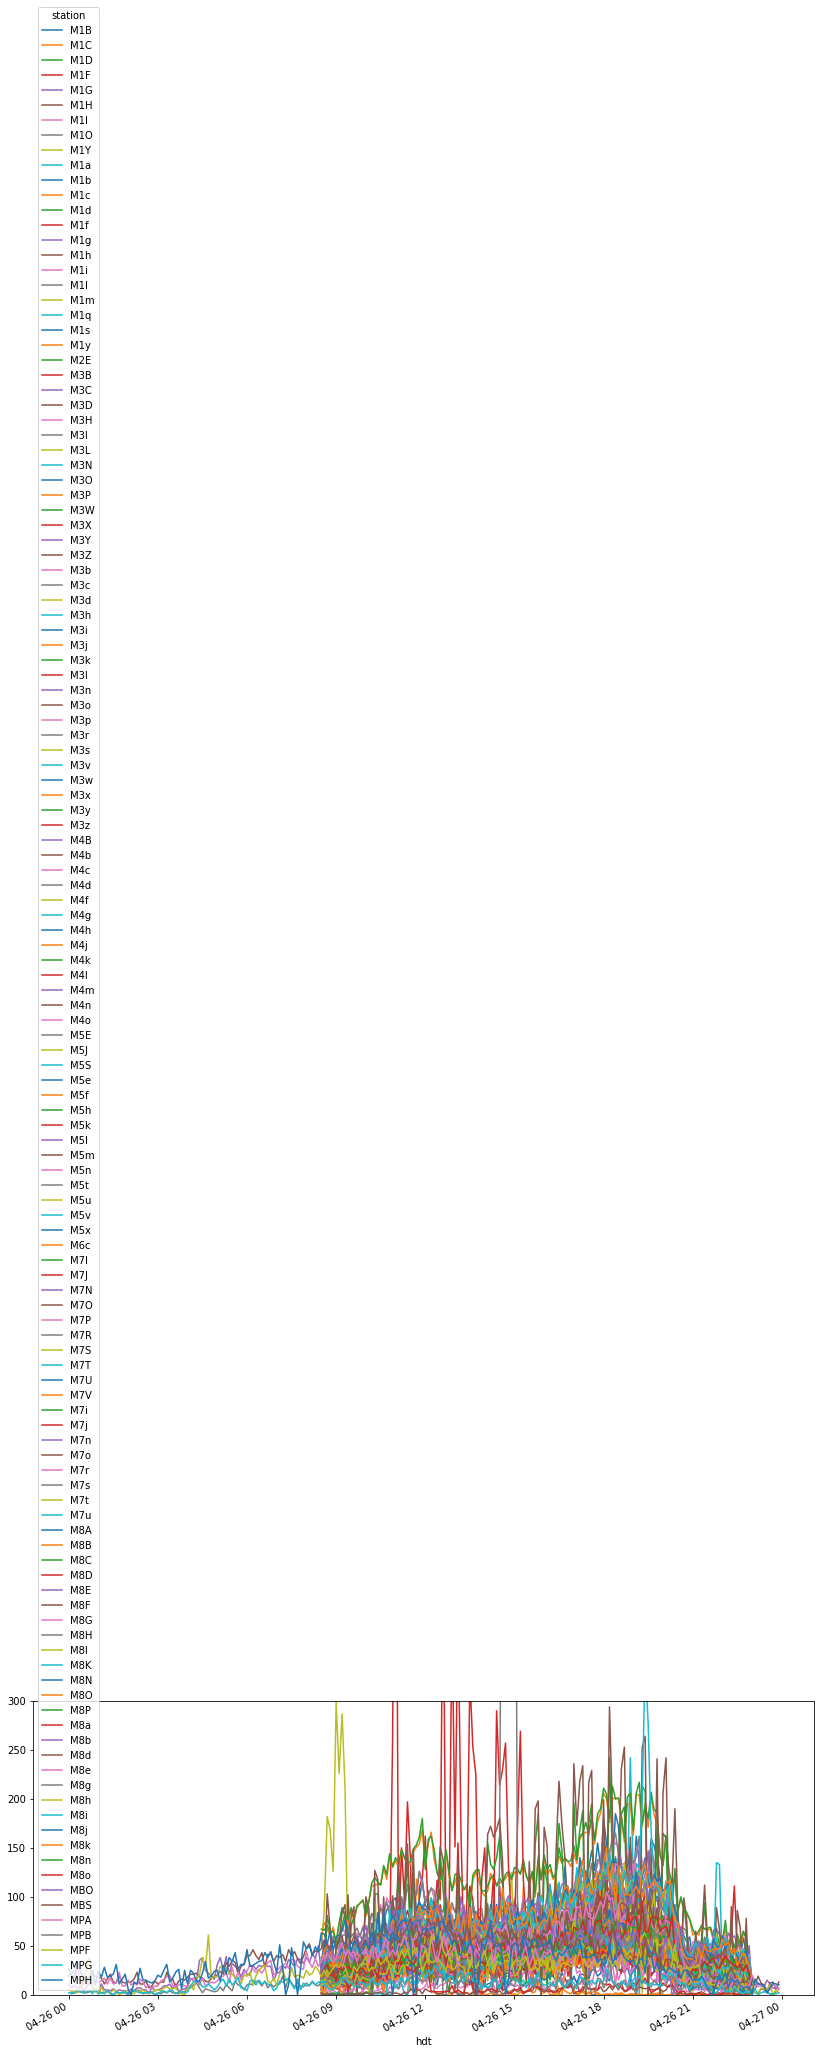

In [215]:
moy6['q6'].unstack().T.plot(figsize=(14,6),ylim=(0,300))
# on n'affiche pas les débits > 300 par 6' qui sont a priori trop élevés??

## 8. Carte des stations:  tests geopandas référentiel des stations SRDT

In [49]:
# conda install geopandas comme préalable (dans l'env hmvl : conda activate hmvl), de même pour contextily
import geopandas
import contextily as ctx

In [50]:
srdt=geopandas.read_file('ressources/SRDT_DIRMed.shp')
ref=pd.read_csv('ressources/pointsdemesure.csv')
# il y a 279 points de mesure dans le fichier CSV de référence, chacun avec un nom unique (codePM ou codeSOL2)
# dans le shapefile SRDT il y a 237 entrées alors que ça couvre toute la DIR et pas seulement le district urbain, 
# et il y a des doublons (234 valeurs uniques du champ IdNat qui contient à la fois des codes PM et des codes MISOL2)
# il faudra récupérer des données plus propres
# dans un 1er temps on prend les données comme elles sont

In [51]:
srdt=srdt[['objetID','route','idNat','commentair','geometry']]
ref=ref[['Code PM','Libellé','PR début','PR fin','Sens','Axe','Code MISOL2']]

In [52]:
srdt=srdt.rename(columns={"objetID": "ID", "route": "axe", 'idNat': "PM", "commentaire":"nom"})
ref=ref.rename(columns={"Code PM": "PM", "Libellé": "infos", "PR début":"PRD", "PR fin":"PRF", 'Code MISOL2':'SOL2'})
sol2pm=dict(zip(ref.SOL2,ref.PM))

In [53]:
sol2pm

{'MM413.C': 'M4C',
 'MM413.D': 'M4D',
 'MM413.E': 'M4E',
 'MM413.F': 'M4F',
 'MM413.G': 'M4G',
 'MM413.c': 'M4c',
 'MM413.d': 'M4d',
 'MM413.e': 'M4e',
 'MM413.f': 'M4f',
 'MM413.g': 'M4g',
 'MM413.K': 'M4K',
 'MM413.L': 'M4L',
 'MM413.M': 'M4M',
 'MM413.N': 'M4N',
 'MM413.O': 'M4O',
 'MM413.k': 'M4k',
 'MM413.l': 'M4l',
 'MM413.m': 'M4m',
 'MM413.n': 'M4n',
 'MM413.o': 'M4o',
 'MM413.H': 'M4H',
 'MM413.I': 'M4I',
 'MM413.J': 'M4J',
 'MM413.h': 'M4h',
 'MM413.i': 'M4i',
 'MM413.j': 'M4j',
 'MM113.A': 'M1A',
 'MM113.B': 'M1B',
 'Mm113.B': 'm1B',
 'MM113.C': 'M1C',
 'MM113.D': 'M1D',
 'MM113.E': 'M1E',
 'MM113.F': 'M1F',
 'Mm113.F': 'm1F',
 'MM113.G': 'M1G',
 'MM113.H': 'M1H',
 'MM113.I': 'M1I',
 'MM113.J': 'M1J',
 'MM113.L': 'M1L',
 'MM113.M': 'M1M',
 'MM113.O': 'M1O',
 'MM113.Q': 'M1Q',
 'MM113.S': 'M1S',
 'MM113.T': 'M1T',
 'MM113.Y': 'M1Y',
 'MM113.a': 'M1a',
 'MM113.b': 'M1b',
 'MM113.c': 'M1c',
 'MM113.d': 'M1d',
 'MM113.e': 'M1e',
 'Mmb13.e': 'mbe',
 'MM113.f': 'M1f',
 'Mmb13.f': 

In [54]:
srdt=pd.merge(srdt,ref,on=['PM'],how='inner')
# on fait une jointure sur les PM présents dans SRDT (qui est notre référence pour les coordonnées des stations) 
#   et dans ref (qui est notre référence pour les données hmvl)
# on voit qu'il ne reste que 168 points (sur 279!)

In [55]:
for i in range(len(srdt['PM'])):
    #print (i)
    j=srdt['PM'].iloc[i]
    #print(j)
    if j not in ref['PM'].to_list():
        if j not in sol2pm:
            print (j+" présent dans shapefile srdt et pas dans le réf csv")
        else:
            srdt['PM'].iloc[i]=sol2pm[srdt['PM'].iloc[i]]

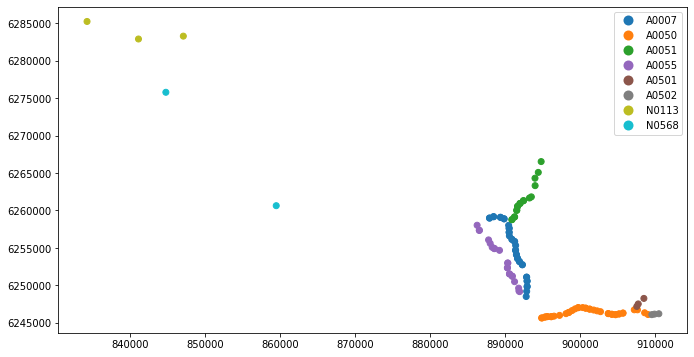

In [56]:
srdt.plot(column='axe',figsize=(14,6),legend=True)
# couleur selon l'axe, il manque L2

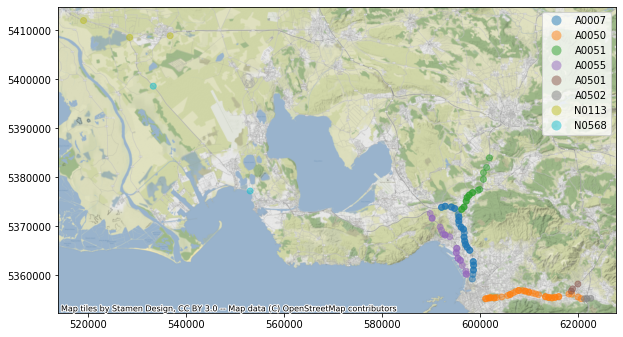

In [57]:
srdt=srdt.to_crs(epsg=3857)
# voir https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html
ax = srdt.plot(figsize=(10, 10), alpha=0.5, column='axe',legend=True)
# couleur selon l'axe, il manque L2
ctx.add_basemap(ax,zoom=13)

In [14]:
srdt

ID    axe   PM      commentair  \
0    DIRMED_SRDT_000119  A0007  M7I       Agavon_Tr   
1    DIRMED_SRDT_000121  A0007  M7J        L_ANJOLY   
2    DIRMED_SRDT_000122  A0007  M7N  LES_PENNES_MIR   
3    DIRMED_SRDT_000124  A0007  M7O  A55_LES_PENNES   
4    DIRMED_SRDT_000126  A0007  M7P            None   
..                  ...    ...  ...             ...   
163  DIRMED_SRDT_000172  N0568  MPF            None   
164  DIRMED_SRDT_000168  N0568  MPF         Fos PMV   
165  DIRMED_SRDT_000208  N0568  MBO    Fos Est N568   
166  DIRMED_SRDT_000173  N0568  MPG            None   
167  DIRMED_SRDT_000211  N0569  MBT     Dev Miramas   

                           geometry                   infos      PRD      PRF  \
0    POINT (884698.002 6259859.435)    PME_A7_1_264+687_M7I  264+687  265+187   
1    POINT (885065.662 6259489.631)    PME_A7_1_265+320_M7J  265+320  265+820   
2    POINT (886908.352 6258773.111)    PME_A7_1_267+230_M7N  267+230  267+730   
3    POINT (887531.570 6258833.916)    PME_A7_1_267+861_M7O  267+861  268+361   
4    POINT (887950.220 6258980.552)    PME_A7_1_268+288_M7P  268+288  268+788   
..                              ...                     ...      ...      ...   
163  POINT (859489.837 6260638.948)  PME_RN568_25+350_1_MPF   25+350   26+350   
164  POINT (855764.954 6263993.900)  PME_RN568_25+350_1_MPF   25+350   26+350   
165  POINT (859477.063 6260641.631)  PME_RN568_30+980_1_MBO   30+980   31+800   
166  POINT (844766.462 6275767.152)   PME_RN568_9+250_1_MPG    9+250   10+250   
167  POINT (861004.135 6279899.522)   PME_RN569_5+068_1_MBT    5+068    5+500   

     Sens   Axe     SOL2  
0       1    A7  MM713.I  
1       1    A7  MM713.J  
2       1    A7  MM713.N  
3       1    A7  MM713.O  
4       1    A7  MM713.P  
..    ...   ...      ...  
163     1  N568  MMP13.F  
164     1  N568  MMP13.F  
165     1  N568  MMB13.O  
166     1  N568  MMP13.G  
167     1  N569  MMB13.T  

[168 rows x 11 columns]